In [ ]:
# @title Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

import statsmodels.stats.multicomp as mc

from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from scipy.stats import chi2_contingency

from scipy.stats import ttest_ind
import random

In [ ]:
# @title Connection google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# @title Definition of usefull functions
# ------------- Plot configuration

palette = sns.color_palette("tab20")

plot_colours = [color for color in palette.as_hex()]
plot_colours80s = ['blue', 'green', 'red', 'orange', 'yellow']

def plot_success_rate_by_parameter(df, x, groupBy, xlabel, ylabel, title, colours = plot_colours):
  grouped = df.groupby(groupBy)
  # Calculate success rate
  success_rate = 100*grouped['Success'].sum() / grouped['Success'].count()

  # Plot histogram
  plt.bar(success_rate.index, success_rate.values, color=colours)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title + x)
  plt.ylim(0,100)
  display_text_size = 6
  for i in range(len(success_rate)):
    plt.text(i, success_rate[i], str(success_rate[i])[:display_text_size], ha='center', va='bottom')
  plt.show()

#---------------------------------------PLOT----------------------------------------------------------------------
def plot_bar_average_parameter(df_lex, group_by, xlabel, ylabel, title, condition = ''):
  average_data = df_lex.groupby(group_by)
  if condition != '':
    average_data = average_data[condition]
  average_data = average_data.mean()
  # Create the line graph
  average_data.plot(kind='bar', figsize=(25, 15))
  # Set the title and labels
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  display_text_size = 4
  for i in range(len(average_data)):
    plt.text(i, average_data[i], str(average_data[i])[:display_text_size], ha='center', va='bottom')
  # Show the plot
  plt.show()

# we create a function in which we give the headers and the data manually. Aims at making a plot
# we need as many elements in the headers as in data.
# for example : headers = ['title1', 'title2']
#               data = ['25', 'numbers']
def plot_2d_array(headers, data, xlabel, ylabel, title, display_text_size = 6, colours = plot_colours, fig_size = ''):
  if fig_size != '':
    plt.figure(figsize=fig_size)
  plt.bar(headers, data, color=colours)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.ylim(0, 100)
  for i in range(len(data)):
    plt.text(i, data[i], str(data[i])[:display_text_size], ha='center', va='bottom')
  plt.show()

#-------------------------ttest-----------------------------------------
def do_ttest(val1, val2):

  #
  val1 = pd.to_numeric(val1, errors='coerce')
  val2 = pd.to_numeric(val2, errors='coerce')

  print("---- Performing Ttest ----")
  # Perform independent samples t-test
  t_statistic, p_value = stats.ttest_ind(val1, val2)

  # Interpret the results
  alpha = 0.05
  if p_value < alpha:
      print("Reject the null hypothesis. There is a significant difference between the means.")
  else:
      print("Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")

  # Print the t-statistic and p-value
  print("t-statistic:", t_statistic)
  print("p-value:", p_value)
  print("")

#-----------------------------Anova---------------------------------
#here are two different ways to run an anova test
def do_anova_test(data):

  print("---- Performing ANOVA test ----")
  # Perform ANOVA test

  f_statistic, p_value = stats.f_oneway(*data)

  # Interpret the results
  alpha = 0.05
  if p_value < alpha:
      print("Reject the null hypothesis. There is a significant difference between at least one pair of means.")
  else:
      print("Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")

  # Print the F-statistic and p-value
  print("F-statistic:", f_statistic)
  print("p-value:", p_value)
  print("")

def do_anova(dataset, param1, param2):
    # Perform ANOVA
    #param2 is always categorical (not a number)
  dataset[param1] = pd.to_numeric(dataset[param1], errors='coerce')
  model = ols(f'{param1} ~ C({param2})', data=dataset).fit()
  anova_result = sm.stats.anova_lm(model, typ=2)
  print("ANOVA results:")
  print(anova_result)

  # Perform Tukey HSD test if ANOVA is significant
  if anova_result['PR(>F)'][0] < 0.05:
      print("\nTukey HSD test results:")
      tukey = pairwise_tukeyhsd(endog=dataset[param1], groups=dataset[param2], alpha=0.05)
      print(tukey)
  else:
      print("ANOVA is not significant, so Tukey HSD test is not performed.")

#--------------------------------------------CHI2----------------------------------
def do_chi_square_test(data_compare1, data_compare2):

  # Create a contingency table
  contingency_table = pd.crosstab(data_compare1, data_compare2)

  # Perform Chi-square test
  chi2, p, dof, ex = chi2_contingency(contingency_table)

  # Print the results
  print(f"Chi-square statistic: {chi2}")
  print(f"P-value: {p}")
  print(f"Degrees of freedom: {dof}")
  print("Expected frequencies table:")
  print(ex)
  # Check if the result is significant
  alpha = 0.05
  if p < alpha:
      print("The result is significant. There is a significant association between the variables.")
  else:
      print("The result is not significant. There is no significant association between the variables.")

#-------------------------------------Signal detection Theory------------------------------
def signal_detection_theory(dataset):

  df_hit = dataset[dataset['SDT'] == 'hit']
  df_miss = dataset[dataset['SDT'] == 'miss']
  df_false_alarm = dataset[dataset['SDT'] == 'FA']
  df_correct_rejection = dataset[dataset['SDT'] == 'CR']

  print("Hit : " + str(df_hit.size / dataset.size * 100) + " %")
  print("Miss : " + str(df_miss.size / dataset.size * 100) + " %")
  print("False Alarm : " + str(df_false_alarm.size / dataset.size * 100) + " %")
  print("Correct Rejection : " + str(df_correct_rejection.size / dataset.size * 100) + " %")

#------------------------------calculate success rate (numerical value)-------------------------------------
def calculate_success_rate_by(dataset, column):

  print('\nCalculating success rate for ' + column + '\n')
  dataset['SuccessRate' + column] = None
  tempParticipant = {}

  for x in dataset[column].unique():
    success_responses = dataset[(dataset[column] == x) & dataset['Success'] == 1]['Success'].sum()
    total_responses = dataset[(dataset[column] == x)]['Success'].count()
    if total_responses == 0:
      total_responses = 1

    tempParticipant[x] = round(success_responses / total_responses * 100, 2)

    print("Success rate for " + x + " is " + str(round(success_responses / total_responses * 100, 2)) + "%")

  for part in tempParticipant:
    dataset.loc[dataset[column] == part, 'SuccessRate' + column] = tempParticipant[part]

  return dataset

#---------------------------------Logistic regression-----------------------------------------
def do_logistic_regression(dataset, predicators, target):

  dataset[predicators] = pd.to_numeric(dataset[predicators], errors='coerce') / 100
  dataset[target] = pd.to_numeric(dataset[target], errors='coerce') / 100

  dataset['Intercept'] = 1
  X = dataset[['Intercept', predicators]]
  y = dataset[target]

  logit_model = sm.Logit(y, X)
  result = logit_model.fit()

  print(result.summary())


print('Functions defined')

Functions defined


In [ ]:
# @title Data

# -------------formatage data

df_lex = pd.read_csv('/content/drive/MyDrive/R/LexicalDecision.csv')

#new Column Success where expected and response key are the same - > 1
#For non mod phones: if expected key matches the key resp = success
#For mod phones: if expected key does not match the key resp = success
success_condition = (((df_lex['Condition'].isin(["NotModifiedT", "NotModifiedSH"]) & (df_lex['ExpectedKey'] == df_lex['key_resp_question3.keys'])) |
                    (df_lex['Condition'].isin(["ModifiedT", "ModifiedSH"]) & (df_lex['ExpectedKey'] != df_lex['key_resp_question3.keys']))))

df_lex['Success'] = np.where(success_condition, 1, 0)

# ----------------------------- Data df_lex ------------------------
#map to age
age_mapping = {1: '3-17', 2: '18-37', 3: '38 and above'}
df_lex['Age_group'] = df_lex['Age'].map(age_mapping)

#NI is transformed into Northern Ireland (replaces)
df_lex['Country'] = df_lex['Country'].replace('NI', 'Northern Ireland')
#ItemNB is a string
df_lex['ItemNb'] = df_lex['ItemNb'].astype(str)

# Categorize 'Country' into 'Ireland' and 'Other English speaking countries'
df_lex['Country_Categorized'] = df_lex['Country'].apply(lambda x: 'Ireland' if x == 'Ireland' else 'Other English speaking countries')


# -----------------------------------------------------------

#get all the uni conditions (goes to every value in the column and saves the unique values into the list condition)
#condition = pd.array(df_lex['Condition'].unique())

# 2. Ordre des conditions attendues par les définitions de df_... plus bas
condition = ["NotModifiedSH", "NotModifiedT", "ModifiedT", "ModifiedSH"]


#split the diff conditions in 4 tables
df_not_mod_SH = df_lex[df_lex['Condition'] == condition[0]]
df_not_mod_T = df_lex[df_lex['Condition'] == condition[1]]
df_mod_T = df_lex[df_lex['Condition'] == condition[2]]
df_mod_SH = df_lex[df_lex['Condition'] == condition[3]]


#create log transformation columns
df_lex['ReactionTimeLogTransform'] = np.log(df_lex['Reaction time'])
df_lex['FrequencyLogTransform'] = np.log(df_lex['Frequency'])


# Categorize 'Country' into 'Ireland' and 'Northern Ireland'
df_lex['Country_NIandIreland'] = df_lex['Country'].apply(lambda x: x if x in ['Ireland', 'Northern Ireland'] else 'Other')


print('Data initilised')

Data initilised


In [ ]:
# @title Adding Calculated Success Rate
df_lex = calculate_success_rate_by(df_lex, 'Participant')

df_lex = calculate_success_rate_by(df_lex, 'Irish')

df_lex = calculate_success_rate_by(df_lex, 'Age_group')

df_lex = calculate_success_rate_by(df_lex, 'Country_Categorized')

df_lex = calculate_success_rate_by(df_lex, 'Gender')

df_lex = calculate_success_rate_by(df_lex, 'Condition')

df_lex = calculate_success_rate_by(df_lex, 'Country_NIandIreland')


Calculating success rate for Participant

Success rate for 3193 is 64.52%
Success rate for 9212 is 64.52%
Success rate for 66543 is 38.71%
Success rate for 97863 is 58.06%
Success rate for 141455 is 70.97%
Success rate for 144849 is 77.42%
Success rate for 176747 is 51.61%
Success rate for 224578 is 29.03%
Success rate for 256908 is 61.29%
Success rate for 289381 is 35.48%
Success rate for 290430 is 87.1%
Success rate for 316470 is 64.52%
Success rate for 465866 is 61.29%
Success rate for 482742 is 54.84%
Success rate for 510053 is 54.84%
Success rate for 529170 is 74.19%
Success rate for 534483 is 45.16%
Success rate for 600329 is 45.16%
Success rate for 646029 is 74.19%
Success rate for 747765 is 32.26%
Success rate for 792528 is 64.52%
Success rate for 799622 is 61.29%
Success rate for 815124 is 54.84%
Success rate for 829249 is 48.39%
Success rate for 834521 is 93.55%
Success rate for 864646 is 80.65%
Success rate for 867341 is 74.19%
Success rate for 879868 is 54.84%
Success rate

In [ ]:
# @title save DataFrame to CSV
# Save DataFrame to CSV
df_lex.to_csv('df_lex.csv', index=False)

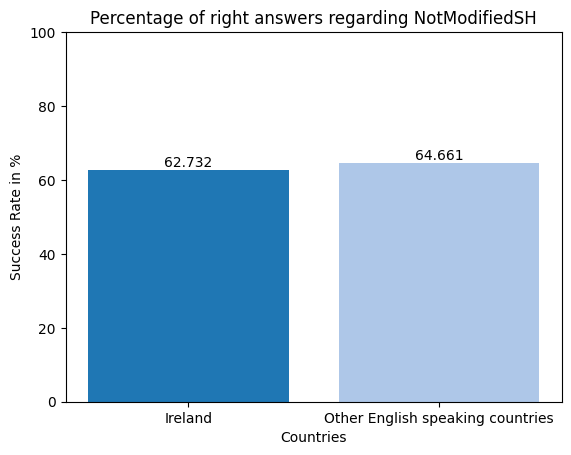

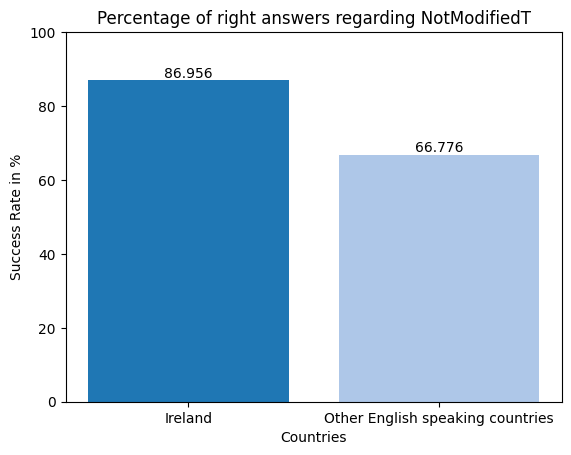

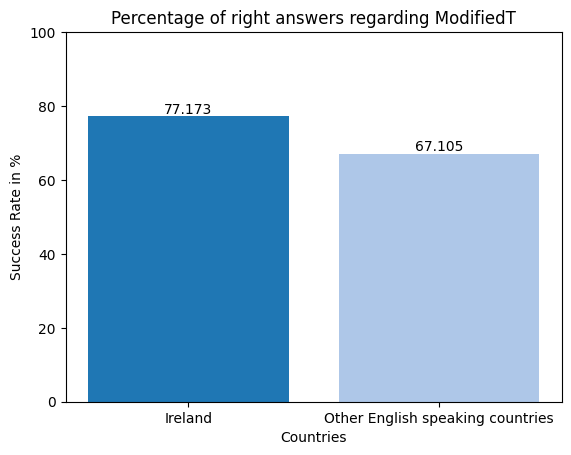

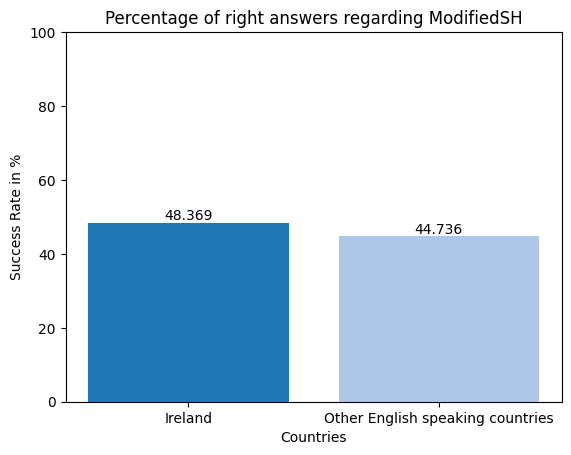

impact of country on success
Chi-square statistic: 12.921659104190363
P-value: 0.0003248018444428839
Degrees of freedom: 1
Expected frequencies table:
[[257.90163934 426.09836066]
 [455.09836066 751.90163934]]
The result is significant. There is a significant association between the variables.

impact of condition on success
Chi-square statistic: 100.51637953797778
P-value: 1.2035438681868452e-21
Degrees of freedom: 3
Expected frequencies table:
[[176.51612903 176.51612903 154.4516129  176.51612903]
 [311.48387097 311.48387097 272.5483871  311.48387097]]
The result is significant. There is a significant association between the variables.

ANOVA results:
                               sum_sq      df          F        PR(>F)
C(Country_Categorized)   30662.854474     1.0  155.15279  2.767658e-34
Residual                373323.175536  1889.0        NaN           NaN

Tukey HSD test results:
             Multiple Comparison of Means - Tukey HSD, FWER=0.05             
 group1              g

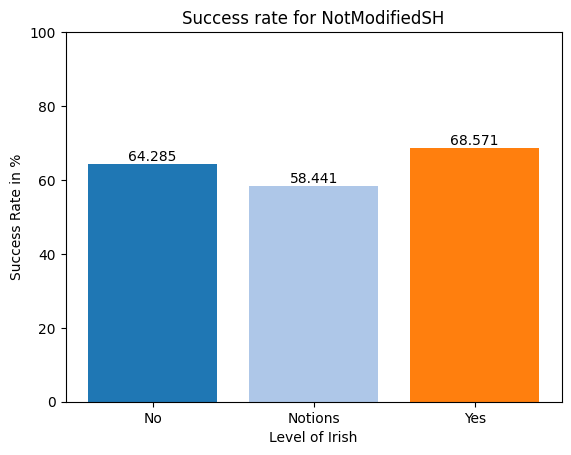

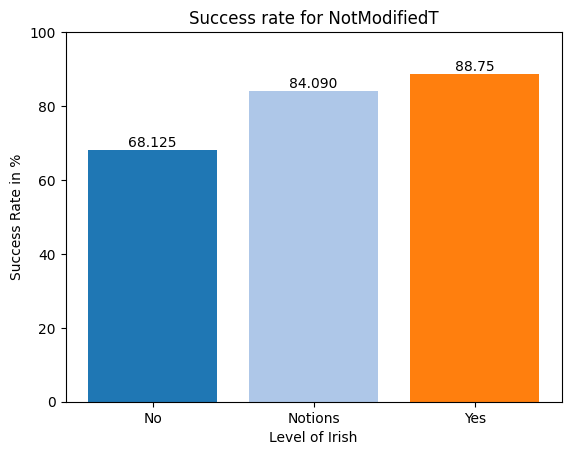

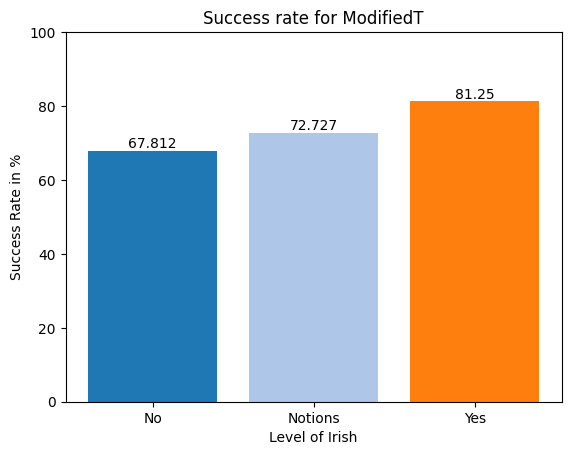

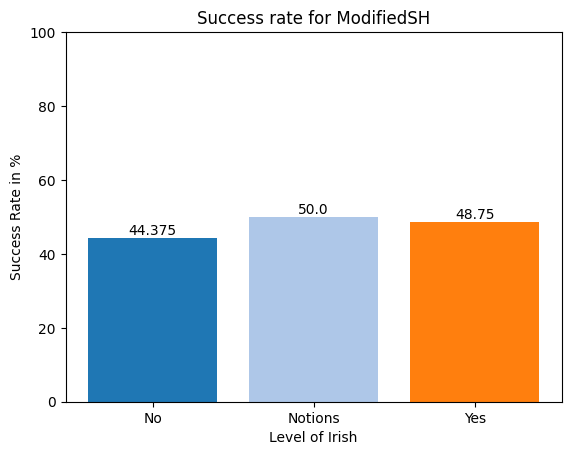

ANOVA results:
                 sum_sq      df          F        PR(>F)
C(Irish)   32531.273475     2.0  82.673654  3.813821e-35
Residual  371454.756535  1888.0        NaN           NaN

Tukey HSD test results:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1  group2 meandiff p-adj lower   upper  reject
----------------------------------------------------
     No Notions   5.5199   0.0 3.5082  7.5317   True
     No     Yes  10.8898   0.0 8.8006 12.9789   True
Notions     Yes   5.3698   0.0  2.788  7.9517   True
----------------------------------------------------
level of Irish yes vs no vs notions
---- Performing ANOVA test ----
Reject the null hypothesis. There is a significant difference between at least one pair of means.
F-statistic: 82.67365438115833
p-value: 3.8138212524735105e-35

Chi-square statistic: 14.085022005803465
P-value: 0.0008739293656561166
Degrees of freedom: 2
Expected frequencies table:
[[448.52459016 123.3442623  112.13114754]
 [791.47540984 217.65573

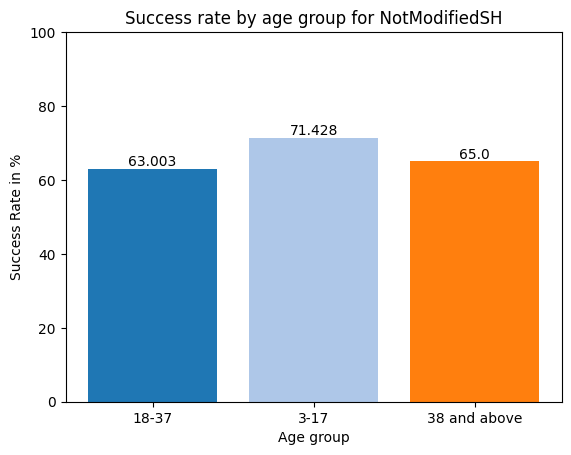

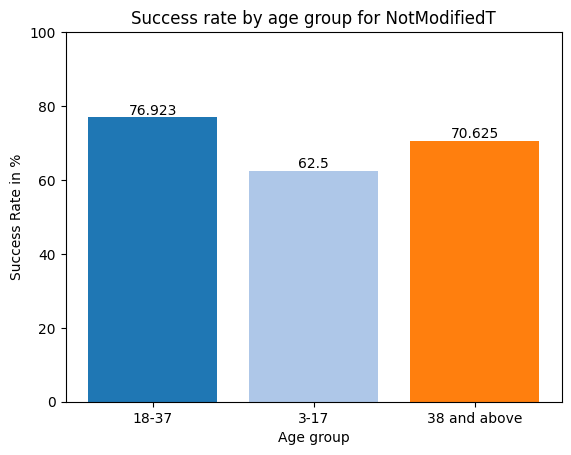

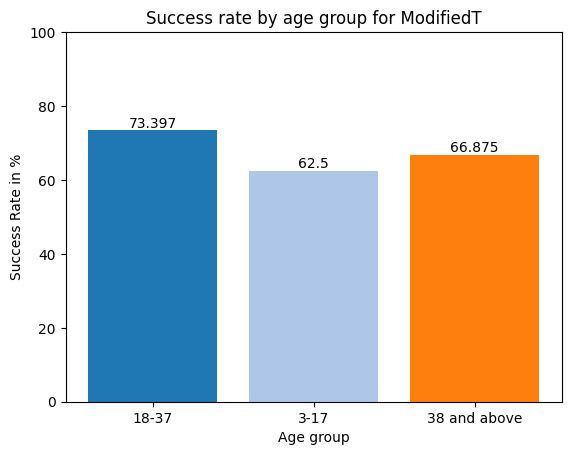

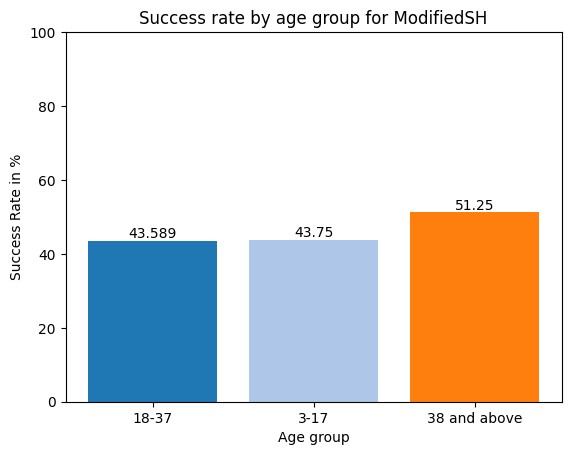

age1 vs age2 vs age3
Chi-square statistic: 0.6162031322384307
P-value: 0.7348406793027127
Degrees of freedom: 2
Expected frequencies table:
[[ 22.42622951 437.31147541 224.26229508]
 [ 39.57377049 771.68852459 395.73770492]]
The result is not significant. There is no significant association between the variables.

ANOVA results:
                 sum_sq      df         F    PR(>F)
C(Age)      1422.170166     2.0  3.334946  0.035826
Residual  402563.859843  1888.0       NaN       NaN

Tukey HSD test results:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2   4.5885 0.0421  0.1286 9.0484   True
     1      3   3.7065 0.1373 -0.8556 8.2686  False
     2      3   -0.882 0.4398 -2.5738 0.8099  False
---------------------------------------------------
If it's close to -1, it indicates a strong negative correlation (as one variable increases, the other tends to decrease). If

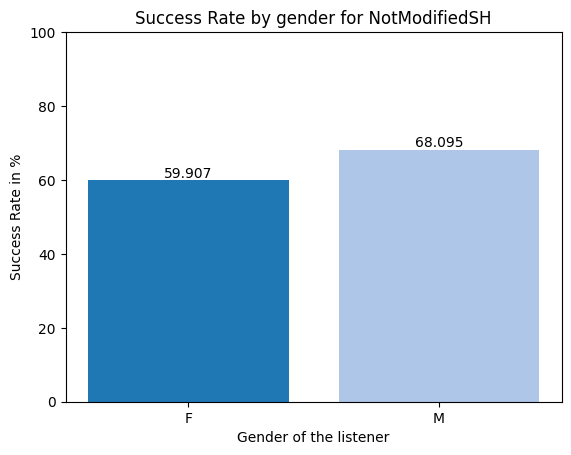

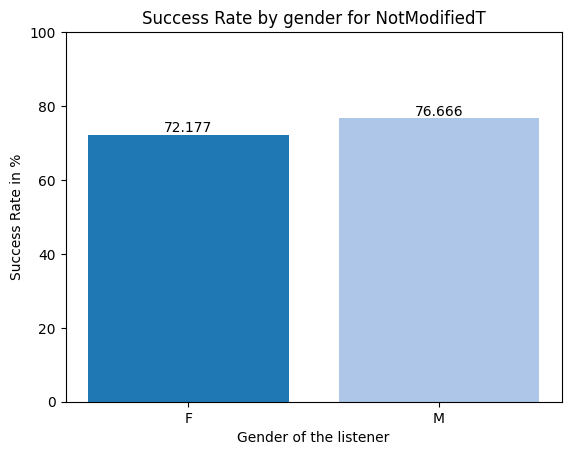

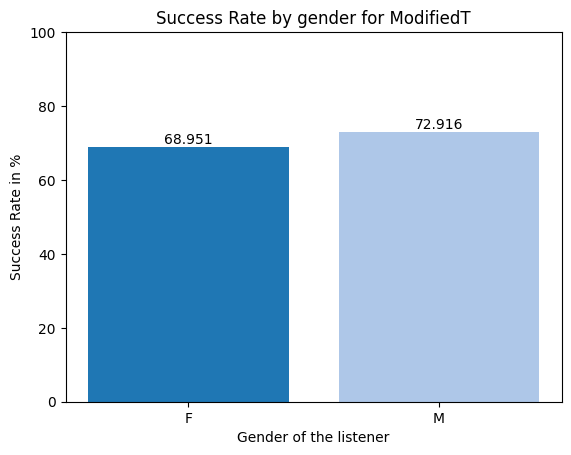

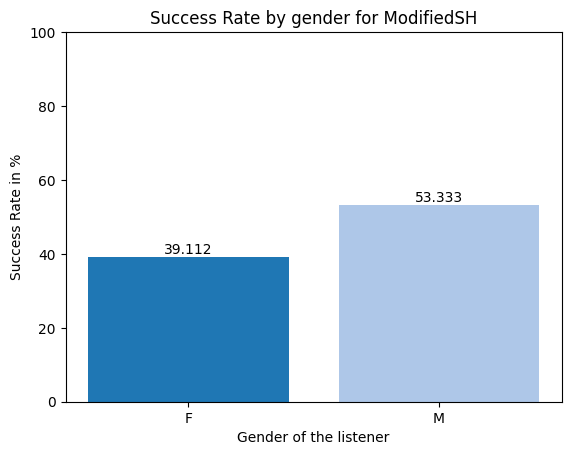

F vs M listeners
Chi-square statistic: 11.806878864922139
P-value: 0.0005901227789113742
Degrees of freedom: 1
Expected frequencies table:
[[347.60655738 336.39344262]
 [613.39344262 593.60655738]]
The result is significant. There is a significant association between the variables.

---- Performing Ttest ----
Reject the null hypothesis. There is a significant difference between the means.
t-statistic: 11.865738219429058
p-value: 2.2517543323766428e-31



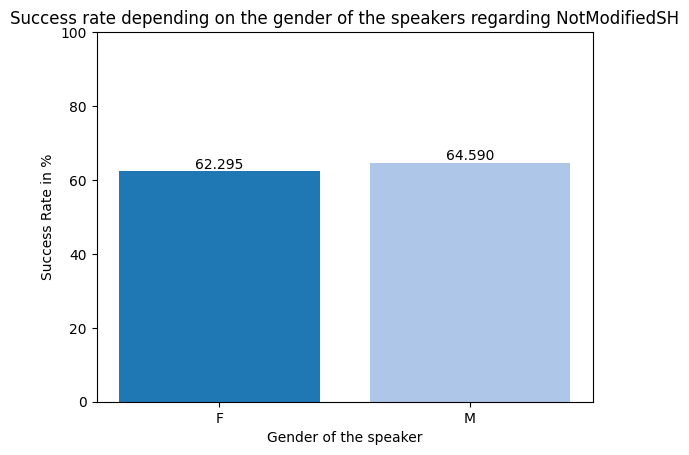

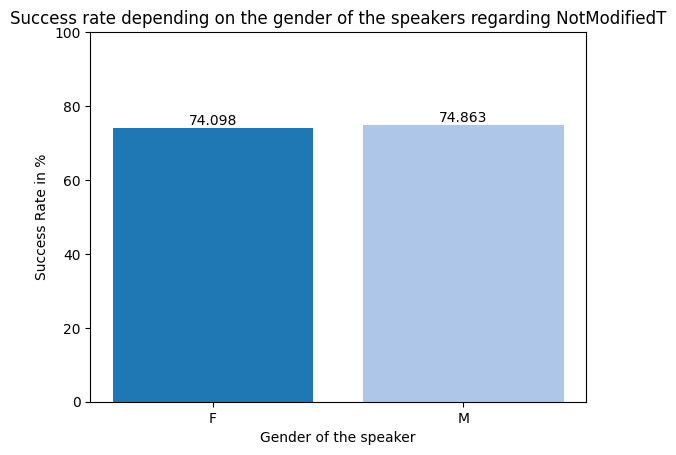

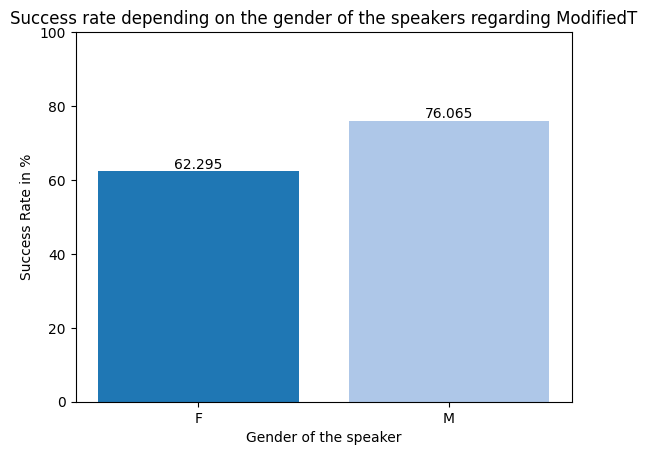

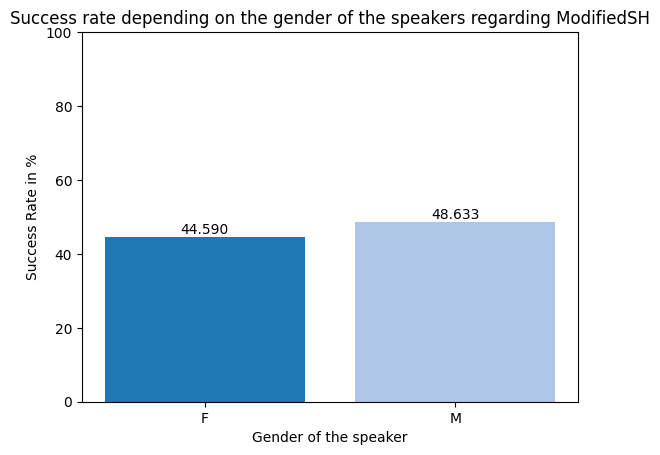

Chi-square statistic: 9.119067858049863
P-value: 0.0025295882396441584
Degrees of freedom: 1
Expected frequencies table:
[[330.96774194 353.03225806]
 [584.03225806 622.96774194]]
The result is significant. There is a significant association between the variables.

---- Performing Ttest ----
Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.
t-statistic: -2.111750940190587e-14
p-value: 0.9999999999999831



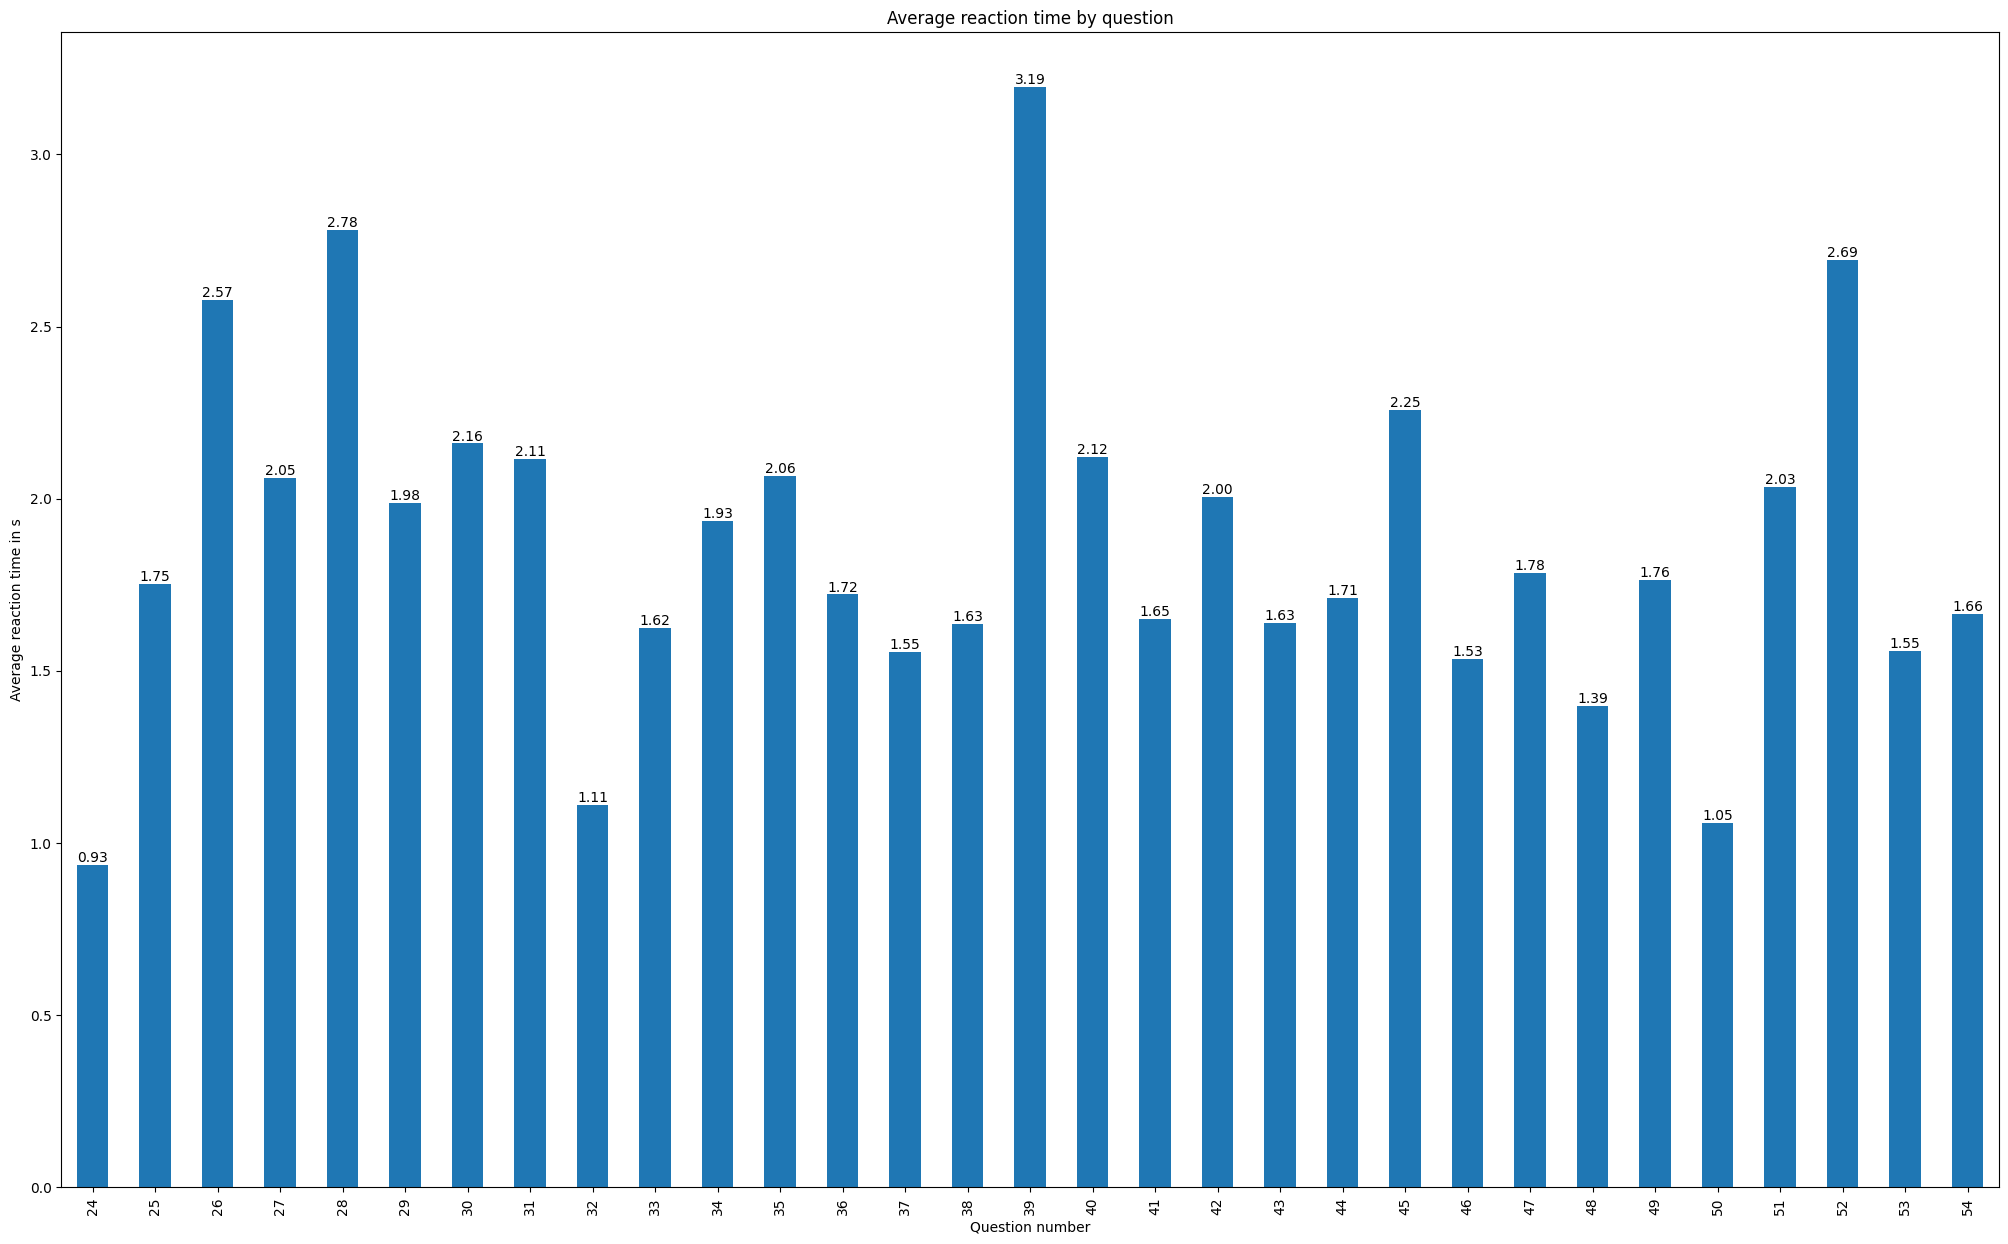

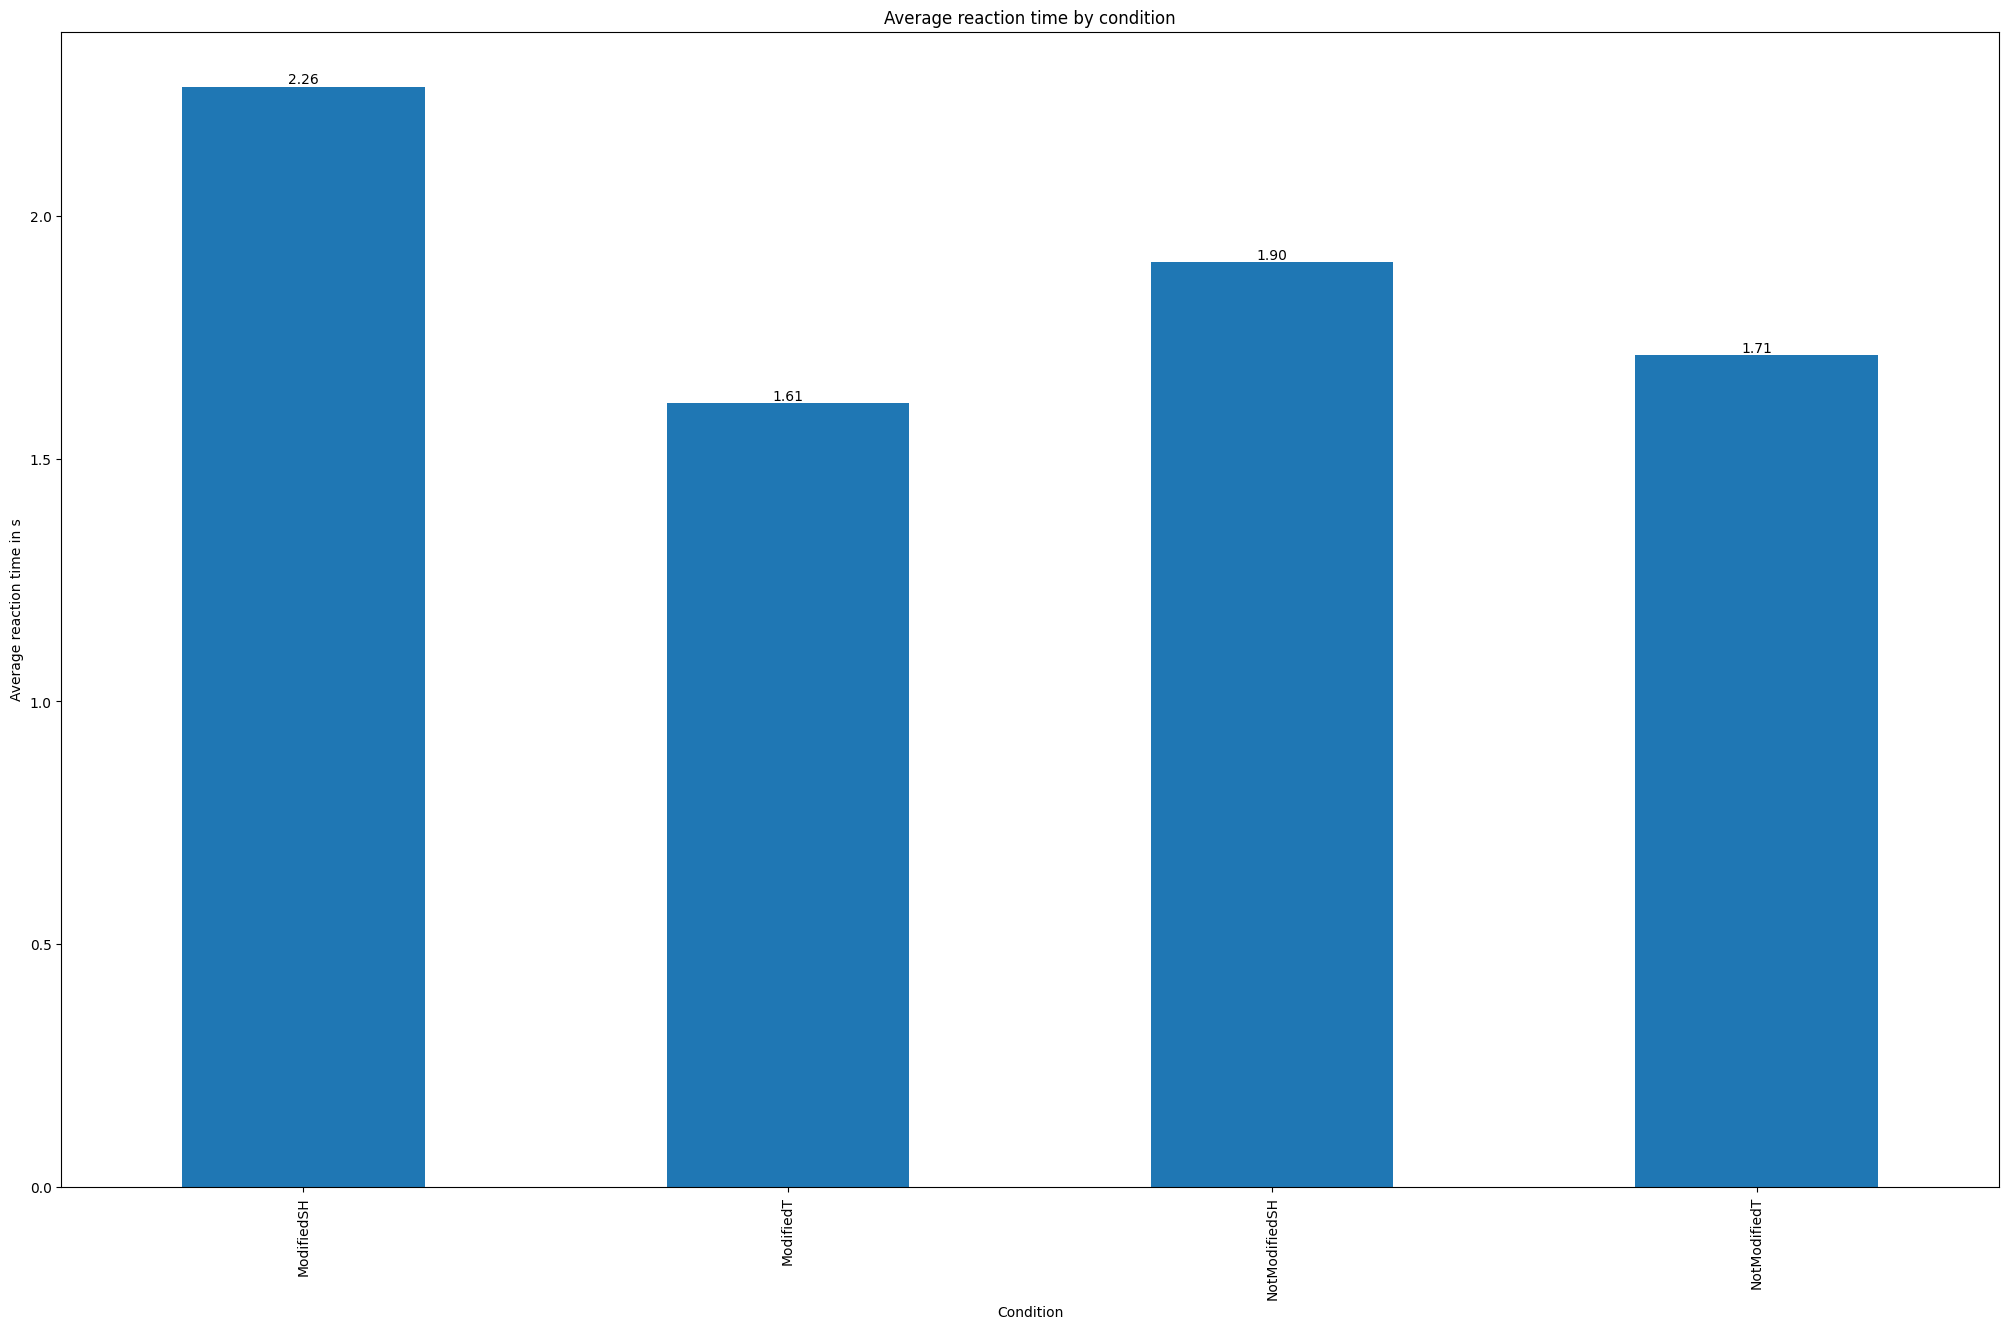

If it's close to -1, it indicates a strong negative correlation (as one variable increases, the other tends to decrease). If it's close to 0, it indicates no linear correlation between the variables.
Pearson correlation coefficient between Success and Reaction time: 0.02224361726975661
P-value: 0.33366516432094456

Correlation between frequency and Success: -2.520925115145102e-18
P-value: 1.0000000000000022

P-value: 0.02519765182733415
Correlation between frequency and Reaction time: -0.051473446310311116
---- Performing Ttest ----
Reject the null hypothesis. There is a significant difference between the means.
t-statistic: -21.820510317185196
p-value: 1.6157354860660576e-99



In [ ]:
# @title ALL PARTICIPANTS

# view beginning of the table
df_lex.head()

#-------------------------------By COUNTRY------------------------------------------------------------------------------------------------------------------------------------------------------
#go into list condition and take the value x
for x in condition:
    df = df_lex[df_lex['Condition'] == x]
    # plot_success_rate_by_country(df,x)
    plot_success_rate_by_parameter(df, x, 'Country_Categorized', 'Countries', 'Success Rate in %',  'Percentage of right answers regarding ')
#----------Chi2 impact of country on success
print('impact of country on success')
do_chi_square_test(df_lex['Success'], df_lex['Country_Categorized'])
print('')
#----------Chi2 impact of condition on success
print('impact of condition on success')
do_chi_square_test(df_lex['Success'], df_lex['Condition'])
print('')
#----------Anova impact of country on successrate
do_anova(df_lex, 'SuccessRateParticipant', 'Country_Categorized')
print('')
#----------Anova impact of country on successrate
do_anova(df_lex, 'SuccessRateCountry_NIandIreland', 'Country_Categorized')
print('')

#------------------------------By LEVEL OF IRISH---------------------------------------------------------------------------------------------------------------------------------------------------
for x in condition:
    df = df_lex[df_lex['Condition'] == x]
    plot_success_rate_by_parameter(df, x, 'Irish', 'Level of Irish', 'Success Rate in %',  'Success rate for ')
#---------Anova 1
do_anova(df_lex, 'SuccessRateParticipant', 'Irish')
#---------Anova 2
print('level of Irish yes vs no vs notions')
val1 = df_lex[(df_lex['Irish'] == 'Yes')]['SuccessRateParticipant']
val2 = df_lex[(df_lex['Irish'] == 'No')]['SuccessRateParticipant']
val3 = df_lex[(df_lex['Irish'] == 'Notions')]['SuccessRateParticipant']
do_anova_test([val1, val2, val3])
#---------Chi2
do_chi_square_test(df_lex['Success'], df_lex['Irish'])

#-----------------------------By AGE------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
for x in condition:
    df = df_lex[df_lex['Condition'] == x]
    plot_success_rate_by_parameter(df, x, 'Age_group', 'Age group', 'Success Rate in %',  'Success rate by age group for ')

print('age1 vs age2 vs age3')
#--------------------CHI2 age
do_chi_square_test(df_lex['Success'], df_lex['Age'])
print('')
#-------------------ANOVA and TUKEY HSD Age
do_anova(df_lex, 'SuccessRateParticipant', 'Age')

#--------------------Pearson correlation coefficient for Age of success
correlation = df_lex['SuccessRateParticipant'].corr(df_lex['Age'])
print("If it's close to -1, it indicates a strong negative correlation (as one variable increases, the other tends to decrease). If it's close to 0, it indicates no linear correlation between the variables.")
print("Pearson correlation coefficient between Success and Age:", correlation)
print("")
stats.pearsonr(df_lex['SuccessRateParticipant'], df_lex['Age'])

#---------------------------------By GENDER----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
for x in condition:
    df = df_lex[df_lex['Condition'] == x]
    plot_success_rate_by_parameter(df, x, 'Gender', 'Gender of the listener', 'Success Rate in %',  'Success Rate by gender for ')

#The chi-square test examines the association or independence between categorical variables (Success and Gender).
#The t-test compares the means of a numerical variable (SuccessRateCountry_Categorized) between two groups defined by a categorical variable (Gender)
print('F vs M listeners')
# ---------------------chi2 gender listener
do_chi_square_test(df_lex['Success'], df_lex['Gender'])
print('')
#--------------------ttest
val1 = df_lex[df_lex['Gender'] == 'M']['SuccessRateParticipant']
val2 = df_lex[df_lex['Gender'] == 'F']['SuccessRateParticipant']
do_ttest(val1, val2)

#---------------------------------By GENDER of the speaker--------------------------------------------------------------------------------------------------------------------------------------------------
for x in condition:
    df = df_lex[df_lex['Condition'] == x]
    plot_success_rate_by_parameter(df, x, 'Condition2', 'Gender of the speaker', 'Success Rate in %',  'Success rate depending on the gender of the speakers regarding ')

# ---------------------chi2 gender speaker
do_chi_square_test(df_lex['Success'], df_lex['Condition2'])
print('')
#--------------------ttest
val1 = df_lex[df_lex['Condition2'] == 'M']['SuccessRateParticipant']
val2 = df_lex[df_lex['Condition2'] == 'F']['SuccessRateParticipant']
do_ttest(val1, val2)

#------------Average reaction time in s By question---------------------------------------------------------------------------------------------------------------------------------------------------------
plot_bar_average_parameter(df_lex, 'ItemNb', 'Question number', 'Average reaction time in s', 'Average reaction time by question', 'Reaction time')

#------------Average reaction time in s By condition-----------------------------------------------------------------------------------------------------------------------------------
plot_bar_average_parameter(df_lex, 'Condition', 'Condition', 'Average reaction time in s', 'Average reaction time by condition', 'Reaction time')


# -----------------------------------------------------------------------Calculate Pearson correlation coefficient-----

#------------------------------------CORRELATION success and Reaction time
correlation_success_reaction = df_lex['SuccessRateParticipant'].corr(df_lex['Reaction time'])
print("If it's close to -1, it indicates a strong negative correlation (as one variable increases, the other tends to decrease). If it's close to 0, it indicates no linear correlation between the variables.")
print("Pearson correlation coefficient between Success and Reaction time:", correlation_success_reaction)
# Calculate Pearson correlation coefficient and p-value for Success and Reaction time
corr_coef_success_reaction, p_value_success_reaction = stats.pearsonr(df_lex['SuccessRateParticipant'], df_lex['Reaction time'])
print("P-value:", p_value_success_reaction)
print("")

#-----------------------------------CORRELATION Success and FREQUENCY OF WORDS
# Calculate correlation between frequency and Success
correlation_success_frequency = df_lex['Frequency'].apply(lambda x: x[0] if isinstance(x, list) else x).corr(df_lex['SuccessRateParticipant'])
# Calculate Pearson correlation coefficient and p-value for Success and Frequency
corr_coef_success_frequency, p_value_success_frequency = stats.pearsonr(df_lex['Frequency'], df_lex['SuccessRateParticipant'])
print("Correlation between frequency and Success:", correlation_success_frequency)
print("P-value:", p_value_success_frequency)
print("")
# -------------------------------- CORRELATION between frequency and Reaction time
correlation_reaction_time_frequency = df_lex['Frequency'].apply(lambda x: x[0] if isinstance(x, list) else x).corr(df_lex['Reaction time'])
# Calculate Pearson correlation coefficient and p-value for Frequency and Reaction time
corr_coef_reaction_time_frequency, p_value_reaction_time_frequency = stats.pearsonr(df_lex['Frequency'], df_lex['Reaction time'])
print("P-value:", p_value_reaction_time_frequency)
print("Correlation between frequency and Reaction time:", correlation_reaction_time_frequency)

#--------------------ttest
val1 = df_lex['Reaction time']
val2 = df_lex['Frequency']
do_ttest(val1, val2)


In [ ]:
# @title Logistic Regression

#Yes, you can use dataset[['Intercept', 'Age', 'Irish']] for X in logit_model.fit,
# as long as Intercept, Age, and Irish are appropriately formatted
# for logistic regression. This means Age should be numeric,
# and Irish should be a binary variable or appropriately encoded if it is categorical.

# Sample DataFrame
#data = {
#    'Age': [23, 45, 25, 35, 29, 42, 39, 31, 28, 34],
#    'Irish': ['yes', 'no', 'yes', 'no', 'yes', 'yes', 'no', 'no', 'yes', 'no'],
#    'Pass': [0, 1, 0, 1, 1, 0, 1, 0, 1, 0]
#}

# 'Age', 'Gender', 'Irish', 'Country' as predictors and 'Success' as target
predictors = ['Age', 'Irish']
target = 'Success'
do_logistic_regression(df_lex, predictors, target)

['Intercept', 'Age', 'Irish']


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [ ]:
# @title Irish VS Other

#check impact of country on success with a chi2 test
do_chi_square_test(df_lex['Success'], df_lex['Country_Categorized'])

print('')
print('Anova success rate irish vs other depending on the condition')
do_anova(df_lex, 'SuccessRateCountry_Categorized', 'Condition')

#---------------Ttests IRISH vs OTHERS

All_filtered_df_lex_mod_t = df_mod_T.loc[df_mod_T['Country_Categorized'].isin(['Ireland', 'Other English speaking countries'])]
All_filtered_df_lex_mod_sh = df_mod_SH.loc[df_mod_SH['Country_Categorized'].isin(['Ireland', 'Other English speaking countries'])]
All_filtered_df_lex_not_mod_t = df_not_mod_T.loc[df_not_mod_T['Country_Categorized'].isin(['Ireland', 'Other English speaking countries'])]
All_filtered_df_lex_not_mod_sh = df_not_mod_SH.loc[df_not_mod_SH['Country_Categorized'].isin(['Ireland', 'Other English speaking countries'])]

print('check if there is a significant difference btw success when Modified T and success when ModifiedSH (other and Irish)')
val1 = df_lex[df_lex['Condition'] == 'ModifiedT']['SuccessRateCountry_Categorized']
val2 = df_lex[df_lex['Condition'] == 'ModifiedSH']['SuccessRateCountry_Categorized']
do_ttest(val1, val2)

print('check if there is a significant difference btw success when not Modified T and success when not ModifiedSH (other and Irish)')
val1 = df_lex[df_lex['Condition'] == 'NotModifiedT']['SuccessRateCountry_Categorized']
val2 = df_lex[df_lex['Condition'] == 'NotModifiedSH']['SuccessRateCountry_Categorized']
do_ttest(val1, val2)

#----create new column successrate in this data frame
All_filtered_df_lex_mod_t = calculate_success_rate_by(All_filtered_df_lex_mod_t, 'Participant')
All_filtered_df_lex_mod_sh = calculate_success_rate_by(All_filtered_df_lex_mod_sh, 'Participant')
#----ttest mod t of irish vs mod t of other
All_filtered_df_lex_mod_t.to_csv('All_filtered_df_lex_mod_t.csv', index=False)
#----success rate of ireland for mod t vs success rate of other for mod T
print('ModifiedT')
val1 = All_filtered_df_lex_mod_t[(All_filtered_df_lex_mod_t['Country_Categorized'] == 'Ireland')]['SuccessRateParticipant']
val2 = All_filtered_df_lex_mod_t[(All_filtered_df_lex_mod_t['Country_Categorized'] == 'Other English speaking countries')]['SuccessRateParticipant']
do_ttest(val1, val2)

#----success rate of ireland for mod sh vs success rate of other for mod sh
print('Modified SH')
val1 = All_filtered_df_lex_mod_t[(All_filtered_df_lex_mod_t['Country_Categorized'] == 'Ireland')]['SuccessRateParticipant']
val2 = All_filtered_df_lex_mod_sh[(All_filtered_df_lex_mod_sh['Country_Categorized'] == 'Other English speaking countries')]['SuccessRateParticipant']
do_ttest(val1, val2)

Chi-square statistic: 12.921659104190363
P-value: 0.0003248018444428839
Degrees of freedom: 1
Expected frequencies table:
[[257.90163934 426.09836066]
 [455.09836066 751.90163934]]
The result is significant. There is a significant association between the variables.

Anova success rate irish vs other depending on the condition
ANOVA results:
                    sum_sq      df             F  PR(>F)
C(Condition)  3.060496e-25     3.0  6.291337e-27     1.0
Residual      3.059845e+04  1887.0           NaN     NaN
ANOVA is not significant, so Tukey HSD test is not performed.
check if there is a significant difference btw success when Modified T and success when ModifiedSH (other and Irish)
---- Performing Ttest ----
Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.
t-statistic: 0.0
p-value: 1.0

check if there is a significant difference btw success when not Modified T and success when not ModifiedSH (other and Irish)
---- Performing Ttest

[77.17391304347827, 48.369565217391305, 62.732919254658384, 86.95652173913044]


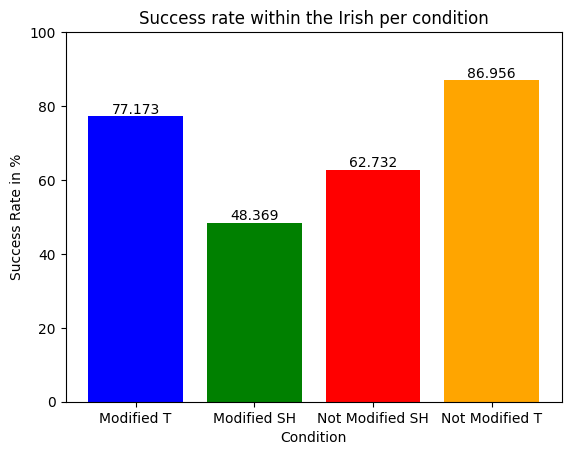

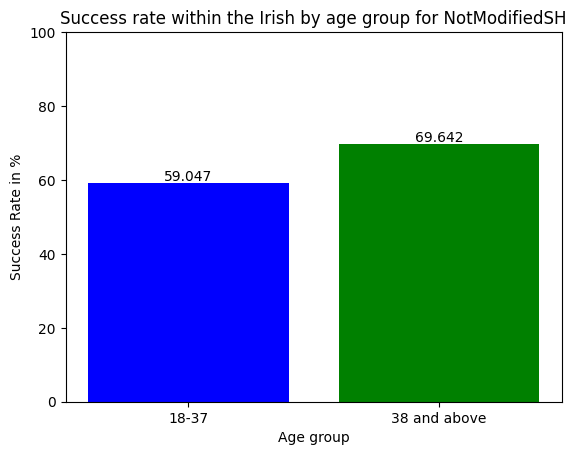

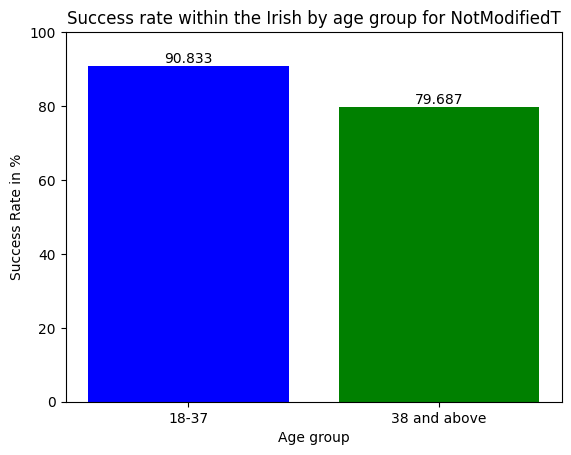

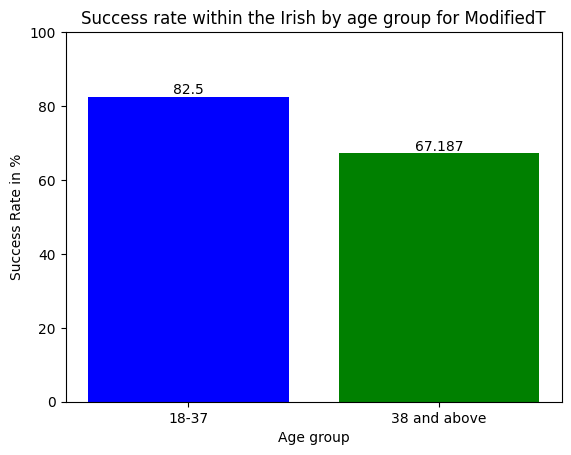

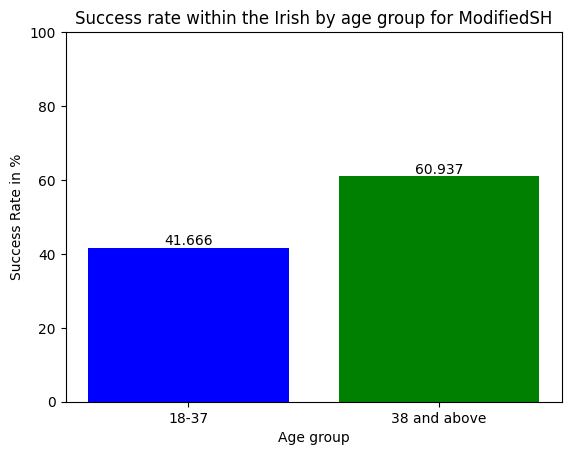

age2 vs age3
---- Performing Ttest ----
Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.
t-statistic: -0.489302054549827
p-value: 0.6247787782650203

Chi-square statistic: 0.003948105586825121
P-value: 0.9498987290907022
Degrees of freedom: 1
Expected frequencies table:
[[144.13043478  76.86956522]
 [320.86956522 171.13043478]]
The result is not significant. There is no significant association between the variables.


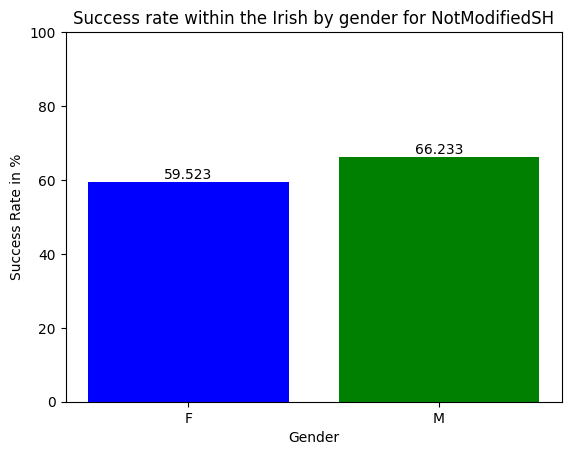

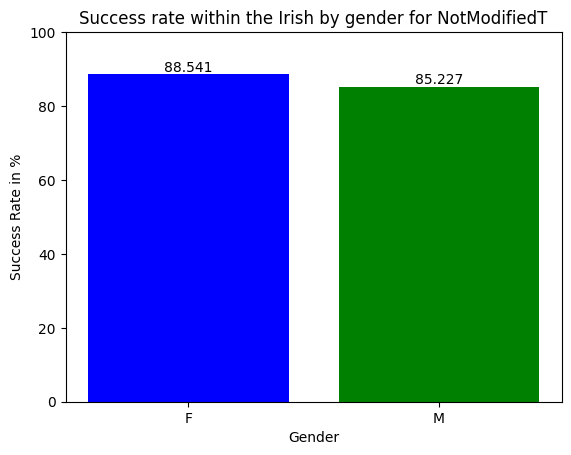

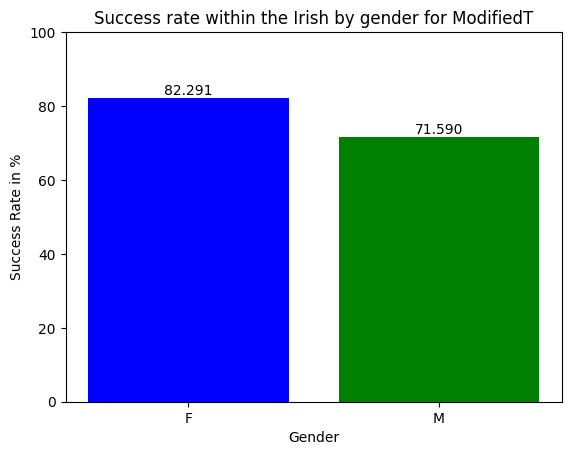

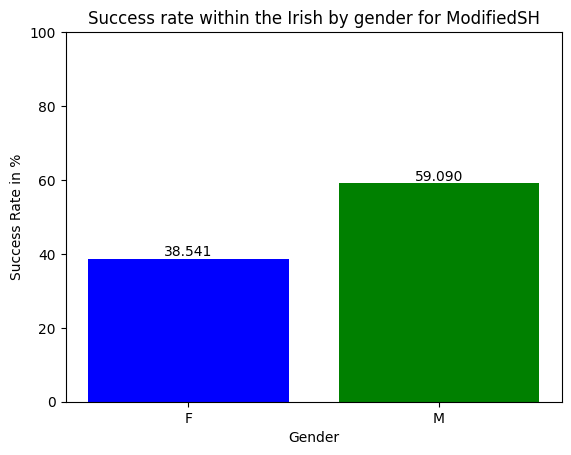

F vs M
---- Performing Ttest ----
Reject the null hypothesis. There is a significant difference between the means.
t-statistic: -3.0782379942987683
p-value: 0.0021623477441232598

Chi-square statistic: 0.7094046531143023
P-value: 0.39964152349540105
Degrees of freedom: 1
Expected frequencies table:
[[115.30434783 105.69565217]
 [256.69565217 235.30434783]]
The result is not significant. There is no significant association between the variables.


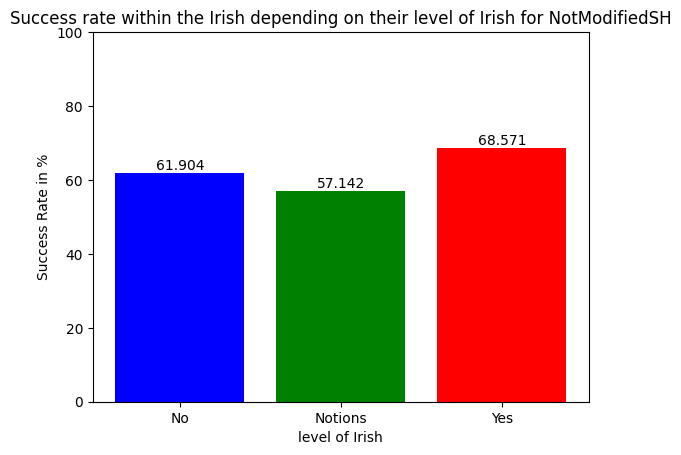

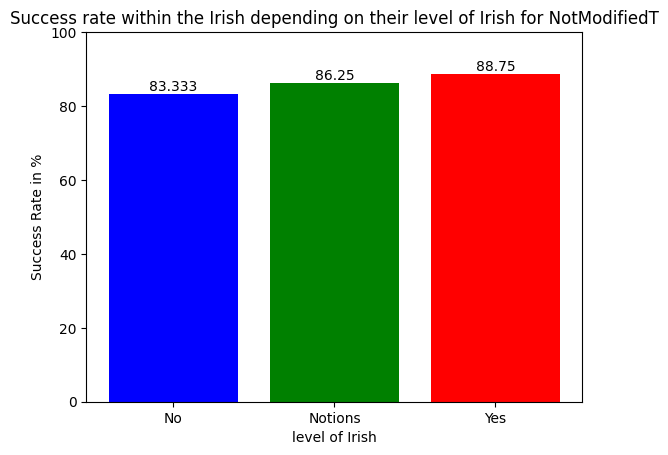

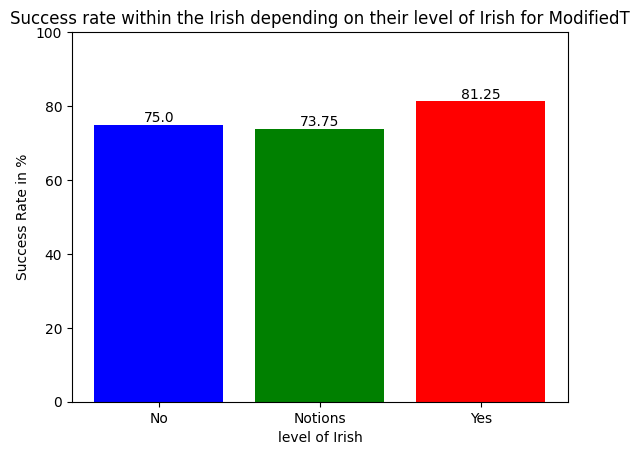

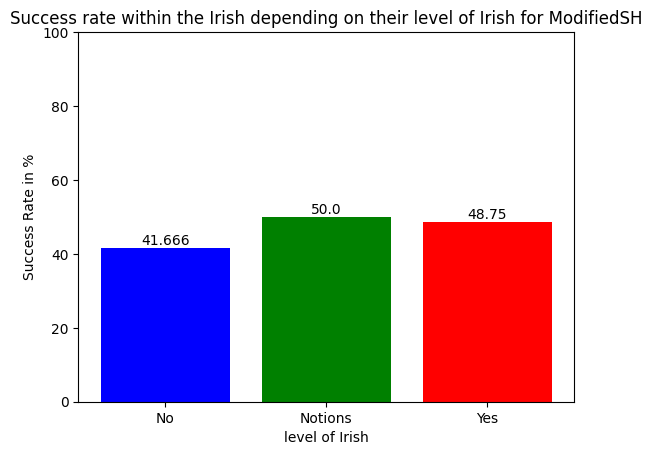

Chi-square statistic: 2.2791361635335816
P-value: 0.31995718731910544
Degrees of freedom: 2
Expected frequencies table:
[[ 28.82608696  96.08695652  96.08695652]
 [ 64.17391304 213.91304348 213.91304348]]
The result is not significant. There is no significant association between the variables.
ANOVA results:
                 sum_sq     df          F    PR(>F)
C(Irish)    4881.085591    2.0  12.962679  0.000003
Residual  133674.938800  710.0        NaN       NaN

Tukey HSD test results:


<ipython-input-3-2c56f679c91e>:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[param1] = pd.to_numeric(dataset[param1], errors='coerce')


 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
     No Notions    1.506 0.6225 -2.3041  5.3161  False
     No     Yes    6.348 0.0003  2.5379 10.1581   True
Notions     Yes    4.842    0.0  2.2535  7.4305   True
------------------------------------------------------


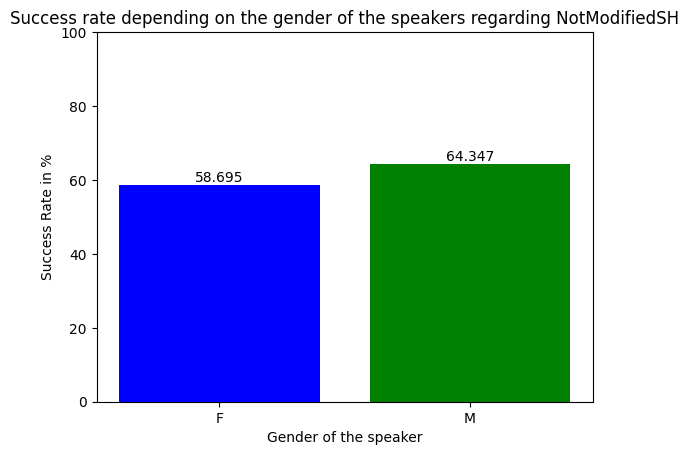

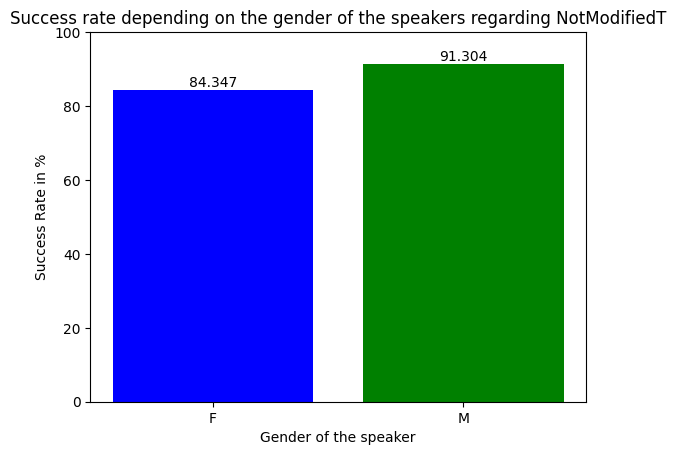

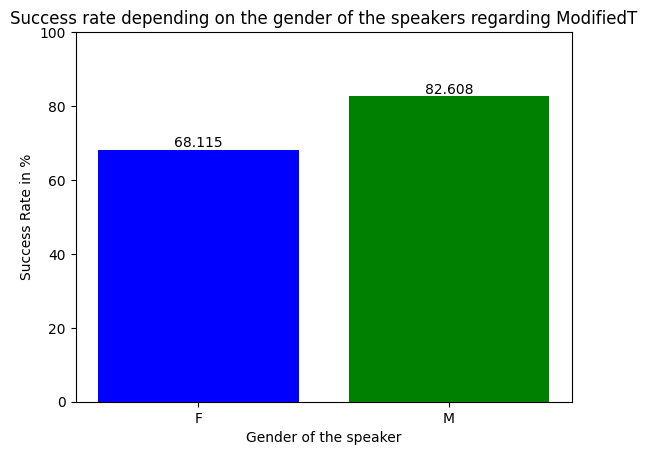

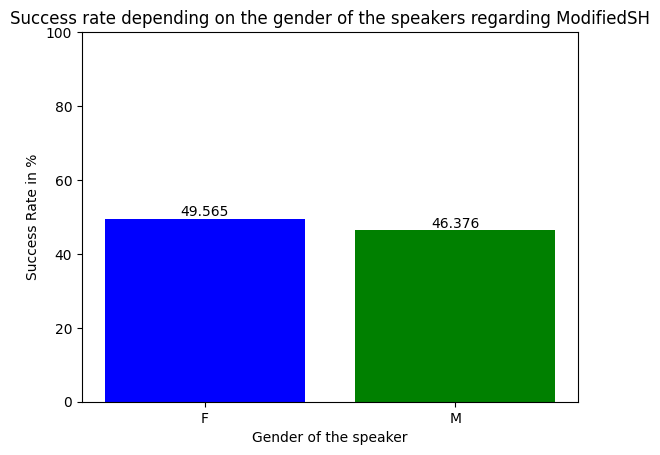

F vs M of the speaker
---- Performing Ttest ----
Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.
t-statistic: 0.0
p-value: 1.0

Chi-square statistic: 2.4019850891028693
P-value: 0.12118139033274934
Degrees of freedom: 1
Expected frequencies table:
[[106.93548387 114.06451613]
 [238.06451613 253.93548387]]
The result is not significant. There is no significant association between the variables.


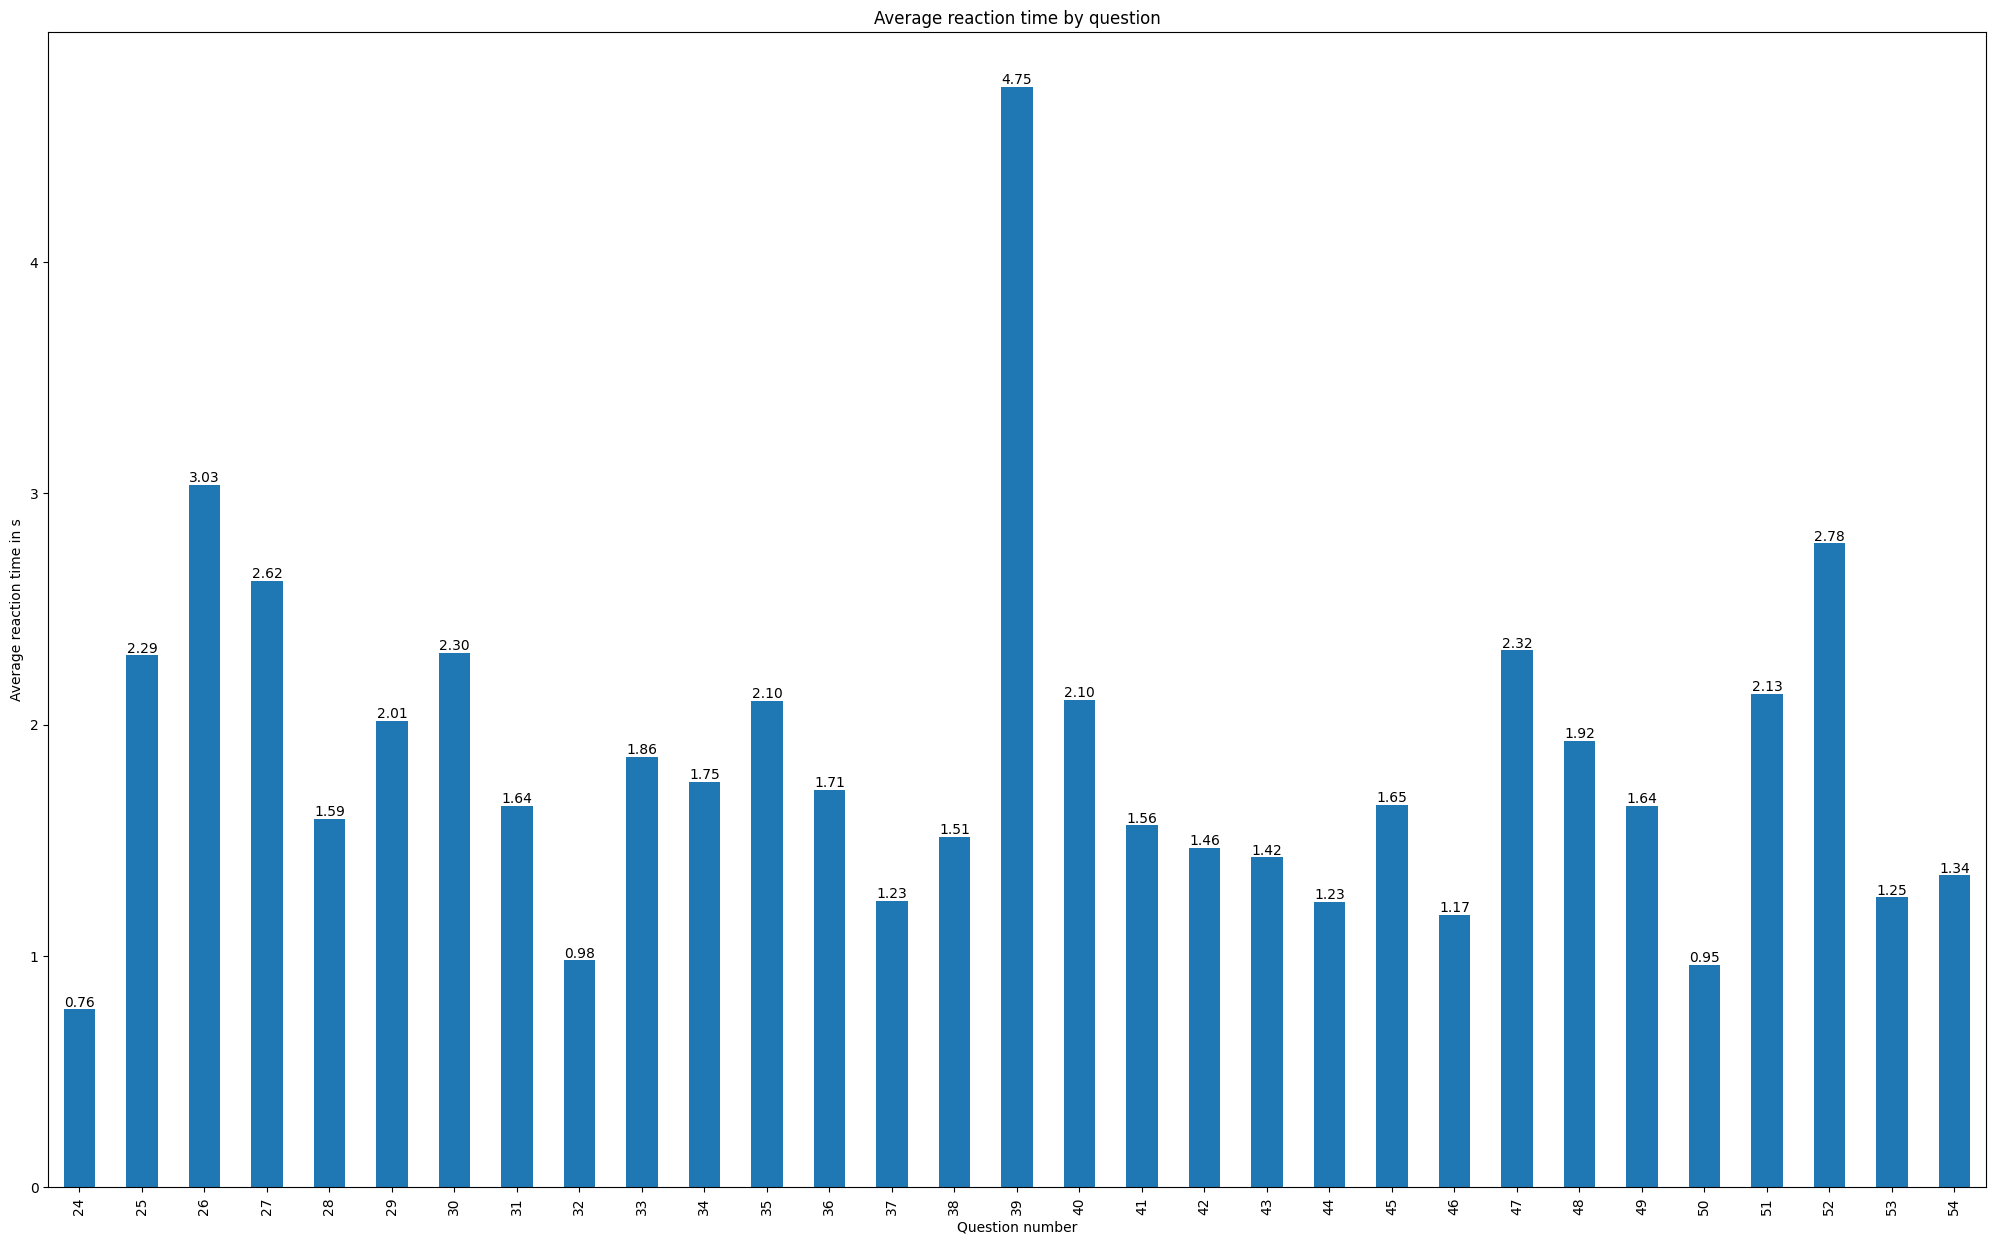

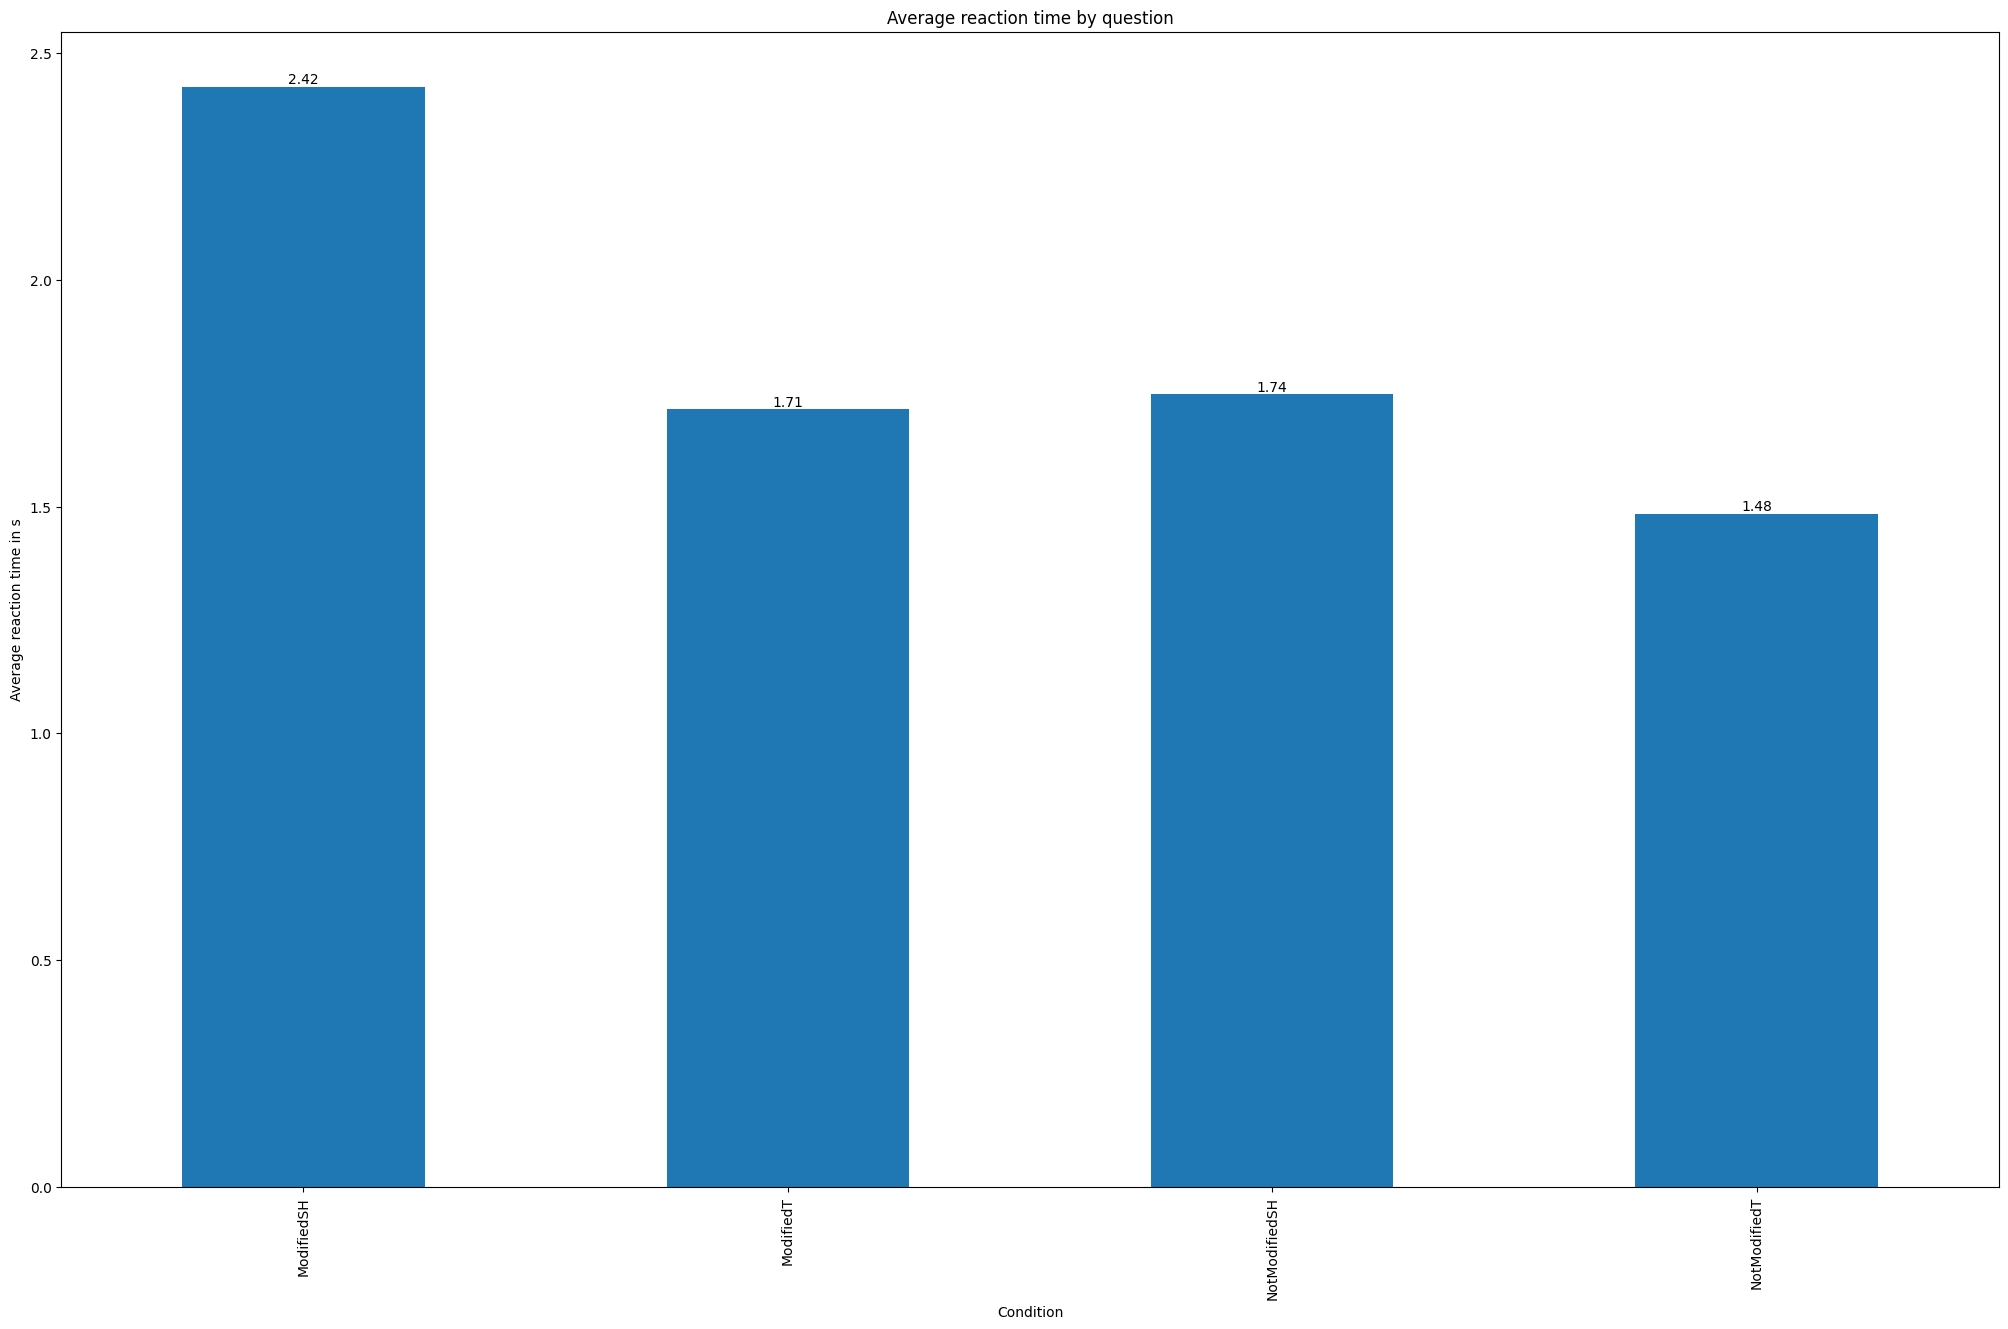

Modified T vs ModifiedSH impact on success of the Irish
---- Performing Ttest ----
Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.
t-statistic: 0.0
p-value: 1.0

Not Modified T vs Not ModifiedSH impact on success of the Irish
---- Performing Ttest ----
Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.
t-statistic: -9.418940903860173e-15
p-value: 0.9999999999999925

If it's close to -1, it indicates a strong negative correlation (as one variable increases, the other tends to decrease). If it's close to 0, it indicates no linear correlation between the variables.
Pearson correlation coefficient between Success and Reaction time: 0.07755640932930576
P-value: 0.038414759335443034

Correlation between frequency and Success: 1.2133066479226096e-18
P-value: 1.0000000000000007

P-value: 0.13558469626070466
Correlation between frequency and Reaction time: -0.05594657542445645


In [ ]:
# @title WITHIN THE IRISH

#-------Per CONDITION
# Categorize 'Country' into 'Ireland'
filtered_df_lex_mod_t = df_mod_T.loc[df_mod_T['Country'] == 'Ireland']
filtered_df_lex_mod_sh = df_mod_SH.loc[df_mod_SH['Country'] == 'Ireland']
filtered_df_lex_not_mod_t = df_not_mod_T.loc[df_not_mod_T['Country'] == 'Ireland']
filtered_df_lex_not_mod_sh = df_not_mod_SH.loc[df_not_mod_SH['Country'] == 'Ireland']

# Calculate success rate for each condition in Ireland
success_ModifiedT = 100 * filtered_df_lex_mod_t[filtered_df_lex_mod_t['Success'] == 1].shape[0] / filtered_df_lex_mod_t.shape[0]
success_ModifiedSH = 100 * filtered_df_lex_mod_sh[filtered_df_lex_mod_sh['Success'] == 1].shape[0] / filtered_df_lex_mod_sh.shape[0]
success_NotModifiedT = 100 * filtered_df_lex_not_mod_t[filtered_df_lex_not_mod_t['Success'] == 1].shape[0] / filtered_df_lex_not_mod_t.shape[0]
success_NotModifiedSH = 100 * filtered_df_lex_not_mod_sh[filtered_df_lex_not_mod_sh['Success'] == 1].shape[0] / filtered_df_lex_not_mod_sh.shape[0]

headers = ['Modified T', 'Modified SH', 'Not Modified SH','Not Modified T']
datas = [success_ModifiedT, success_ModifiedSH, success_NotModifiedSH, success_NotModifiedT]
print(datas)

plot_2d_array(headers, datas, 'Condition', 'Success Rate in %', 'Success rate within the Irish per condition', colours=plot_colours80s)

#---------------------------------------by AGE GROUP------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
filter_withinIrish = df_lex.loc[df_lex['Country'] == 'Ireland']
for x in condition:
    df = filter_withinIrish[filter_withinIrish['Condition'] == x]
    plot_success_rate_by_parameter(df, x, 'Age_group', 'Age group', 'Success Rate in %',  'Success rate within the Irish by age group for ', colours=plot_colours80s)

print('age2 vs age3')
val1 = filter_withinIrish[filter_withinIrish['Age'] == 2]['SuccessRateParticipant']
val2 = filter_withinIrish[filter_withinIrish['Age'] == 3]['SuccessRateParticipant']
do_ttest(val1, val2)

# ---------------CHI2 Age
do_chi_square_test(filter_withinIrish['Success'], filter_withinIrish['Age'])

#-------------------------------------by GENDER------------------------------------------------------------------------------------------------------------------------------------------------------------------------
for x in condition:
    df = filter_withinIrish[filter_withinIrish['Condition'] == x]
    plot_success_rate_by_parameter(df, x, 'Gender', 'Gender', 'Success Rate in %',  'Success rate within the Irish by gender for ', colours=plot_colours80s)

#--------------ttest
print('F vs M')
val1 = filter_withinIrish[filter_withinIrish['Gender'] == 'F']['SuccessRateParticipant']
val2 = filter_withinIrish[filter_withinIrish['Gender'] == 'M']['SuccessRateParticipant']
do_ttest(val1, val2)

# ---------------chi2 gender
do_chi_square_test(filter_withinIrish['Success'], filter_withinIrish['Gender'])

#-------------------------------------by LEVEL OF IRISH------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
for x in condition:
    df = filter_withinIrish[filter_withinIrish['Condition'] == x]
    plot_success_rate_by_parameter(df, x, 'Irish', 'level of Irish', 'Success Rate in %',  'Success rate within the Irish depending on their level of Irish for ', colours=plot_colours80s)

# ---------------CHi2 Irish
do_chi_square_test(filter_withinIrish['Success'], filter_withinIrish['Irish'])

#----------------------------anova and TUKEY HSD irish
do_anova(filter_withinIrish, 'SuccessRateParticipant', 'Irish')

#----------------------------------by GENDER of the speaker-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
for x in condition:
    df = filter_withinIrish[filter_withinIrish['Condition'] == x]
    plot_success_rate_by_parameter(df, x, 'Condition2', 'Gender of the speaker', 'Success Rate in %',  'Success rate depending on the gender of the speakers regarding ', colours=plot_colours80s)
#-------------ttest
print('F vs M of the speaker')
val1 = filter_withinIrish[filter_withinIrish['Condition2'] == 'F']['SuccessRateParticipant']
val2 = filter_withinIrish[filter_withinIrish['Condition2'] == 'M']['SuccessRateParticipant']
do_ttest(val1, val2)
# ------------chi2 Gender of the Speaker
do_chi_square_test(filter_withinIrish['Success'], filter_withinIrish['Condition2'])

#-----------------------------Average REACTION TIME in s By ItemNb------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
plot_bar_average_parameter(filter_withinIrish, 'ItemNb', 'Question number', 'Average reaction time in s', 'Average reaction time by question', 'Reaction time')

#-----------------------------Average REACTION TIME  s By condition------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
plot_bar_average_parameter(filter_withinIrish, 'Condition', 'Condition', 'Average reaction time in s', 'Average reaction time by question', 'Reaction time')

#we want to check if there is a significant difference between the success rate of the Irish when slit /t/ was modified and when SH was modified. Same with non modified sounds
#-----------TTEST on 'Modified SH vs Modified T' ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
print('Modified T vs ModifiedSH impact on success of the Irish')
val1 = filter_withinIrish[filter_withinIrish['Condition'] == 'ModifiedT']['SuccessRateParticipant']
val2 = filter_withinIrish[filter_withinIrish['Condition'] == 'ModifiedSH']['SuccessRateParticipant']
do_ttest(val1, val2)
#-----------TTEST on 'Not Modified SH vs Not Modified T' -----------------------------------------------------------------------
print('Not Modified T vs Not ModifiedSH impact on success of the Irish')
val1 = filter_withinIrish[filter_withinIrish['Condition'] == 'NotModifiedT']['SuccessRateParticipant']
val2 = filter_withinIrish[filter_withinIrish['Condition'] == 'NotModifiedSH']['SuccessRateParticipant']
do_ttest(val1, val2)

# -----------------------------------------------------------------------Calculate Pearson correlation coefficient-----

#------------------------------------CORRELATION success and Reaction time
correlation_success_reaction_irish = filter_withinIrish['SuccessRateParticipant'].corr(filter_withinIrish['Reaction time'])
print("If it's close to -1, it indicates a strong negative correlation (as one variable increases, the other tends to decrease). If it's close to 0, it indicates no linear correlation between the variables.")
print("Pearson correlation coefficient between Success and Reaction time:", correlation_success_reaction_irish)
# Calculate Pearson correlation coefficient and p-value for Success and Reaction time
corr_coef_success_reaction_irish, p_value_success_reaction_irish = stats.pearsonr(filter_withinIrish['SuccessRateParticipant'], filter_withinIrish['Reaction time'])
print("P-value:", p_value_success_reaction_irish)
print("")

#-----------------------------------CORRELATION Success and FREQUENCY OF WORDS
# Calculate correlation between frequency and Success
correlation_success_frequency_irish = filter_withinIrish['Frequency'].apply(lambda x: x[0] if isinstance(x, list) else x).corr(filter_withinIrish['SuccessRateParticipant'])
# Calculate Pearson correlation coefficient and p-value for Success and Frequency
corr_coef_success_frequency_irish, p_value_success_frequency_irish = stats.pearsonr(filter_withinIrish['Frequency'], filter_withinIrish['SuccessRateParticipant'])
print("Correlation between frequency and Success:", correlation_success_frequency_irish)
print("P-value:", p_value_success_frequency_irish)
print("")

# -------------------------------- CORRELATION between frequency and Reaction time
correlation_reaction_time_frequency_irish = filter_withinIrish['Frequency'].apply(lambda x: x[0] if isinstance(x, list) else x).corr(filter_withinIrish['Reaction time'])
# Calculate Pearson correlation coefficient and p-value for Frequency and Reaction time
corr_coef_reaction_time_frequency_irish, p_value_reaction_time_frequency_irish = stats.pearsonr(filter_withinIrish['Frequency'], filter_withinIrish['Reaction time'])
print("P-value:", p_value_reaction_time_frequency_irish)
print("Correlation between frequency and Reaction time:", correlation_reaction_time_frequency_irish)

     Participant ItemNb ExpectedKey Condition2      Condition  \
11          3193     35           e          M  NotModifiedSH   
21          3193     45           e          F  NotModifiedSH   
26          3193     50           e          M  NotModifiedSH   
27          3193     51           e          M  NotModifiedSH   
28          3193     52           e          M  NotModifiedSH   
...          ...    ...         ...        ...            ...   
1886     William     50           e          M  NotModifiedSH   
1887     William     51           e          M  NotModifiedSH   
1888     William     52           e          M  NotModifiedSH   
1889     William     53           e          M  NotModifiedSH   
1890     William     54           e          F  NotModifiedSH   

     key_resp_question3.keys  Reaction time Gender  Age  Country    Irish  \
11                         e       1.733300      F    3  Ireland      Yes   
21                         e       0.811900      F    3  Ireland 

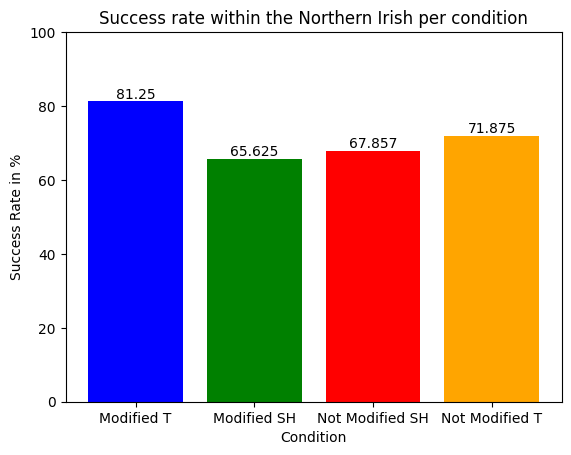

[77.17391304347827, 48.369565217391305, 62.732919254658384, 86.95652173913044]


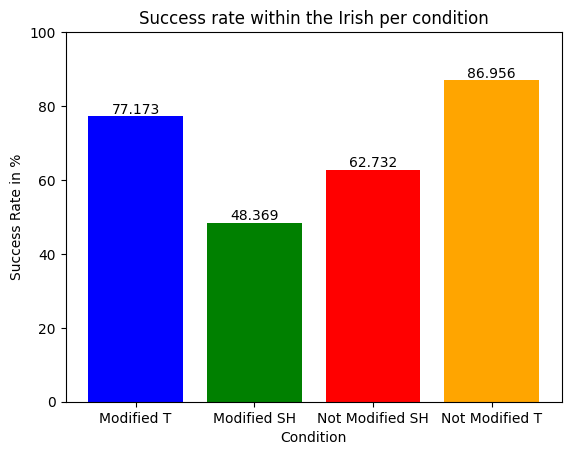

[77.17391304347827, 81.25, 48.369565217391305, 65.625, 62.732919254658384, 67.85714285714286, 86.95652173913044, 71.875]


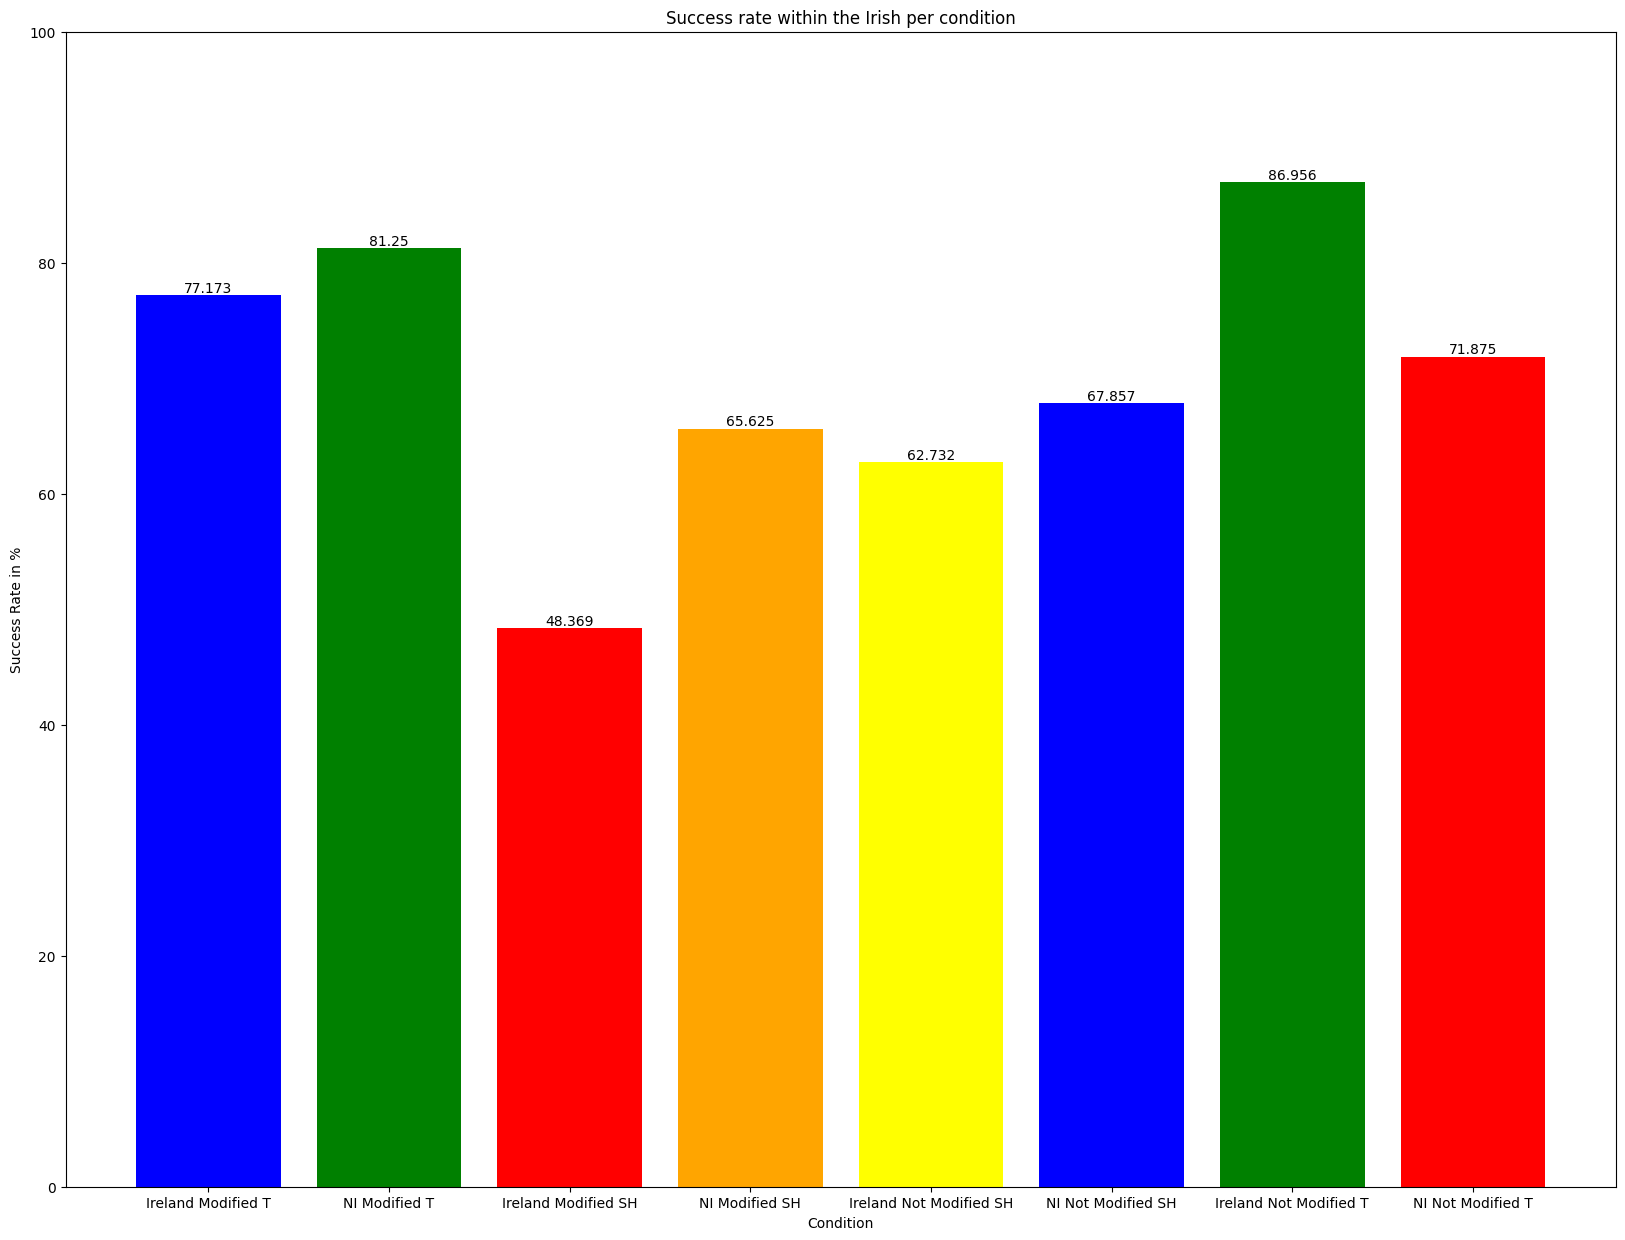


Calculating success rate for Participant

Success rate for 3193 is 62.5%
Success rate for 9212 is 87.5%
Success rate for 66543 is 50.0%
Success rate for 97863 is 75.0%
Success rate for 144849 is 100.0%
Success rate for 256908 is 87.5%
Success rate for 290430 is 75.0%
Success rate for 316470 is 75.0%
Success rate for 646029 is 100.0%
Success rate for 829249 is 62.5%
Success rate for 834521 is 100.0%
Success rate for 864646 is 100.0%
Success rate for 867341 is 87.5%
Success rate for 879868 is 62.5%
Success rate for 963806 is 100.0%
Success rate for Adrien is 87.5%
Success rate for Ali is 87.5%
Success rate for Bertia is 75.0%
Success rate for Cliodhna is 75.0%
Success rate for Colin is 50.0%
Success rate for Conor is 87.5%
Success rate for Liam is 50.0%
Success rate for Maurice is 100.0%
Success rate for Pat is 50.0%
Success rate for Paul is 62.5%
Success rate for Saoirse is 100.0%
Success rate for William is 50.0%

Calculating success rate for Participant

Success rate for 3193 is 62.5

<ipython-input-3-42dc9ffccb48>:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['SuccessRate' + column] = None
<ipython-input-3-42dc9ffccb48>:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['SuccessRate' + column] = None


Success rate for Maurice is 100.0%
Success rate for Pat is 50.0%
Success rate for Paul is 12.5%
Success rate for Saoirse is 62.5%
Success rate for William is 75.0%

Calculating success rate for Participant

Success rate for 3193 is 62.5%
Success rate for 9212 is 87.5%
Success rate for 66543 is 75.0%
Success rate for 97863 is 87.5%
Success rate for 144849 is 100.0%
Success rate for 256908 is 100.0%
Success rate for 290430 is 75.0%
Success rate for 316470 is 87.5%
Success rate for 646029 is 100.0%
Success rate for 829249 is 62.5%
Success rate for 834521 is 100.0%
Success rate for 864646 is 100.0%
Success rate for 867341 is 87.5%
Success rate for 879868 is 87.5%
Success rate for 963806 is 87.5%
Success rate for Adrien is 50.0%
Success rate for Ali is 100.0%
Success rate for Bertia is 87.5%
Success rate for Cliodhna is 87.5%
Success rate for Colin is 87.5%
Success rate for Conor is 87.5%
Success rate for Liam is 87.5%
Success rate for Maurice is 100.0%
Success rate for Pat is 62.5%
Success

<ipython-input-3-42dc9ffccb48>:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['SuccessRate' + column] = None
<ipython-input-3-42dc9ffccb48>:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['SuccessRate' + column] = None


Success rate for Cliodhna is 71.43%
Success rate for Colin is 57.14%
Success rate for Conor is 71.43%
Success rate for Liam is 42.86%
Success rate for Maurice is 100.0%
Success rate for Pat is 71.43%
Success rate for Paul is 42.86%
Success rate for Saoirse is 85.71%
Success rate for William is 42.86%
ModifiedT
---- Performing Ttest ----
Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.
t-statistic: -1.1734953673071633
p-value: 0.24190162983212835

Modified SH
---- Performing Ttest ----
Reject the null hypothesis. There is a significant difference between the means.
t-statistic: -3.6316134776392057
p-value: 0.00035251311088256614

Not ModifiedT
---- Performing Ttest ----
Reject the null hypothesis. There is a significant difference between the means.
t-statistic: 5.977618131551196
p-value: 9.368608426203739e-09

Not Modified SH
---- Performing Ttest ----
Fail to reject the null hypothesis. There is not enough evidence to conclude a si

In [ ]:
# @title Ireland VS NI

# Filter the DataFrame to include participants from Ireland and Northern Ireland
filter_NIandIrish = df_lex[df_lex['Country'].isin(['Ireland', 'Northern Ireland'])]

#-------Per CONDITION
# Categorise 'Country' into ('Ireland', 'Northern Ireland')
filtered_df_lex_mod_t = df_mod_T.loc[df_mod_T['Country'].isin(['Ireland', 'Northern Ireland'])]
filtered_df_lex_mod_sh = df_mod_SH.loc[df_mod_SH['Country'].isin(['Ireland', 'Northern Ireland'])]
filtered_df_lex_not_mod_t = df_not_mod_T.loc[df_not_mod_T['Country'].isin(['Ireland', 'Northern Ireland'])]
filtered_df_lex_not_mod_sh = df_not_mod_SH.loc[df_not_mod_SH['Country'].isin(['Ireland', 'Northern Ireland'])]

print(filtered_df_lex_not_mod_sh)

# Calculate success rate for each condition in NI
success_ModifiedT_NI = (100 * filtered_df_lex_mod_t[(filtered_df_lex_mod_t['Success'] == 1) & (filtered_df_lex_mod_t['Country'] == 'Northern Ireland')].shape[0]
                        / filtered_df_lex_mod_t[filtered_df_lex_mod_t['Country'] == 'Northern Ireland'].shape[0])

success_ModifiedSH_NI = (100 * filtered_df_lex_mod_sh[(filtered_df_lex_mod_sh['Success'] == 1) & (filtered_df_lex_mod_sh['Country'] == 'Northern Ireland')].shape[0]
                         / filtered_df_lex_mod_sh[filtered_df_lex_mod_sh['Country'] == 'Northern Ireland'].shape[0])

success_NotModifiedT_NI = (100 * filtered_df_lex_not_mod_t[(filtered_df_lex_not_mod_t['Success'] == 1) & (filtered_df_lex_not_mod_t['Country'] == 'Northern Ireland')].shape[0]
                           / filtered_df_lex_not_mod_t[filtered_df_lex_not_mod_t['Country'] == 'Northern Ireland'].shape[0])

success_NotModifiedSH_NI = (100 * filtered_df_lex_not_mod_sh[(filtered_df_lex_not_mod_sh['Success'] == 1) & (filtered_df_lex_not_mod_sh['Country'] == 'Northern Ireland')].shape[0]
                            / filtered_df_lex_not_mod_sh[filtered_df_lex_not_mod_sh['Country'] == 'Northern Ireland'].shape[0])

headers = ['Modified T','Modified SH','Not Modified SH','Not Modified T']
datas = [success_ModifiedT_NI, success_ModifiedSH_NI, success_NotModifiedSH_NI, success_NotModifiedT_NI]
print(datas)
plot_2d_array(headers, datas, 'Condition', 'Success Rate in %', 'Success rate within the Northern Irish per condition', colours=plot_colours80s)

# Calculate success rate for each condition in Ireland
success_ModifiedT = (100 * filtered_df_lex_mod_t[(filtered_df_lex_mod_t['Success'] == 1) & (filtered_df_lex_mod_t['Country'] == 'Ireland')].shape[0]
                     / filtered_df_lex_mod_t[filtered_df_lex_mod_t['Country'] == 'Ireland'].shape[0])
success_ModifiedSH = (100 * filtered_df_lex_mod_sh[(filtered_df_lex_mod_sh['Success'] == 1) & (filtered_df_lex_mod_sh['Country'] == 'Ireland')].shape[0]
                      / filtered_df_lex_mod_sh[filtered_df_lex_mod_sh['Country'] == 'Ireland'].shape[0])
success_NotModifiedT = (100 * filtered_df_lex_not_mod_t[(filtered_df_lex_not_mod_t['Success'] == 1) & (filtered_df_lex_not_mod_t['Country'] == 'Ireland')].shape[0]
                        / filtered_df_lex_not_mod_t[filtered_df_lex_not_mod_t['Country'] == 'Ireland'].shape[0])
success_NotModifiedSH = (100 * filtered_df_lex_not_mod_sh[(filtered_df_lex_not_mod_sh['Success'] == 1) & (filtered_df_lex_not_mod_sh['Country'] == 'Ireland')].shape[0]
                         / filtered_df_lex_not_mod_sh[filtered_df_lex_not_mod_sh['Country'] == 'Ireland'].shape[0])

headers = ['Modified T','Modified SH','Not Modified SH','Not Modified T']
datas = [success_ModifiedT, success_ModifiedSH, success_NotModifiedSH, success_NotModifiedT]
print(datas)
plot_2d_array(headers, datas, 'Condition', 'Success Rate in %', 'Success rate within the Irish per condition', colours=plot_colours80s)

headers = ['Ireland Modified T', 'NI Modified T', 'Ireland Modified SH', 'NI Modified SH', 'Ireland Not Modified SH', 'NI Not Modified SH', 'Ireland Not Modified T', 'NI Not Modified T']
datas = [success_ModifiedT, success_ModifiedT_NI, success_ModifiedSH, success_ModifiedSH_NI, success_NotModifiedSH, success_NotModifiedSH_NI, success_NotModifiedT, success_NotModifiedT_NI]
print(datas)
plot_2d_array(headers, datas, 'Condition', 'Success Rate in %', 'Success rate within the Irish per condition', colours=plot_colours80s, fig_size=(20, 15))

#----create new column successrate in this data frame
filtered_df_lex_mod_t = calculate_success_rate_by(filtered_df_lex_mod_t, 'Participant')
filtered_df_lex_mod_sh = calculate_success_rate_by(filtered_df_lex_mod_sh, 'Participant')
filtered_df_lex_not_mod_t = calculate_success_rate_by(filtered_df_lex_not_mod_t, 'Participant')
filtered_df_lex_not_mod_sh = calculate_success_rate_by(filtered_df_lex_not_mod_sh, 'Participant')

#----success rate of ireland for mod t vs success rate of other for mod T
print('ModifiedT')
val1 = filtered_df_lex_mod_t[(filtered_df_lex_mod_t['Country'] == 'Ireland')]['SuccessRateParticipant']
val2 = filtered_df_lex_mod_t[(filtered_df_lex_mod_t['Country'] == 'Northern Ireland')]['SuccessRateParticipant']
do_ttest(val1, val2)

#----success rate of ireland for mod sh vs success rate of other for mod sh
print('Modified SH')
val1 = filtered_df_lex_mod_sh[(filtered_df_lex_mod_sh['Country'] == 'Ireland')]['SuccessRateParticipant']
val2 = filtered_df_lex_mod_sh[(filtered_df_lex_mod_sh['Country'] == 'Northern Ireland')]['SuccessRateParticipant']
do_ttest(val1, val2)

#----success rate of ireland for mod t vs success rate of other for mod T
print('Not ModifiedT')
val1 = filtered_df_lex_not_mod_t[(filtered_df_lex_not_mod_t['Country'] == 'Ireland')]['SuccessRateParticipant']
val2 = filtered_df_lex_not_mod_t[(filtered_df_lex_not_mod_t['Country'] == 'Northern Ireland')]['SuccessRateParticipant']
do_ttest(val1, val2)

#----success rate of ireland for mod sh vs success rate of other for mod sh
print('Not Modified SH')
val1 = filtered_df_lex_not_mod_sh[(filtered_df_lex_not_mod_sh['Country'] == 'Ireland')]['SuccessRateParticipant']
val2 = filtered_df_lex_not_mod_sh[(filtered_df_lex_not_mod_sh['Country'] == 'Northern Ireland')]['SuccessRateParticipant']
do_ttest(val1, val2)

#----chi2 of impact of country on success
print('country and succes')
do_chi_square_test(filter_NIandIrish['Success'], filter_NIandIrish['Country'])
print('')
#----chi2 of impact of condition on success
do_chi_square_test(filter_NIandIrish['Success'], filter_NIandIrish['Condition'])
print('')
#----mod t
print('mod t')
do_chi_square_test(filtered_df_lex_mod_t['Success'], filtered_df_lex_mod_t['Country'])
print('')
#----not mod t
print('not mod t')
do_chi_square_test(filtered_df_lex_not_mod_t['Success'], filtered_df_lex_not_mod_t['Country'])
print('')
#----mod sh
print('mod sh')
do_chi_square_test(filtered_df_lex_mod_sh['Success'], filtered_df_lex_mod_sh['Country'])
print('')
#----not mod sh
print('not mod sh')
do_chi_square_test(filtered_df_lex_not_mod_sh['Success'], filtered_df_lex_not_mod_sh['Country'])
print('')

[67.10526315789474, 44.73684210526316, 64.66165413533835, 66.77631578947368]


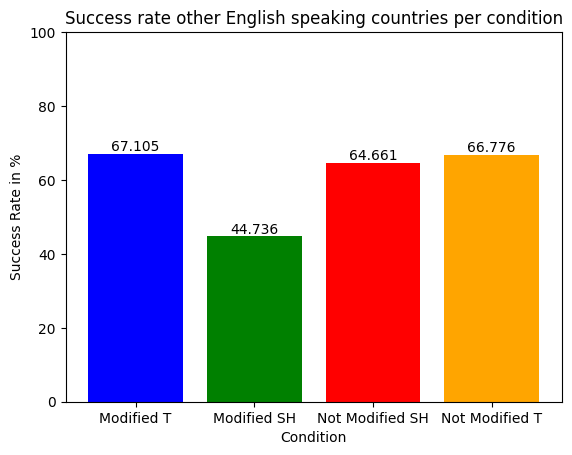

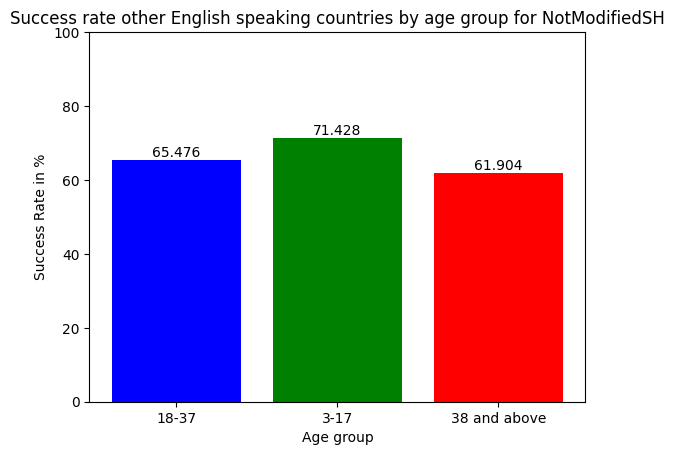

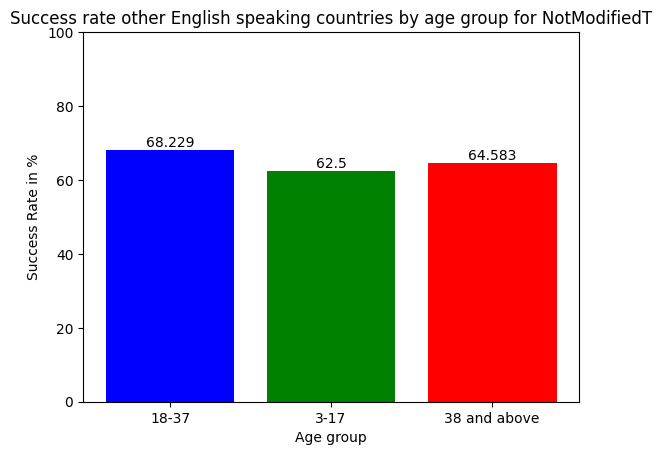

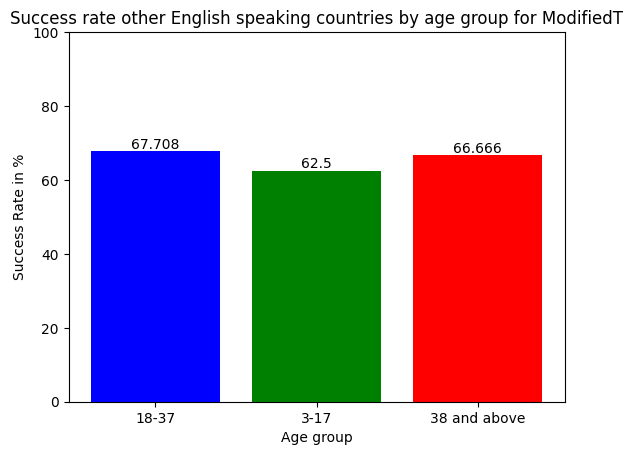

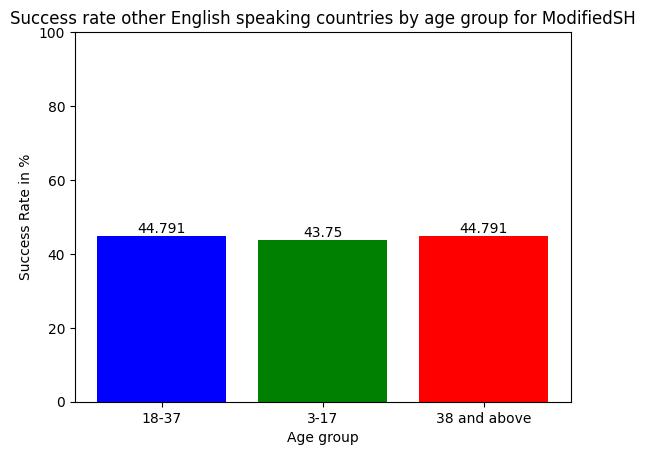

age1 vs age2 vs age3
ANOVA results:
              sum_sq      df         F    PR(>F)
C(Age)      0.107598     2.0  0.225027  0.798529
Residual  280.915323  1175.0       NaN       NaN
ANOVA is not significant, so Tukey HSD test is not performed.
Chi-square statistic: 0.45103082662477906
P-value: 0.7981047589151189
Degrees of freedom: 2
Expected frequencies table:
[[ 24.36842105 292.42105263 146.21052632]
 [ 37.63157895 451.57894737 225.78947368]]
The result is not significant. There is no significant association between the variables.


<ipython-input-3-42dc9ffccb48>:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[param1] = pd.to_numeric(dataset[param1], errors='coerce')


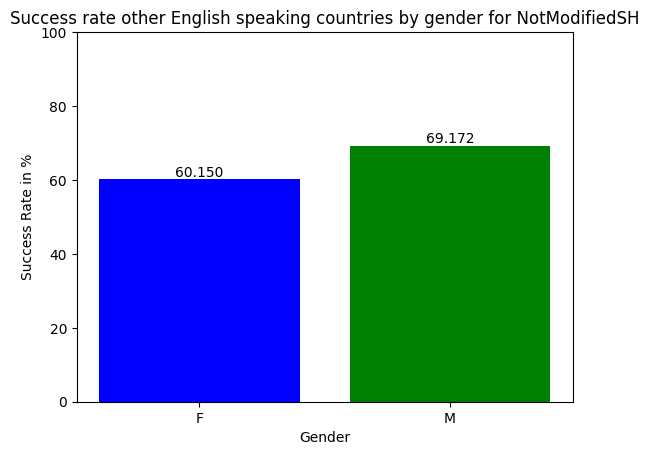

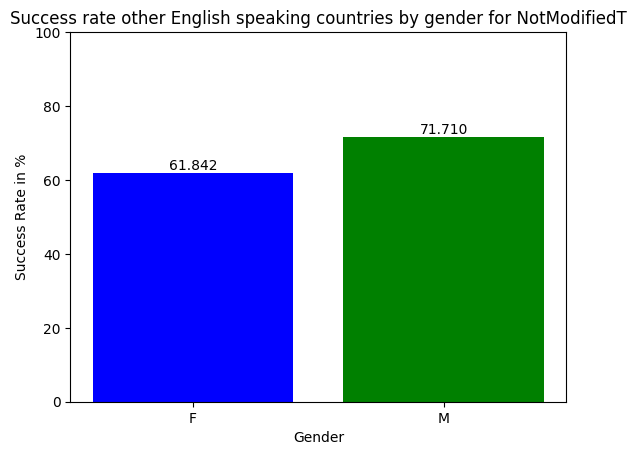

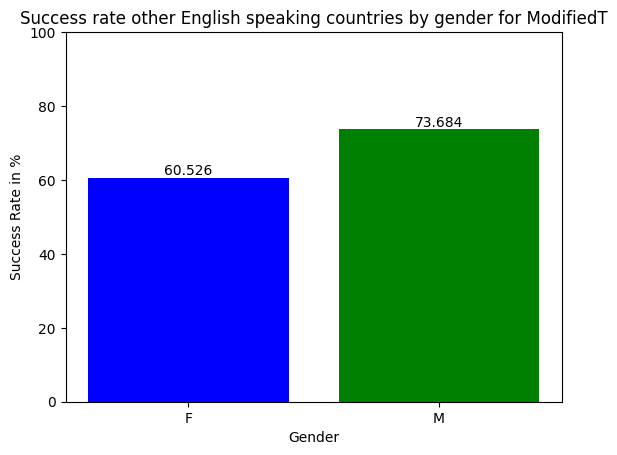

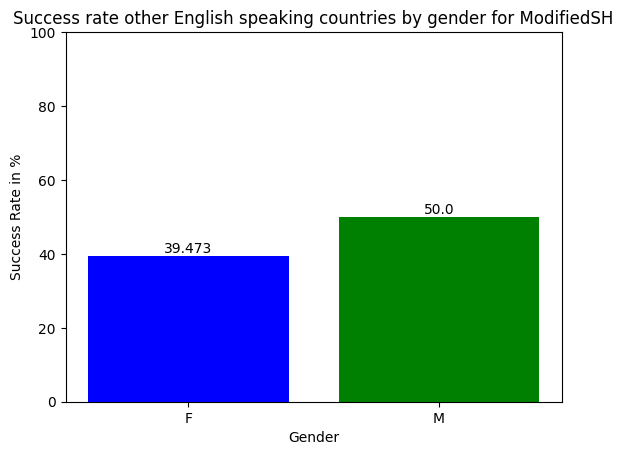

F vs M listeners
---- Performing Ttest ----
Reject the null hypothesis. There is a significant difference between the means.
t-statistic: -14.037946462782012
p-value: 1.6724382326032626e-41

Chi-square statistic: 13.678599586158981
P-value: 0.00021691230795527837
Degrees of freedom: 1
Expected frequencies table:
[[231.5 231.5]
 [357.5 357.5]]
The result is significant. There is a significant association between the variables.


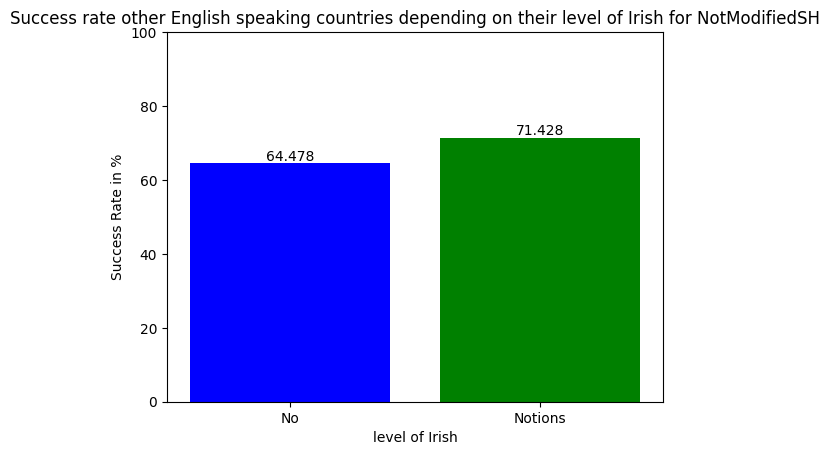

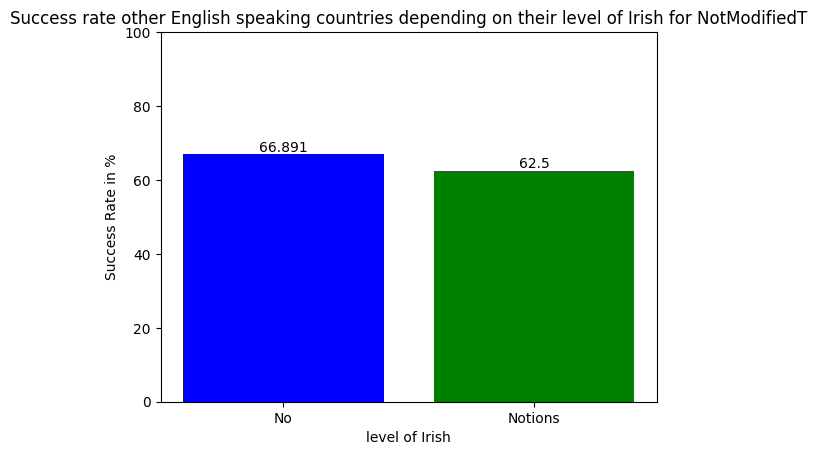

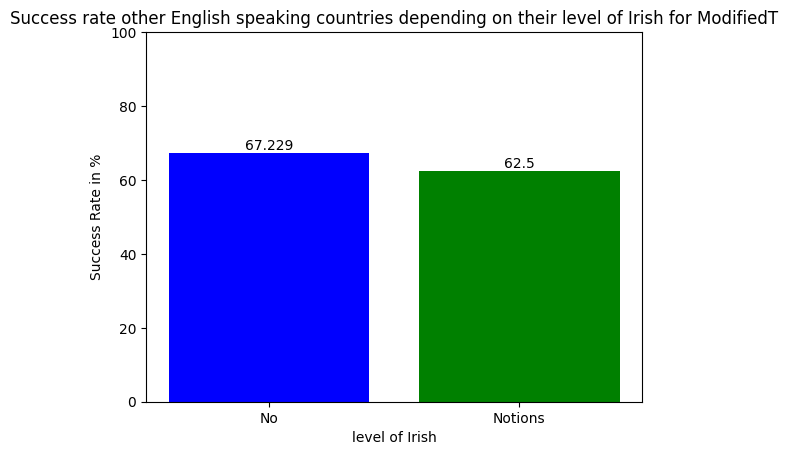

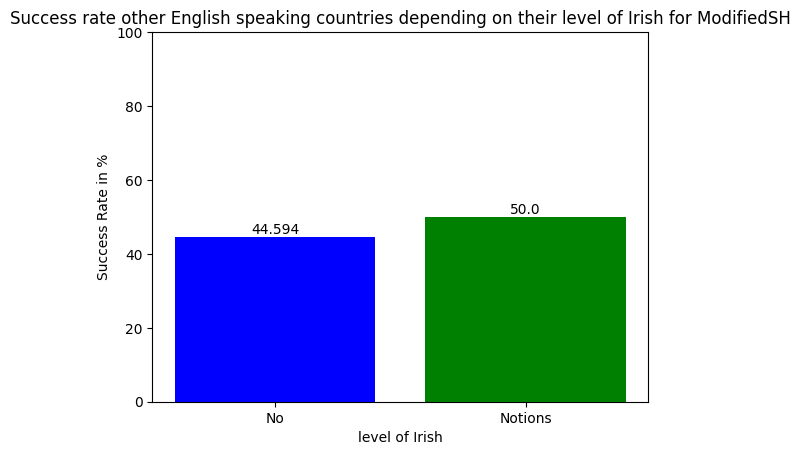

level of Irish yes vs no vs notions
---- Performing Ttest ----
Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.
t-statistic: -0.2372002434364846
p-value: 0.812542761217328

Chi-square statistic: 0.0
P-value: 1.0
Degrees of freedom: 1
Expected frequencies table:
[[450.81578947  12.18421053]
 [696.18421053  18.81578947]]
The result is not significant. There is no significant association between the variables.


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


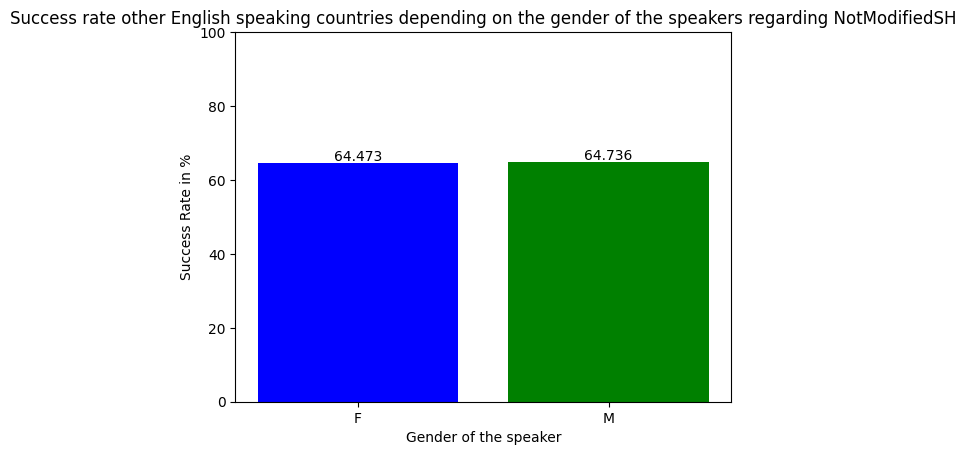

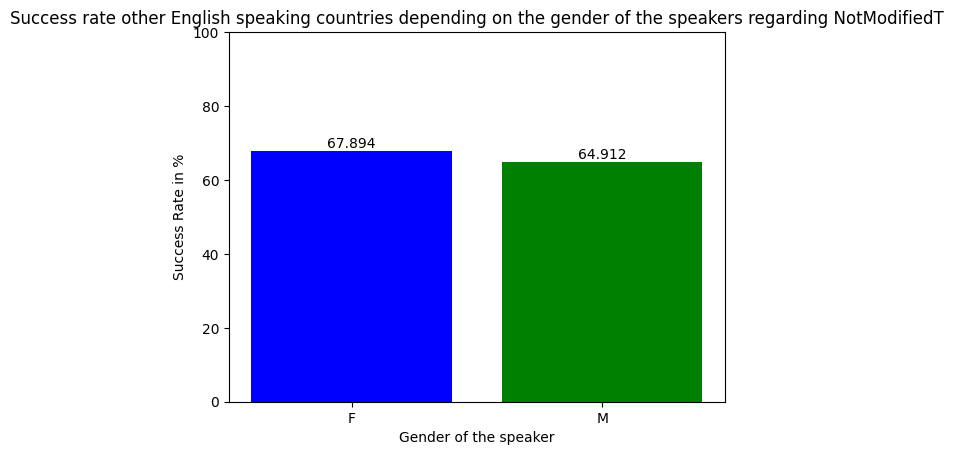

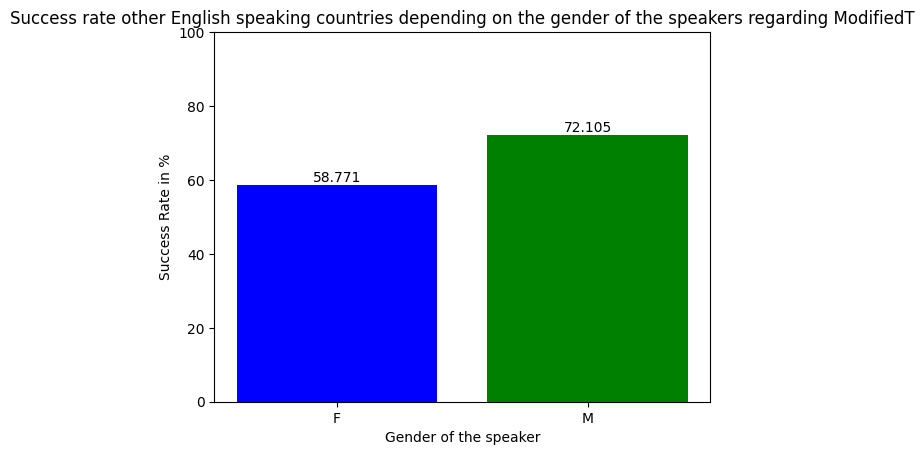

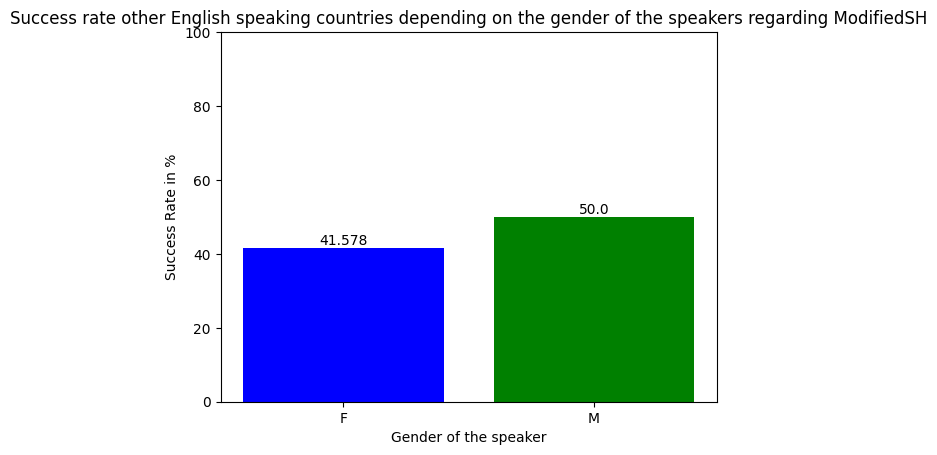

F vs M speakers
---- Performing Ttest ----
Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.
t-statistic: 8.625648808426424e-15
p-value: 0.9999999999999931

Chi-square statistic: 6.566638907348945
P-value: 0.01039080027288774
Degrees of freedom: 1
Expected frequencies table:
[[224.03225806 238.96774194]
 [345.96774194 369.03225806]]
The result is significant. There is a significant association between the variables.


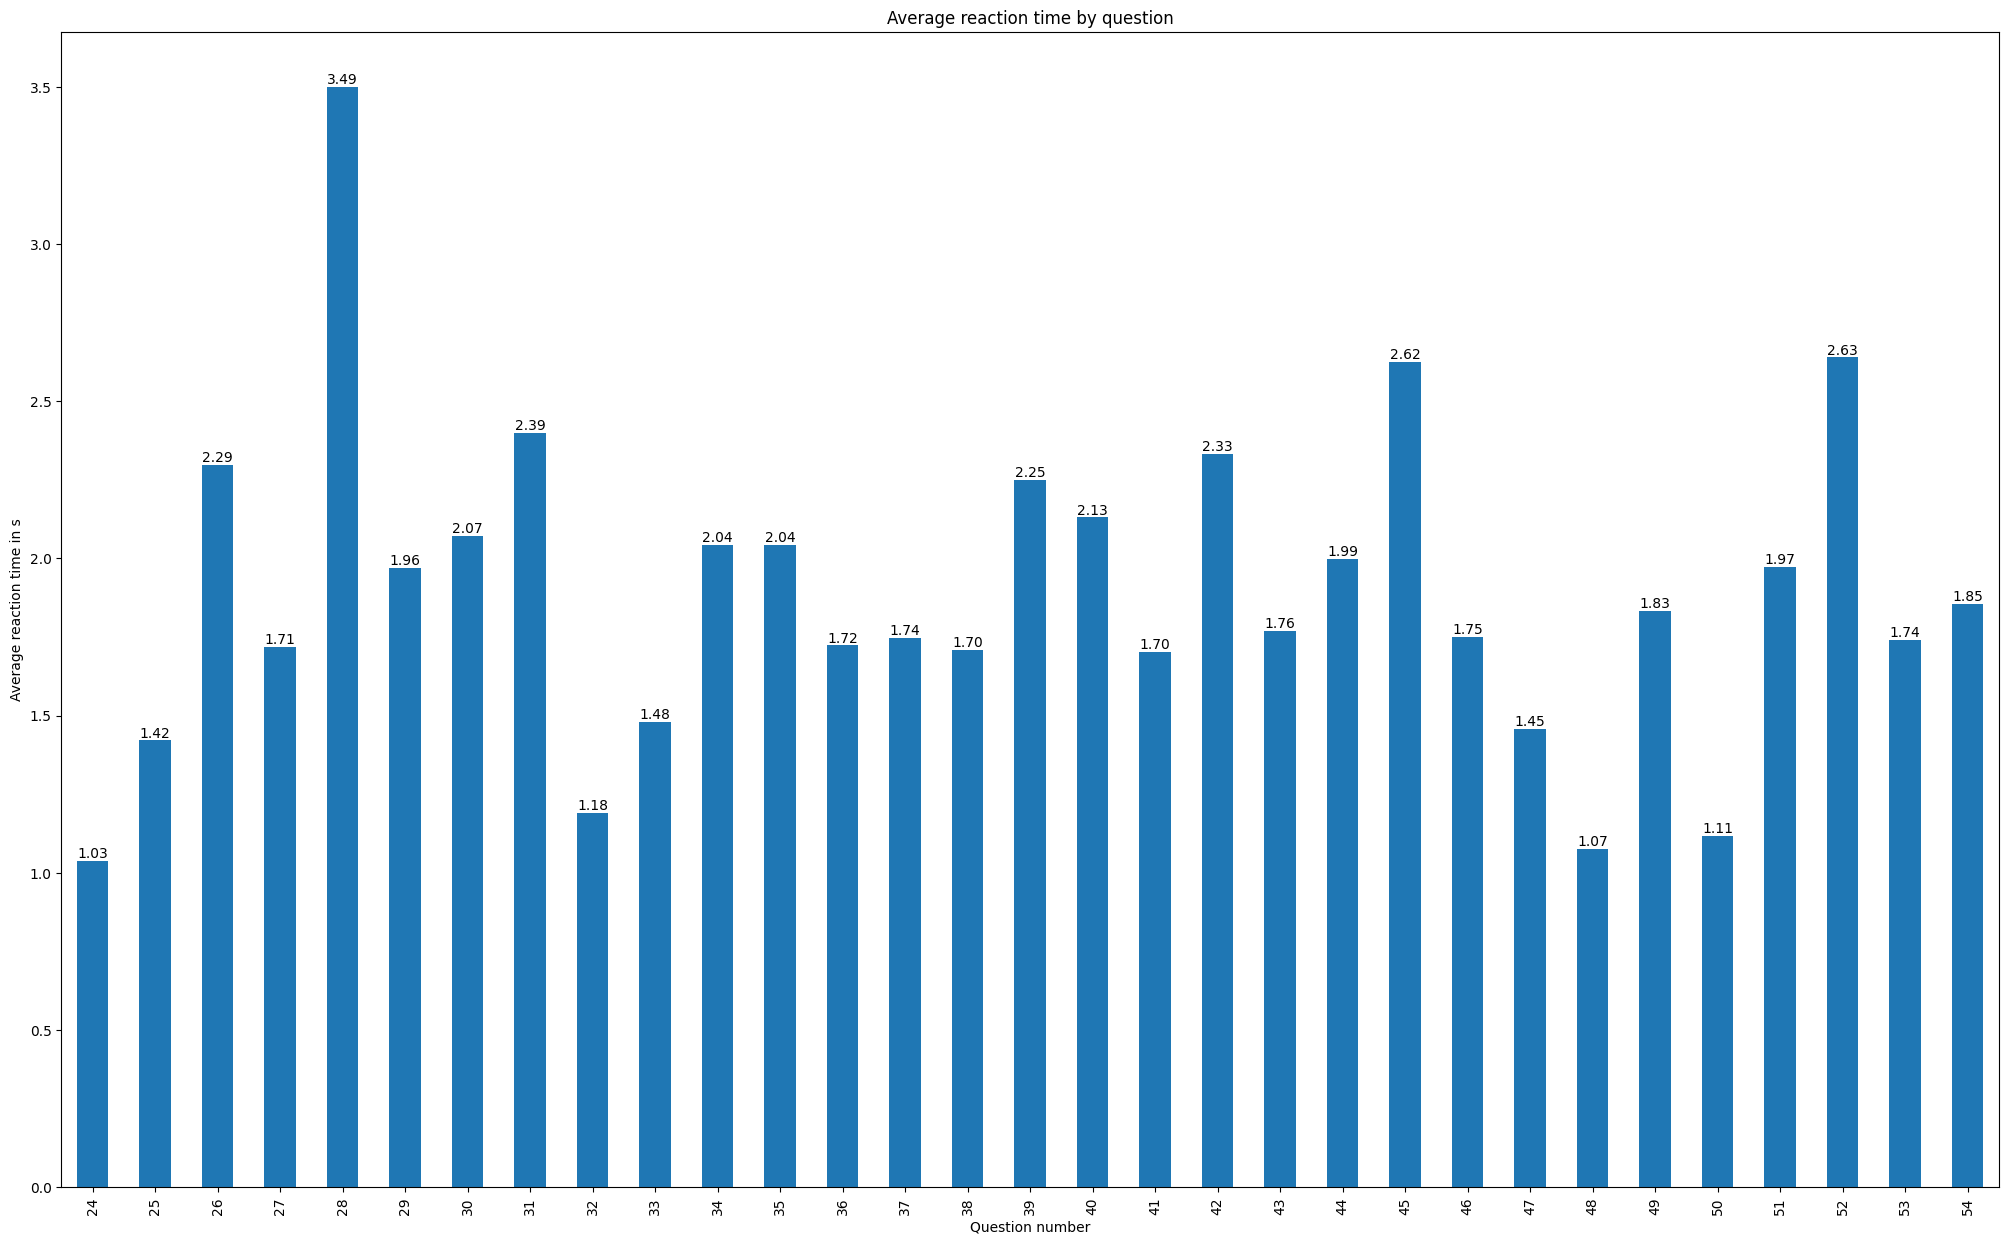

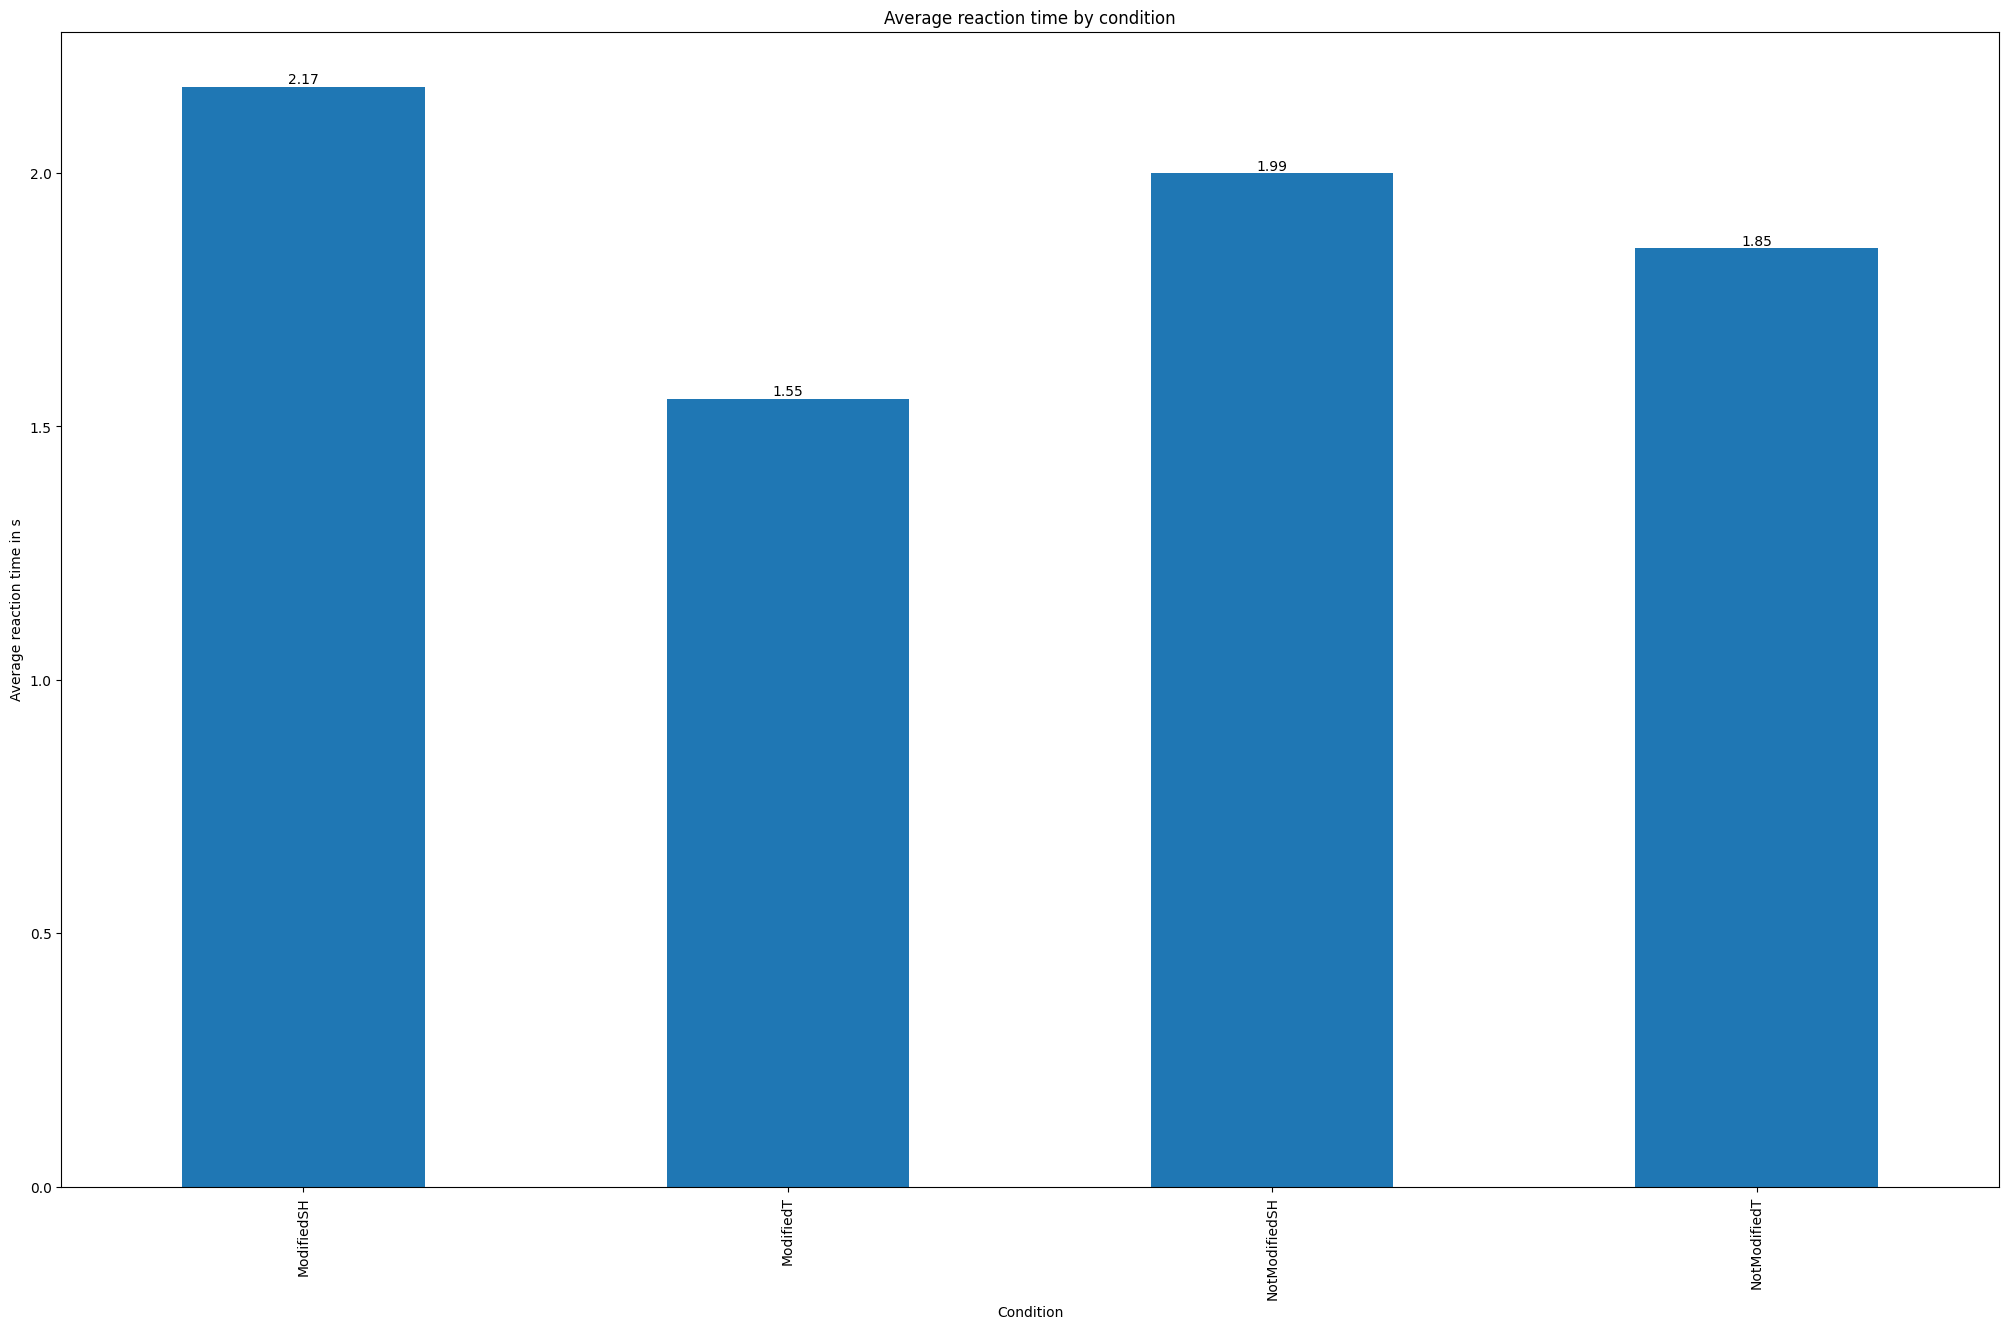

Modified T vs ModifiedSH impact on success of the Irish
---- Performing Ttest ----
Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.
t-statistic: 0.0
p-value: 1.0

Not Modified T vs Not ModifiedSH impact on success of the Irish
---- Performing Ttest ----
Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.
t-statistic: 5.9844067809662295e-15
p-value: 0.9999999999999952

If it's close to -1, it indicates a strong negative correlation (as one variable increases, the other tends to decrease). If it's close to 0, it indicates no linear correlation between the variables.
Pearson correlation coefficient between Success and Reaction time: -0.016164588144745327
P-value: 0.5794089400954624

Correlation between frequency and Success: -4.58263891711774e-19
P-value: 0.9999999999999991

P-value: 0.09385571519817427
Correlation between frequency and Reaction time: -0.04883689309341944


In [ ]:
# @title Other English Speaking Countries

#-------Per CONDITION
# Categorize 'Country' into 'Other English Speaking Countries'
filtered_df_lex_mod_t = df_mod_T.loc[df_mod_T['Country'] != 'Ireland']
filtered_df_lex_mod_sh = df_mod_SH.loc[df_mod_SH['Country'] != 'Ireland']
filtered_df_lex_not_mod_t = df_not_mod_T.loc[df_not_mod_T['Country'] != 'Ireland']
filtered_df_lex_not_mod_sh = df_not_mod_SH.loc[df_not_mod_SH['Country'] != 'Ireland']

# Calculate success rate for each condition in Other English Speaking Countries
success_ModifiedT = 100 * filtered_df_lex_mod_t[filtered_df_lex_mod_t['Success'] == 1].shape[0] / filtered_df_lex_mod_t.shape[0]
success_ModifiedSH = 100 * filtered_df_lex_mod_sh[filtered_df_lex_mod_sh['Success'] == 1].shape[0] / filtered_df_lex_mod_sh.shape[0]
success_NotModifiedT = 100 * filtered_df_lex_not_mod_t[filtered_df_lex_not_mod_t['Success'] == 1].shape[0] / filtered_df_lex_not_mod_t.shape[0]
success_NotModifiedSH = 100 * filtered_df_lex_not_mod_sh[filtered_df_lex_not_mod_sh['Success'] == 1].shape[0] / filtered_df_lex_not_mod_sh.shape[0]

headers = ['Modified T','Modified SH','Not Modified SH','Not Modified T']
datas = [success_ModifiedT, success_ModifiedSH, success_NotModifiedSH, success_NotModifiedT]
print(datas)
plot_2d_array(headers, datas, 'Condition', 'Success Rate in %', 'Success rate other English speaking countries per condition', colours=plot_colours80s)

#----------------------------------by AGE GROUP----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
filter_withoutIrish = df_lex.loc[df_lex['Country'] != 'Ireland']
for x in condition:
    df = filter_withoutIrish[filter_withoutIrish['Condition'] == x]
    plot_success_rate_by_parameter(df, x, 'Age_group', 'Age group', 'Success Rate in %',  'Success rate other English speaking countries by age group for ', colours=plot_colours80s)
#------Anova Age
print('age1 vs age2 vs age3')
do_anova(filter_withoutIrish, 'Success', 'Age')
# -------------chi2 Age
do_chi_square_test(filter_withoutIrish['Success'], filter_withoutIrish['Age'])

#---------------------------------by GENDER----------------------------------------------------------------------------------------------------------------------------------------------------------------------
for x in condition:
    df = filter_withoutIrish[filter_withoutIrish['Condition'] == x]
    plot_success_rate_by_parameter(df, x, 'Gender', 'Gender', 'Success Rate in %',  'Success rate other English speaking countries by gender for ', colours=plot_colours80s)
#--------ttest
print('F vs M listeners')
val1 = filter_withoutIrish[filter_withoutIrish['Gender'] == 'F']['SuccessRateParticipant']
val2 = filter_withoutIrish[filter_withoutIrish['Gender'] == 'M']['SuccessRateParticipant']
do_ttest(val1, val2)
# -------------chi2 gender
do_chi_square_test(filter_withoutIrish['Success'], filter_withoutIrish['Gender'])

#-----------------------------by LEVEL OF IRISH---------------------------------------------------------------------------------------------------------------------------------------------------------------------
for x in condition:
    df = filter_withoutIrish[filter_withoutIrish['Condition'] == x]
    plot_success_rate_by_parameter(df, x, 'Irish', 'level of Irish', 'Success Rate in %',  'Success rate other English speaking countries depending on their level of Irish for ', colours=plot_colours80s)
#----------ttest
print('level of Irish yes vs no vs notions')
val1 = filter_withoutIrish[filter_withoutIrish['Irish'] == 'No']['SuccessRateParticipant']
val2 = filter_withoutIrish[filter_withoutIrish['Irish'] == 'Notions']['SuccessRateParticipant']
do_ttest(val1, val2)
# -----------------------chi2 level Irish
do_chi_square_test(filter_withoutIrish['Success'], filter_withoutIrish['Irish'])

#------------------------------by GENDER of the speaker-----------------------------------------------------------------------------------------------------------------------------------------------------------------
for x in condition:
    df = filter_withoutIrish[filter_withoutIrish['Condition'] == x]
    plot_success_rate_by_parameter(df, x, 'Condition2', 'Gender of the speaker', 'Success Rate in %',  'Success rate other English speaking countries depending on the gender of the speakers regarding ', colours=plot_colours80s)
#------ttest
print('F vs M speakers')
val1 = filter_withoutIrish[filter_withoutIrish['Condition2'] == 'F']['SuccessRateParticipant']
val2 = filter_withoutIrish[filter_withoutIrish['Condition2'] == 'M']['SuccessRateParticipant']
do_ttest(val1, val2)
# ---------------------chi2 speaker gender
do_chi_square_test(filter_withoutIrish['Success'], filter_withoutIrish['Condition2'])

#------------Average reaction time in s By ItemNb---------------------------------------------------------------------------------------------------------------------------------------------
plot_bar_average_parameter(filter_withoutIrish, 'ItemNb', 'Question number', 'Average reaction time in s', 'Average reaction time by question', 'Reaction time')

#------------Average reaction time in s By condition
plot_bar_average_parameter(filter_withoutIrish, 'Condition', 'Condition', 'Average reaction time in s', 'Average reaction time by condition', 'Reaction time')

#we want to check if there is a significant difference between the success rate of the Irish when slit /t/ was modified and when SH was modified. Same with non modified sounds
#-----------TTEST on 'Modified SH vs Modified T' ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
print('Modified T vs ModifiedSH impact on success of the Irish')
val1 = filter_withoutIrish[filter_withoutIrish['Condition'] == 'ModifiedT']['SuccessRateParticipant']
val2 = filter_withoutIrish[filter_withoutIrish['Condition'] == 'ModifiedSH']['SuccessRateParticipant']
do_ttest(val1, val2)
#-----------TTEST on 'Not Modified SH vs Not Modified T' -----------------------------------------------------------------------
print('Not Modified T vs Not ModifiedSH impact on success of the Irish')
val1 = filter_withoutIrish[filter_withoutIrish['Condition'] == 'NotModifiedT']['SuccessRateParticipant']
val2 = filter_withoutIrish[filter_withoutIrish['Condition'] == 'NotModifiedSH']['SuccessRateParticipant']
do_ttest(val1, val2)

# -----------------------------------------------------------------------Calculate Pearson correlation coefficient-----

#------------------------------------CORRELATION success and Reaction time
correlation_success_reaction_noIrish = filter_withoutIrish['SuccessRateParticipant'].corr(filter_withoutIrish['Reaction time'])
print("If it's close to -1, it indicates a strong negative correlation (as one variable increases, the other tends to decrease). If it's close to 0, it indicates no linear correlation between the variables.")
print("Pearson correlation coefficient between Success and Reaction time:", correlation_success_reaction_noIrish)
# Calculate Pearson correlation coefficient and p-value for Success and Reaction time
corr_coef_success_reaction_noIrish, p_value_success_reaction_noIrish = stats.pearsonr(filter_withoutIrish['SuccessRateParticipant'], filter_withoutIrish['Reaction time'])
print("P-value:", p_value_success_reaction_noIrish)
print("")

#-----------------------------------CORRELATION Success and FREQUENCY OF WORDS
# Calculate correlation between frequency and Success
correlation_success_frequency_noIrish = filter_withoutIrish['Frequency'].apply(lambda x: x[0] if isinstance(x, list) else x).corr(filter_withoutIrish['SuccessRateParticipant'])
# Calculate Pearson correlation coefficient and p-value for Success and Frequency
corr_coef_success_frequency_noIrish, p_value_success_frequency_noIrish = stats.pearsonr(filter_withoutIrish['Frequency'], filter_withoutIrish['SuccessRateParticipant'])
print("Correlation between frequency and Success:", correlation_success_frequency_noIrish)
print("P-value:", p_value_success_frequency_noIrish)
print("")

# -------------------------------- CORRELATION between frequency and Reaction time
correlation_reaction_time_frequency_noIrish = filter_withoutIrish['Frequency'].apply(lambda x: x[0] if isinstance(x, list) else x).corr(filter_withoutIrish['Reaction time'])
# Calculate Pearson correlation coefficient and p-value for Frequency and Reaction time
corr_coef_reaction_time_frequency_noIrish, p_value_reaction_time_frequency_noIrish = stats.pearsonr(filter_withoutIrish['Frequency'], filter_withoutIrish['Reaction time'])
print("P-value:", p_value_reaction_time_frequency_noIrish)
print("Correlation between frequency and Reaction time:", correlation_reaction_time_frequency_noIrish)

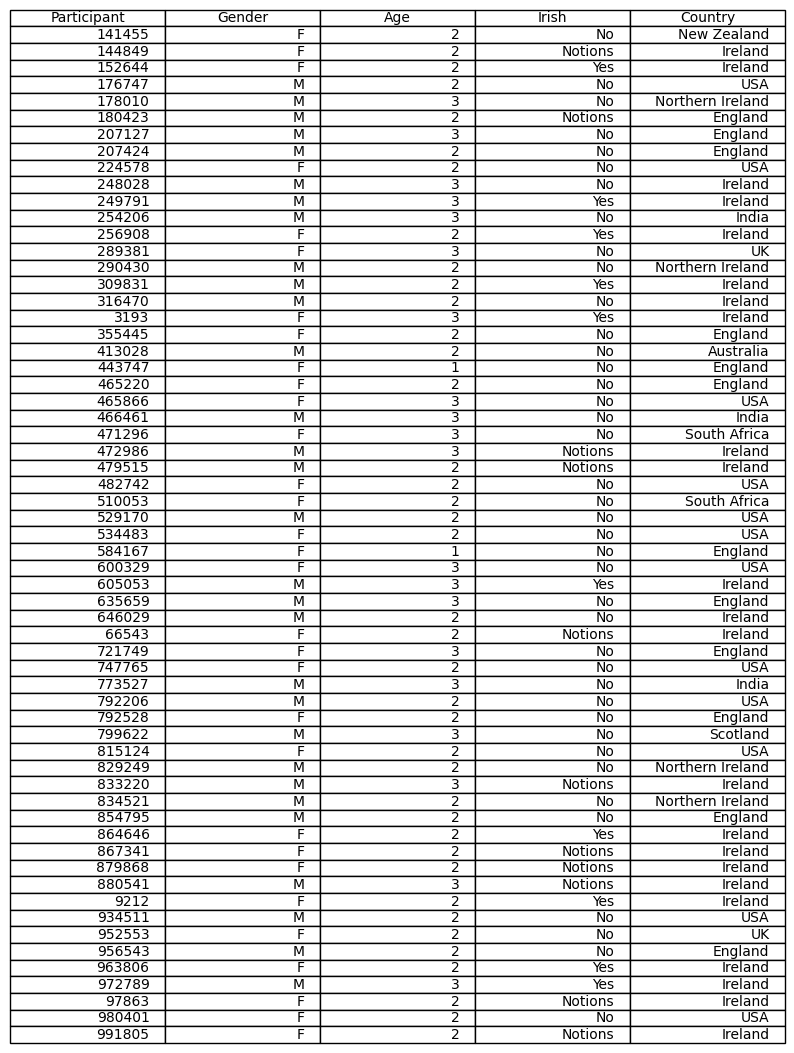

In [ ]:
# @title TABLE PARTICIPANTS

#Group by 'Participant' and select the first row of each group
unique_participants_df = df_lex.groupby('Participant').first().reset_index()

# Select the columns you want
selected_columns = ['Participant', 'Gender', 'Age', 'Irish', 'Country']

# Create a new DataFrame with only the selected columns
table_df = unique_participants_df[selected_columns]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Hide the axes
ax.axis('off')

# Plot the table
table = ax.table(cellText=table_df.values,
                 colLabels=table_df.columns,
                 loc='center')

# Adjust the font size
table.auto_set_font_size(False)
table.set_fontsize(10)

# Save the figure as an image
plt.savefig('participant_table.png', bbox_inches='tight')


In [ ]:
# @title Succes rate per participant within the irish

for x in filter_withinIrish['Participant'].unique():
  success_responses = filter_withinIrish[(filter_withinIrish['Participant'] == x) & filter_withinIrish['Success'] == 1]['Success'].sum()
  total_responses = filter_withinIrish[(filter_withinIrish['Participant'] == x)]['Success'].count()
  if total_responses == 0:
    total_responses = 1

  print("Success rate for " + x + " is " + str(round(success_responses / total_responses * 100, 2)) + "%")



  # use this success rate at the dependent variable for anova

Success rate for 3193 is 64.52%
Success rate for 9212 is 64.52%
Success rate for 66543 is 38.71%
Success rate for 97863 is 58.06%
Success rate for 144849 is 77.42%
Success rate for 256908 is 61.29%
Success rate for 316470 is 64.52%
Success rate for 646029 is 74.19%
Success rate for 864646 is 80.65%
Success rate for 867341 is 74.19%
Success rate for 879868 is 54.84%
Success rate for 963806 is 77.42%
Success rate for Ali is 87.1%
Success rate for Bertia is 80.65%
Success rate for Cliodhna is 70.97%
Success rate for Colin is 64.52%
Success rate for Conor is 83.87%
Success rate for Liam is 58.06%
Success rate for Maurice is 100.0%
Success rate for Pat is 58.06%
Success rate for Paul is 48.39%
Success rate for Saoirse is 87.1%
Success rate for William is 58.06%


In [ ]:
# @title Succes rate per participant within other

for x in filter_withoutIrish['Participant'].unique():
  success_responses = filter_withoutIrish[(filter_withoutIrish['Participant'] == x) & filter_withoutIrish['Success'] == 1]['Success'].sum()
  total_responses = filter_withoutIrish[(filter_withoutIrish['Participant'] == x)]['Success'].count()
  if total_responses == 0:
    total_responses = 1

  print("Success rate for " + x + " is " + str(round(success_responses / total_responses * 100, 2)) + "%")

Success rate for 141455 is 70.97%
Success rate for 176747 is 51.61%
Success rate for 224578 is 29.03%
Success rate for 289381 is 35.48%
Success rate for 290430 is 87.1%
Success rate for 465866 is 61.29%
Success rate for 482742 is 54.84%
Success rate for 510053 is 54.84%
Success rate for 529170 is 74.19%
Success rate for 534483 is 45.16%
Success rate for 600329 is 45.16%
Success rate for 747765 is 32.26%
Success rate for 792528 is 64.52%
Success rate for 799622 is 61.29%
Success rate for 815124 is 54.84%
Success rate for 829249 is 48.39%
Success rate for 834521 is 93.55%
Success rate for 952553 is 77.42%
Success rate for Adam is 64.52%
Success rate for Adrien is 58.06%
Success rate for Aiden is 61.29%
Success rate for Andrew is 45.16%
Success rate for Balbir is 54.84%
Success rate for Bow is 64.52%
Success rate for Dave is 80.65%
Success rate for Denise is 58.06%
Success rate for Ellie is 54.84%
Success rate for Gabriel is 74.19%
Success rate for Jon is 70.97%
Success rate for Kaldip is

                              Mixed Linear Model Regression Results
Model:                          MixedLM               Dependent Variable:               Success   
No. Observations:               1891                  Method:                           REML      
No. Groups:                     61                    Scale:                            0.2120    
Min. group size:                31                    Log-Likelihood:                   -1279.6065
Max. group size:                31                    Converged:                        Yes       
Mean group size:                31.0                                                              
--------------------------------------------------------------------------------------------------
                                                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------------
Intercept                                

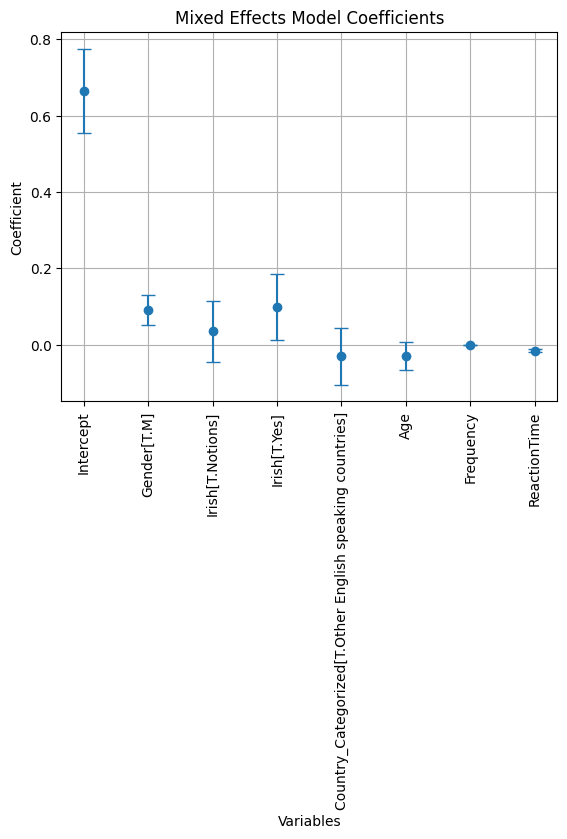

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: ReactionTime
No. Observations: 1891    Method:             REML        
No. Groups:       20      Scale:              8.6573      
Min. group size:  61      Log-Likelihood:     -4743.5336  
Max. group size:  244     Converged:          Yes         
Mean group size:  94.5                                    
-----------------------------------------------------------
            Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept    1.918     0.106  18.053  0.000   1.710   2.126
Frequency   -0.000     0.000  -1.652  0.099  -0.000   0.000
Group Var    0.074     0.022                               



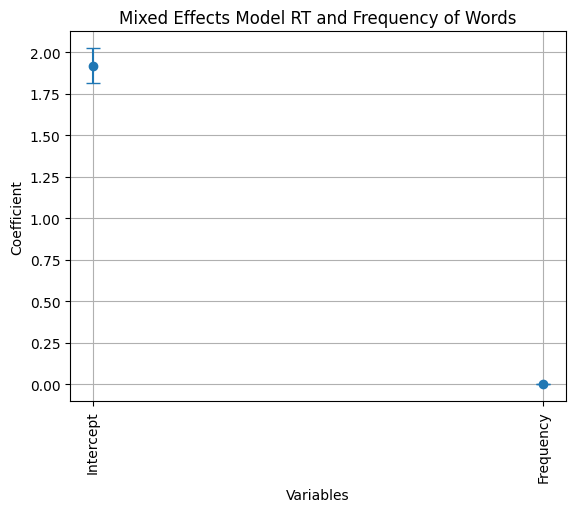

In [ ]:
# @title MIXED EFFECTS MODEL all participants
# Flatten the list of frequencies to a single frequency column
df_lex['Frequency'] = df_lex['Frequency'].apply(lambda x: x[0] if isinstance(x, list) else x)
# Rename 'Reaction time' column to remove the space
df_lex = df_lex.rename(columns={'Reaction time': 'ReactionTime'})
# Fit the mixed effects model
model = smf.mixedlm("Success ~ Gender + Age + Irish + Country_Categorized + Frequency + ReactionTime", df_lex, groups=df_lex["Participant"])
result = model.fit()

# Print the summary of the model
print(result.summary())

# Extract the coefficients and standard errors
coefs = result.fe_params
stderr = result.bse_fe

# Plot the coefficients with error bars
plt.errorbar(coefs.index, coefs.values, yerr=stderr, fmt='o', capsize=5)
plt.xlabel('Variables')
plt.ylabel('Coefficient')
plt.title('Mixed Effects Model Coefficients')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

#------------------RT and Frequency


# Fit the mixed-effects model
model = smf.mixedlm("ReactionTime ~ Frequency", df_lex, groups=df_lex["Word"])
result = model.fit()
# Print the summary of the model
print(result.summary())
# Extract the coefficients and standard errors
coefs = result.fe_params
stderr = result.bse_fe

# Plot the coefficients with error bars
plt.errorbar(coefs.index, coefs.values, yerr=stderr, fmt='o', capsize=5)
plt.xlabel('Variables')
plt.ylabel('Coefficient')
plt.title('Mixed Effects Model RT and Frequency of Words')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

           Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  Success  
No. Observations:   713      Method:              REML     
No. Groups:         23       Scale:               0.1905   
Min. group size:    31       Log-Likelihood:      -461.4507
Max. group size:    31       Converged:           Yes      
Mean group size:    31.0                                   
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         0.661    0.188  3.519 0.000  0.293  1.029
Gender[T.M]       0.085    0.093  0.921 0.357 -0.096  0.267
Irish[T.Notions]  0.069    0.116  0.601 0.548 -0.157  0.296
Irish[T.Yes]      0.125    0.118  1.054 0.292 -0.107  0.357
Age              -0.049    0.089 -0.554 0.580 -0.224  0.125
ReactionTime     -0.013    0.005 -2.751 0.006 -0.023 -0.004
Frequency         0.000    0.000  5.408 0.000  0.00

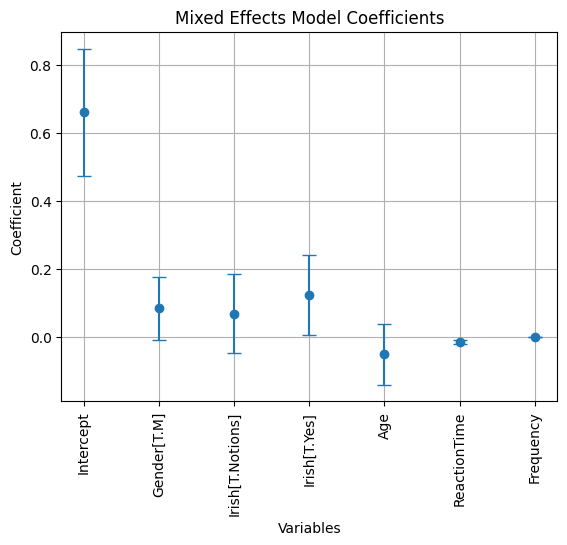

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: ReactionTime
No. Observations: 713     Method:             REML        
No. Groups:       20      Scale:              12.0384     
Min. group size:  23      Log-Likelihood:     -1912.4113  
Max. group size:  92      Converged:          Yes         
Mean group size:  35.6                                    
-----------------------------------------------------------
            Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept    1.940     0.151  12.829  0.000   1.644   2.237
Frequency   -0.000     0.000  -1.448  0.147  -0.000   0.000
Group Var    0.016     0.031                               



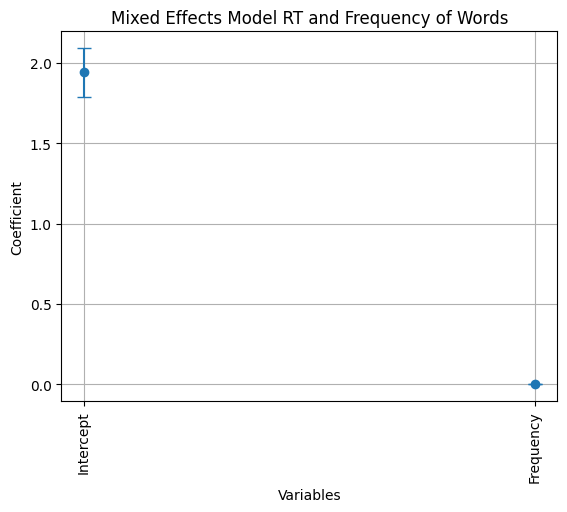

In [ ]:
# @title MIXED EFFECTS MODEL within the Irish

df_lex.head()

# Flatten the list of frequencies to a single frequency column
filter_withinIrish['Frequency'] = filter_withinIrish['Frequency'].apply(lambda x: x[0] if isinstance(x, list) else x)
# Rename 'Reaction time' column to remove the space
filter_withinIrish = filter_withinIrish.rename(columns={'Reaction time': 'ReactionTime'})
# Fit the mixed effects model
model = smf.mixedlm("Success ~ Gender + Age + Irish + ReactionTime + Frequency", filter_withinIrish, groups=filter_withinIrish["Participant"])
result = model.fit()
# Print the summary of the model
print(result.summary())
# Extract the coefficients and standard errors
coefs = result.fe_params
stderr = result.bse_fe
# Plot the coefficients with error bars
plt.errorbar(coefs.index, coefs.values, yerr=stderr, fmt='o', capsize=5)
plt.xlabel('Variables')
plt.ylabel('Coefficient')
plt.title('Mixed Effects Model Coefficients')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

#------------------RT and Frequency

# Fit the mixed-effects model
model = smf.mixedlm("ReactionTime ~ Frequency", filter_withinIrish, groups=filter_withinIrish["Word"])
result = model.fit()
# Print the summary of the model
print(result.summary())
# Extract the coefficients and standard errors
coefs = result.fe_params
stderr = result.bse_fe
# Plot the coefficients with error bars
plt.errorbar(coefs.index, coefs.values, yerr=stderr, fmt='o', capsize=5)
plt.xlabel('Variables')
plt.ylabel('Coefficient')
plt.title('Mixed Effects Model RT and Frequency of Words')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

           Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  Success  
No. Observations:   1178     Method:              REML     
No. Groups:         38       Scale:               0.2235   
Min. group size:    31       Log-Likelihood:      -832.6286
Max. group size:    31       Converged:           Yes      
Mean group size:    31.0                                   
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         0.632    0.097  6.517 0.000  0.442  0.822
Gender[T.M]       0.110    0.047  2.359 0.018  0.019  0.202
Irish[T.Notions] -0.068    0.144 -0.475 0.635 -0.350  0.213
Age              -0.024    0.042 -0.565 0.572 -0.107  0.059
ReactionTime     -0.018    0.006 -3.244 0.001 -0.029 -0.007
Frequency         0.000    0.000  1.497 0.134 -0.000  0.000
Group Var         0.012    0.010                   

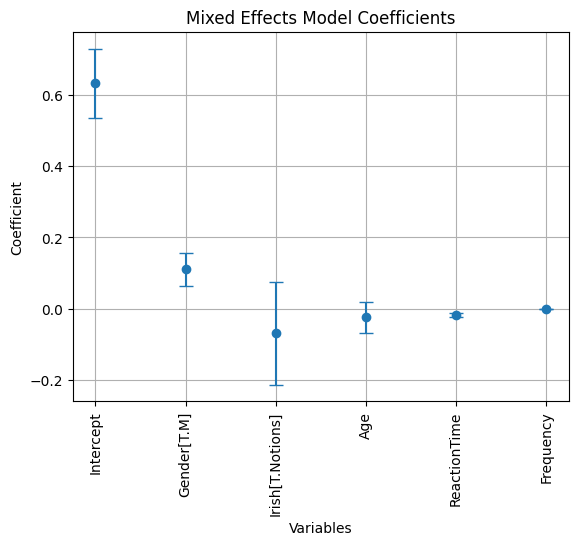

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: ReactionTime
No. Observations: 1178    Method:             REML        
No. Groups:       20      Scale:              6.6313      
Min. group size:  38      Log-Likelihood:     -2805.7672  
Max. group size:  152     Converged:          Yes         
Mean group size:  58.9                                    
-----------------------------------------------------------
            Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept    1.916     0.122  15.651  0.000   1.676   2.156
Frequency   -0.000     0.000  -1.214  0.225  -0.000   0.000
Group Var    0.107     0.036                               



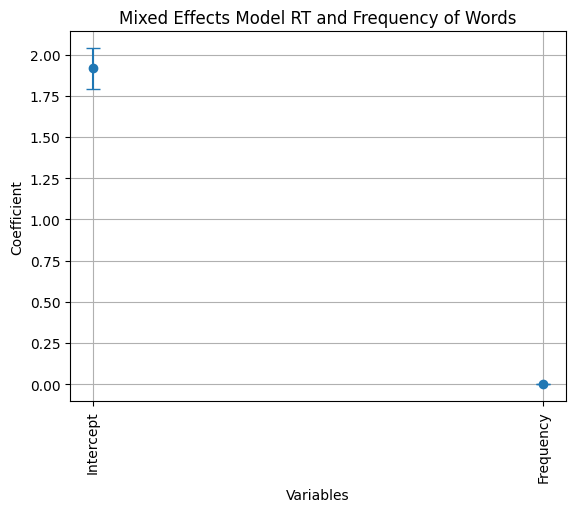

In [ ]:
# @title MIXED EFFECTS MODEL with other countries

df_lex.head()
# Flatten the list of frequencies to a single frequency column
filter_withoutIrish['Frequency'] = filter_withoutIrish['Frequency'].apply(lambda x: x[0] if isinstance(x, list) else x)
# Rename 'Reaction time' column to remove the space
filter_withoutIrish = filter_withoutIrish.rename(columns={'Reaction time': 'ReactionTime'})
# Fit the mixed effects model
model = smf.mixedlm("Success ~ Gender + Age + Irish + ReactionTime + Frequency", filter_withoutIrish, groups=filter_withoutIrish["Participant"])
result = model.fit()
# Print the summary of the model
print(result.summary())
# Extract the coefficients and standard errors
coefs = result.fe_params
stderr = result.bse_fe
# Plot the coefficients with error bars
plt.errorbar(coefs.index, coefs.values, yerr=stderr, fmt='o', capsize=5)
plt.xlabel('Variables')
plt.ylabel('Coefficient')
plt.title('Mixed Effects Model Coefficients')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()
#------------------RT and Frequency


# Fit the mixed-effects model
model = smf.mixedlm("ReactionTime ~ Frequency", filter_withoutIrish, groups=filter_withoutIrish["Word"])
result = model.fit()
# Print the summary of the model
print(result.summary())
# Extract the coefficients and standard errors
coefs = result.fe_params
stderr = result.bse_fe
# Plot the coefficients with error bars
plt.errorbar(coefs.index, coefs.values, yerr=stderr, fmt='o', capsize=5)
plt.xlabel('Variables')
plt.ylabel('Coefficient')
plt.title('Mixed Effects Model RT and Frequency of Words')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

In [ ]:
# mixed effects model for lexical frequency and response time per item

In [ ]:
# @title Logistic

#use numbers only and under 100

do_logistic_regression(df_lex, 'ReactionTimeLogTransform', 'FrequencyLogTransform')

Optimization terminated successfully.
         Current function value: 0.130019
         Iterations 7
                             Logit Regression Results                            
Dep. Variable:     FrequencyLogTransform   No. Observations:                 1891
Model:                             Logit   Df Residuals:                     1889
Method:                              MLE   Df Model:                            1
Date:                   Thu, 23 May 2024   Pseudo R-squ.:                     inf
Time:                           17:57:39   Log-Likelihood:                -245.87
converged:                          True   LL-Null:                        0.0000
Covariance Type:               nonrobust   LLR p-value:                     1.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -2.3740      0.085    -28.01

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:4469: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.llf/self.llnull


In [ ]:
# @title Signal Detection Theory All participants

#hit = I expect the participants to type 'e' (yes it is a word) and the participants pressed it.\\
#Miss = expect I expect the participants to type 'e' (yes it is a word) and the participants pressed 'r'.\\
#false alarm=  I expect the participants to type 'r' (no it is not a word) and the participants pressed 'e' (yes).\\
#Correct rejections = I expect the participants to type 'r' (no it is not a word) and the participants pressed it.

print('all')
signal_detection_theory(df_lex)
print('')
#------------------------------- Signal Detection Theory within irish
print('within irish')
signal_detection_theory(filter_withinIrish)
print('')
#------------------------------- Signal Detection Theory within other
print('other')
signal_detection_theory(filter_withoutIrish)

all
Hit : 33.655913978494624 %
Miss : 14.731182795698924 %
False Alarm : 30.268817204301072 %
Correct Rejection : 21.344086021505376 %

within irish
Hit : 36.80351906158358 %
Miss : 11.58357771260997 %
False Alarm : 32.697947214076244 %
Correct Rejection : 18.914956011730204 %

other
Hit : 31.833616298811545 %
Miss : 16.553480475382003 %
False Alarm : 28.862478777589136 %
Correct Rejection : 22.75042444821732 %


### Table

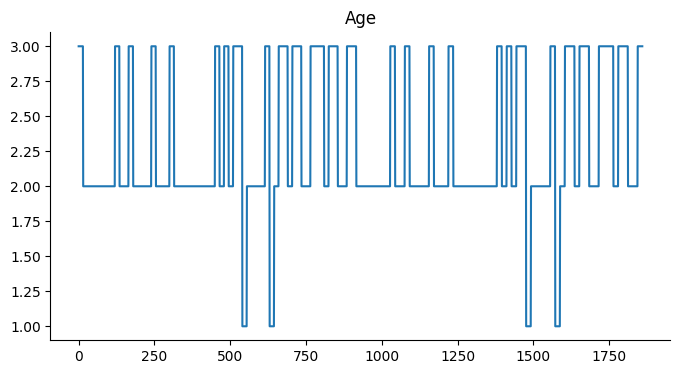

In [ ]:
# @title Age

from matplotlib import pyplot as plt
df_lex['Age'].plot(kind='line', figsize=(8, 4), title='Age')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
from scipy import stats
import pandas as pd

# Load data from CSV file
df_lex = pd.read_csv('/content/drive/MyDrive/R/LexicalDecision.csv')

# Calculate success rate for females and males
success_count_F = ((df_lex['Condition'].isin(["NotModifiedT", "NotModifiedSH"]) & (df_lex['ExpectedKey'] == df_lex['key_resp_question3.keys'])) |
                  (df_lex['Condition'].isin(["ModifiedT", "ModifiedSH"]) & (df_lex['ExpectedKey'] != df_lex['key_resp_question3.keys'])) &
                  (df_lex['Condition2'] == "F")).sum()

success_count_M = ((df_lex['Condition'].isin(["NotModifiedT", "NotModifiedSH"]) & (df_lex['ExpectedKey'] == df_lex['key_resp_question3.keys'])) |
                  (df_lex['Condition'].isin(["ModifiedT", "ModifiedSH"]) & (df_lex['ExpectedKey'] != df_lex['key_resp_question3.keys'])) &
                  (df_lex['Condition2'] == "M")).sum()

total_count = len(df_lex)

success_rate_F = success_count_F / total_count
success_rate_M = success_count_M / total_count

print("Success rate F:", success_rate_F)
print("Success rate M:", success_rate_M)

# Perform independent samples t-test for both genders on modified sounds

modified_ttest_gender_M = ((df_lex['Condition'].isin(["ModifiedT", "ModifiedSH"]) & (df_lex['ExpectedKey'] != df_lex['key_resp_question3.keys'])) &
                          (df_lex['Condition2'] == "M"))

modified_ttest_gender_F = ((df_lex['Condition'].isin(["ModifiedT", "ModifiedSH"]) & (df_lex['ExpectedKey'] != df_lex['key_resp_question3.keys'])) &
                          (df_lex['Condition2'] == "F"))

t_statistic, p_value = stats.ttest_ind(modified_ttest_gender_M, modified_ttest_gender_F)

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference between the means.")
else:
    print("Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")

# Print the t-statistic and p-value
print("\n--- Modified TTest ---")
print("t-statistic:", t_statistic)
print("p-value:", p_value)

###########

# Perform independent samples t-test for both genders on NOT modified sounds

not_modified_ttest_gender_M = ((df_lex['Condition'].isin(["NotModifiedT", "NotModifiedSH"]) & (df_lex['ExpectedKey'] == df_lex['key_resp_question3.keys'])) &
                          (df_lex['Condition2'] == "M"))

not_modified_ttest_gender_F = ((df_lex['Condition'].isin(["NotModifiedT", "NotModifiedSH"]) & (df_lex['ExpectedKey'] == df_lex['key_resp_question3.keys'])) &
                          (df_lex['Condition2'] == "F"))

t_statistic, p_value = stats.ttest_ind(not_modified_ttest_gender_M, not_modified_ttest_gender_F)

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference between the means.")
else:
    print("Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")

# Print the t-statistic and p-value
print("\n--- Not modified TTest ---")
print("t-statistic:", t_statistic)
print("p-value:", p_value)


#########

new_M_values = ((df_lex['Condition'].isin(["NotModifiedT", "NotModifiedSH"]) & (df_lex['ExpectedKey'] == df_lex['key_resp_question3.keys'])) |
                (df_lex['Condition'].isin(["ModifiedT", "ModifiedSH"]) & (df_lex['ExpectedKey'] != df_lex['key_resp_question3.keys'])) &
                (df_lex['Condition2'] == "M"))

new_F_values = ((df_lex['Condition'].isin(["NotModifiedT", "NotModifiedSH"]) & (df_lex['ExpectedKey'] == df_lex['key_resp_question3.keys'])) |
                (df_lex['Condition'].isin(["ModifiedT", "ModifiedSH"]) & (df_lex['ExpectedKey'] != df_lex['key_resp_question3.keys'])) &
                (df_lex['Condition2'] == "F"))

# Perform independent samples t-test
t_statistic, p_value = stats.ttest_ind(new_M_values, new_F_values)

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference between the means.")
else:
    print("Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")

# Print the t-statistic and p-value
print("\n--- All together TTest ---")
print("t-statistic:", t_statistic)
print("p-value:", p_value)


Success rate F: 0.4693548387096774
Success rate M: 0.5064516129032258
Reject the null hypothesis. There is a significant difference between the means.

--- Modified TTest ---
t-statistic: 3.160055687342685
p-value: 0.0015900567897588589
Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.

--- Not modified TTest ---
t-statistic: 1.4901017710657256
p-value: 0.1362823025661967
Reject the null hypothesis. There is a significant difference between the means.

--- All together TTest ---
t-statistic: 2.264212540797957
p-value: 0.02361840758253344


In [ ]:
from scipy import stats
import pandas as pd

# Load data from CSV file
df_lex = pd.read_csv('/content/drive/MyDrive/R/LexicalDecision.csv')
print(df_lex.shape)
df_lex.head()

 # Calculate success rate
success_count_F = 0
success_count_M = 0
for index in df_lex.index:
  #we make a variable that contains the lines (index is the number of the line)
  line = df_lex.loc[index]

  if ((line["Condition"] in ("NotModifiedT", "NotModifiedSH") and line['ExpectedKey'] == line['key_resp_question3.keys'])
      or (line['Condition'] in ["ModifiedT", "ModifiedSH"] and line['ExpectedKey'] != line['key_resp_question3.keys'])):
      if line['Condition2'] == "F":
        success_count_F += 1
      else:
        success_count_M += 1

#success_count = (df_lex['ExpectedKey'] == df_lex['key_resp_question3.keys']).sum()
total_count = len(df_lex)

success_rate_F = (success_count_F / total_count)
success_rate_M = (success_count_M / total_count)

print("Success rate F:", success_rate_F)
print("Success rate M:", success_rate_M)
# Extract the relevant columns for your comparison
# For example, if you have two groups 'group1' and 'group2'

# Perform independent samples t-test
t_statistic, p_value = stats.ttest_ind(success_rate_F, success_rate_M)

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference between the means.")
else:
    print("Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")

# Print the t-statistic and p-value
print("t-statistic:", t_statistic)
print("p-value:", p_value)

(1860, 14)
Success rate F: 0.29193548387096774
Success rate M: 0.3473118279569892
Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.
t-statistic: nan
p-value: nan


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:7030: RuntimeWarning: invalid value encountered in scalar divide
  svar = ((n1 - 1) * v1 + (n2 - 1) * v2) / df


In [ ]:
from scipy import stats
import pandas as pd

# Load data from CSV file
df_lex = pd.read_csv('/content/drive/MyDrive/R/LexicalDecision.csv')


# Filter data for participants from Ireland
ireland_data = df_lex[df_lex['Country'] == 'Ireland']


# Calculate success rate for females and males
success_count_F = ((ireland_data['Condition'].isin(["NotModifiedT", "NotModifiedSH"]) & (ireland_data['ExpectedKey'] == ireland_data['key_resp_question3.keys'])) |
                  (ireland_data['Condition'].isin(["ModifiedT", "ModifiedSH"]) & (ireland_data['ExpectedKey'] != ireland_data['key_resp_question3.keys'])) &
                  (ireland_data['Condition2'] == "F")).sum()

success_count_M = ((ireland_data['Condition'].isin(["NotModifiedT", "NotModifiedSH"]) & (ireland_data['ExpectedKey'] == ireland_data['key_resp_question3.keys'])) |
                  (ireland_data['Condition'].isin(["ModifiedT", "ModifiedSH"]) & (ireland_data['ExpectedKey'] != ireland_data['key_resp_question3.keys'])) &
                  (ireland_data['Condition2'] == "M")).sum()

total_count = len(ireland_data)

success_rate_F = success_count_F / total_count
success_rate_M = success_count_M / total_count

print("Success rate F:", success_rate_F)
print("Success rate M:", success_rate_M)

# Perform independent samples t-test for both genders on modified sounds

modified_ttest_gender_M = ((ireland_data['Condition'].isin(["ModifiedT", "ModifiedSH"]) & (ireland_data['ExpectedKey'] != ireland_data['key_resp_question3.keys'])) &
                          (ireland_data['Condition2'] == "M"))

modified_ttest_gender_F = ((ireland_data['Condition'].isin(["ModifiedT", "ModifiedSH"]) & (ireland_data['ExpectedKey'] != ireland_data['key_resp_question3.keys'])) &
                          (ireland_data['Condition2'] == "F"))

t_statistic, p_value = stats.ttest_ind(modified_ttest_gender_M, modified_ttest_gender_F)

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference between the means.")
else:
    print("Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")

# Print the t-statistic and p-value
print("\n--- Modified TTest ---")
print("t-statistic:", t_statistic)
print("p-value:", p_value)

###########

# Perform independent samples t-test for both genders on NOT modified sounds

not_modified_ttest_gender_M = ((ireland_data['Condition'].isin(["NotModifiedT", "NotModifiedSH"]) & (ireland_data['ExpectedKey'] == ireland_data['key_resp_question3.keys'])) &
                          (ireland_data['Condition2'] == "M"))

not_modified_ttest_gender_F = ((ireland_data['Condition'].isin(["NotModifiedT", "NotModifiedSH"]) & (ireland_data['ExpectedKey'] == ireland_data['key_resp_question3.keys'])) &
                          (ireland_data['Condition2'] == "F"))

t_statistic, p_value = stats.ttest_ind(not_modified_ttest_gender_M, not_modified_ttest_gender_F)

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference between the means.")
else:
    print("Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")

# Print the t-statistic and p-value
print("\n--- Not modified TTest ---")
print("t-statistic:", t_statistic)
print("p-value:", p_value)


#########

new_M_values = ((ireland_data['Condition'].isin(["NotModifiedT", "NotModifiedSH"]) & (ireland_data['ExpectedKey'] == ireland_data['key_resp_question3.keys'])) |
                (ireland_data['Condition'].isin(["ModifiedT", "ModifiedSH"]) & (ireland_data['ExpectedKey'] != ireland_data['key_resp_question3.keys'])) &
                (ireland_data['Condition2'] == "M"))

new_F_values = ((ireland_data['Condition'].isin(["NotModifiedT", "NotModifiedSH"]) & (ireland_data['ExpectedKey'] == ireland_data['key_resp_question3.keys'])) |
                (ireland_data['Condition'].isin(["ModifiedT", "ModifiedSH"]) & (ireland_data['ExpectedKey'] != ireland_data['key_resp_question3.keys'])) &
                (ireland_data['Condition2'] == "F"))

# Perform independent samples t-test
t_statistic, p_value = stats.ttest_ind(new_M_values, new_F_values)

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference between the means.")
else:
    print("Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")

# Print the t-statistic and p-value
print("\n--- All together TTest ---")
print("t-statistic:", t_statistic)
print("p-value:", p_value)


Success rate F: 0.5161290322580645
Success rate M: 0.5469208211143695
Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.

--- Modified TTest ---
t-statistic: 1.5377625511345827
p-value: 0.1243389530046132
Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.

--- Not modified TTest ---
t-statistic: 1.0477805481698645
p-value: 0.29492562276820994
Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.

--- All together TTest ---
t-statistic: 1.139187526592689
p-value: 0.2548252617763882


In [ ]:
from scipy import stats
import pandas as pd

# Load data from CSV file
df_lex = pd.read_csv('/content/drive/MyDrive/R/LexicalDecision.csv')

# Calculate success rate for each age group
success_1 = ((df_lex['Age'] == 1) &
                   (((df_lex['Condition'].isin(["NotModifiedT", "NotModifiedSH"]) & (df_lex['ExpectedKey'] == df_lex['key_resp_question3.keys'])) |
                    (df_lex['Condition'].isin(["ModifiedT", "ModifiedSH"]) & (df_lex['ExpectedKey'] != df_lex['key_resp_question3.keys'])))))

success_2 = ((df_lex['Age'] == 2) &
                   (((df_lex['Condition'].isin(["NotModifiedT", "NotModifiedSH"]) & (df_lex['ExpectedKey'] == df_lex['key_resp_question3.keys'])) |
                     (df_lex['Condition'].isin(["ModifiedT", "ModifiedSH"]) & (df_lex['ExpectedKey'] != df_lex['key_resp_question3.keys'])))))

success_3 = ((df_lex['Age'] == 3) &
                   (((df_lex['Condition'].isin(["NotModifiedT", "NotModifiedSH"]) & (df_lex['ExpectedKey'] == df_lex['key_resp_question3.keys'])) |
                     (df_lex['Condition'].isin(["ModifiedT", "ModifiedSH"]) & (df_lex['ExpectedKey'] != df_lex['key_resp_question3.keys'])))))

total_count = len(df_lex)

success_rate_1 = success_1.sum() / total_count
success_rate_2 = success_2.sum() / total_count
success_rate_3 = success_3.sum() / total_count

print("For both modified and not modified phones")
print("Success rate Age 1:", success_rate_1)
print("Success rate Age 2:", success_rate_2)
print("Success rate Age 3:", success_rate_3)

# Perform ANOVA test for both modified and not modified
f_statistic, p_value = stats.f_oneway(success_1, success_2, success_3)

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference between at least one pair of means.")
else:
    print("Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")

# Print the F-statistic and p-value
print("F-statistic:", f_statistic)
print("p-value:", p_value)

# Perform one-sample t-test for each age group against the population mean (0.5 for binary success/failure)
t_statistic_1, p_value_1 = stats.ttest_ind(success_1, success_2)
t_statistic_2, p_value_2 = stats.ttest_ind(success_1, success_3)
t_statistic_3, p_value_3 = stats.ttest_ind(success_2, success_3)

# Print results
print("Age 1 - 2:")
print("  t-statistic:", t_statistic_1)
print("  p-value:", p_value_1)
if p_value_1 < 0.05:
    print("  Reject the null hypothesis. There is a significant difference between the mean success rate and the population mean.")
else:
    print("  Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")

print("Age 1 - 3:")
print("  t-statistic:", t_statistic_2)
print("  p-value:", p_value_2)
if p_value_2 < 0.05:
    print("  Reject the null hypothesis. There is a significant difference between the mean success rate and the population mean.")
else:
    print("  Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")

print("Age 2 - 3:")
print("  t-statistic:", t_statistic_3)
print("  p-value:", p_value_3)
if p_value_3 < 0.05:
    print("  Reject the null hypothesis. There is a significant difference between the mean success rate and the population mean.")
else:
    print("  Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")


For both modified and not modified phones
Success rate Age 1: 0.01989247311827957
Success rate Age 2: 0.4080645161290323
Success rate Age 3: 0.21129032258064517
Reject the null hypothesis. There is a significant difference between at least one pair of means.
F-statistic: 491.2317866293241
p-value: 3.1686474418167576e-197
Age 1 - 2:
  t-statistic: -32.75718450364331
  p-value: 5.3526953219048246e-207
  Reject the null hypothesis. There is a significant difference between the mean success rate and the population mean.
Age 1 - 3:
  t-statistic: -19.127262961940065
  p-value: 7.335841733059085e-78
  Reject the null hypothesis. There is a significant difference between the mean success rate and the population mean.
Age 2 - 3:
  t-statistic: 13.279270400496829
  p-value: 2.372278054135953e-39
  Reject the null hypothesis. There is a significant difference between the mean success rate and the population mean.


In [ ]:
from scipy import stats
import pandas as pd

# Load data from CSV file
df_lex = pd.read_csv('/content/drive/MyDrive/R/LexicalDecision.csv')

# Calculate success rate for each age group
success_1 = ((df_lex['Age'] == 1) &
                    (df_lex['Condition'].isin(["ModifiedT", "ModifiedSH"]) & (df_lex['ExpectedKey'] != df_lex['key_resp_question3.keys'])))

success_2 = ((df_lex['Age'] == 2) &
                     (df_lex['Condition'].isin(["ModifiedT", "ModifiedSH"]) & (df_lex['ExpectedKey'] != df_lex['key_resp_question3.keys'])))

success_3 = ((df_lex['Age'] == 3) &
                     (df_lex['Condition'].isin(["ModifiedT", "ModifiedSH"]) & (df_lex['ExpectedKey'] != df_lex['key_resp_question3.keys'])))

total_count = len(df_lex)

success_rate_1 = success_1.sum() / total_count
success_rate_2 = success_2.sum() / total_count
success_rate_3 = success_3.sum() / total_count

print("For modified phones")
print("Success rate Age 1:", success_rate_1)
print("Success rate Age 2:", success_rate_2)
print("Success rate Age 3:", success_rate_3)

# Perform ANOVA test for modified
f_statistic, p_value = stats.f_oneway(success_1, success_2, success_3)

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference between at least one pair of means.")
else:
    print("Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")

# Print the F-statistic and p-value
print("F-statistic:", f_statistic)
print("p-value:", p_value)

# Perform one-sample t-test for each age group against the population mean (0.5 for binary success/failure)
t_statistic_1, p_value_1 = stats.ttest_ind(success_1, success_2)
t_statistic_2, p_value_2 = stats.ttest_ind(success_1, success_3)
t_statistic_3, p_value_3 = stats.ttest_ind(success_2, success_3)

# Print results
print("Age 1 - 2:")
print("  t-statistic:", t_statistic_1)
print("  p-value:", p_value_1)
if p_value_1 < 0.05:
    print("  Reject the null hypothesis. There is a significant difference between the mean success rate and the population mean.")
else:
    print("  Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")

print("Age 1 - 3:")
print("  t-statistic:", t_statistic_2)
print("  p-value:", p_value_2)
if p_value_2 < 0.05:
    print("  Reject the null hypothesis. There is a significant difference between the mean success rate and the population mean.")
else:
    print("  Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")

print("Age 2 - 3:")
print("  t-statistic:", t_statistic_3)
print("  p-value:", p_value_3)
if p_value_3 < 0.05:
    print("  Reject the null hypothesis. There is a significant difference between the mean success rate and the population mean.")
else:
    print("  Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")


For modified phones
Success rate Age 1: 0.00913978494623656
Success rate Age 2: 0.19193548387096773
Success rate Age 3: 0.10161290322580645
Reject the null hypothesis. There is a significant difference between at least one pair of means.
F-statistic: 182.3909763375545
p-value: 1.8683163604872677e-77
Age 1 - 2:
  t-statistic: -19.4527906450653
  p-value: 2.39784364866054e-80
  Reject the null hypothesis. There is a significant difference between the mean success rate and the population mean.
Age 1 - 3:
  t-statistic: -12.586632644628857
  p-value: 1.3179994065782478e-35
  Reject the null hypothesis. There is a significant difference between the mean success rate and the population mean.
Age 2 - 3:
  t-statistic: 7.845665780844571
  p-value: 5.586196199428719e-15
  Reject the null hypothesis. There is a significant difference between the mean success rate and the population mean.


In [ ]:
#all participants age group T Test
from scipy import stats
import pandas as pd

# Load data from CSV file
df_lex = pd.read_csv('/content/drive/MyDrive/R/LexicalDecision.csv')

# Calculate success rate for each age group
success_1 = ((df_lex['Age'] == 1) &
              (df_lex['Condition'].isin(["NotModifiedT", "NotModifiedSH"]) & (df_lex['ExpectedKey'] == df_lex['key_resp_question3.keys'])))

success_2 = ((df_lex['Age'] == 2) &
                   (df_lex['Condition'].isin(["NotModifiedT", "NotModifiedSH"]) & (df_lex['ExpectedKey'] == df_lex['key_resp_question3.keys'])))

success_3 = ((df_lex['Age'] == 3) &
                (df_lex['Condition'].isin(["NotModifiedT", "NotModifiedSH"]) & (df_lex['ExpectedKey'] == df_lex['key_resp_question3.keys'])))

total_count = len(df_lex)

success_rate_1 = success_1.sum() / total_count
success_rate_2 = success_2.sum() / total_count
success_rate_3 = success_3.sum() / total_count

print("For not modified phones")
print("Success rate Age 1:", success_rate_1)
print("Success rate Age 2:", success_rate_2)
print("Success rate Age 3:", success_rate_3)

# Perform ANOVA test for not modified
f_statistic, p_value = stats.f_oneway(success_1, success_2, success_3)

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference between at least one pair of means.")
else:
    print("Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")

# Print the F-statistic and p-value
print("F-statistic:", f_statistic)
print("p-value:", p_value)

# Perform one-sample t-test for each age group against the population mean (0.5 for binary success/failure)
t_statistic_1, p_value_1 = stats.ttest_ind(success_1, success_2)
t_statistic_2, p_value_2 = stats.ttest_ind(success_1, success_3)
t_statistic_3, p_value_3 = stats.ttest_ind(success_2, success_3)

# Print results
print("Age 1 - 2:")
print("  t-statistic:", t_statistic_1)
print("  p-value:", p_value_1)
if p_value_1 < 0.05:
    print("  Reject the null hypothesis. There is a significant difference between the mean success rate and the population mean.")
else:
    print("  Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")

print("Age 1 - 3:")
print("  t-statistic:", t_statistic_2)
print("  p-value:", p_value_2)
if p_value_2 < 0.05:
    print("  Reject the null hypothesis. There is a significant difference between the mean success rate and the population mean.")
else:
    print("  Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")

print("Age 2 - 3:")
print("  t-statistic:", t_statistic_3)
print("  p-value:", p_value_3)
if p_value_3 < 0.05:
    print("  Reject the null hypothesis. There is a significant difference between the mean success rate and the population mean.")
else:
    print("  Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")


For not modified phones
Success rate Age 1: 0.010752688172043012
Success rate Age 2: 0.2161290322580645
Success rate Age 3: 0.10967741935483871
Reject the null hypothesis. There is a significant difference between at least one pair of means.
F-statistic: 211.86338447446755
p-value: 2.0737409333830586e-89
Age 1 - 2:
  t-statistic: -20.868359740250213
  p-value: 1.5165364724337949e-91
  Reject the null hypothesis. There is a significant difference between the mean success rate and the population mean.
Age 1 - 3:
  t-statistic: -12.961632970929415
  p-value: 1.30297078057404e-37
  Reject the null hypothesis. There is a significant difference between the mean success rate and the population mean.
Age 2 - 3:
  t-statistic: 8.881432111602832
  p-value: 1.007572125353105e-18
  Reject the null hypothesis. There is a significant difference between the mean success rate and the population mean.


In [ ]:
#all participants age group Anova

# Calculate success rate for each age group
success_rates = []
age_groups = df_lex['Age'].unique()

for age_group in age_groups:
    success_count = ((df_lex['Age'] == age_group) &
                     (((df_lex['Condition'].isin(["NotModifiedT", "NotModifiedSH"]) & (df_lex['ExpectedKey'] == df_lex['key_resp_question3.keys'])) |
                       (df_lex['Condition'].isin(["ModifiedT", "ModifiedSH"]) & (df_lex['ExpectedKey'] != df_lex['key_resp_question3.keys']))))
                    ).sum()
    total_count = len(df_lex[df_lex['Age'] == age_group])
    success_rate = success_count / total_count
    success_rates.append(success_rate)

print("Success rates by age group:", success_rates)

# Perform ANOVA test
f_statistic, p_value = stats.f_oneway(*(df_lex[df_lex['Age'] == age_group]['ExpectedKey'] == df_lex[df_lex['Age'] == age_group]['key_resp_question3.keys'] for age_group in age_groups))

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference between at least one pair of means.")
else:
    print("Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")

# Print the F-statistic and p-value
print("F-statistic:", f_statistic)
print("p-value:", p_value)


Success rates by age group: [0.6338709677419355, 0.6443123938879457, 0.5967741935483871]
Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.
F-statistic: 0.1880350251068598
p-value: 0.8286014596655022


In [ ]:
#all aprticipants' level of irish
from scipy import stats
import pandas as pd

# Load data from CSV file
df_lex = pd.read_csv('/content/drive/MyDrive/R/LexicalDecision.csv')


# Filter data for different groups
irish_data = df_lex[df_lex['Irish'] == 'Yes']
not_irish_data = df_lex[df_lex['Irish'] == 'No']
notions_data = df_lex[df_lex['Irish'] == 'Notions']

# Define success conditions based on the Condition column
def calculate_success_rate(data):
    if df_lex['Condition'].isin(['ModifiedT', 'ModifiedSH']).any():
        return (df_lex['ExpectedKey'] != df_lex['key_resp_question3.keys']).mean()
    else:
        return (df_lex['ExpectedKey'] == df_lex['key_resp_question3.keys']).mean()

# Calculate success rates for each group
success_rate_irish = calculate_success_rate(irish_data)
success_rate_not_irish = calculate_success_rate(not_irish_data)
success_rate_notions = calculate_success_rate(notions_data)

print("Success rate for people who speak Irish:", success_rate_irish)
print("Success rate for people who don't speak Irish:", success_rate_not_irish)
print("Success rate for people with 'Notions':", success_rate_notions)

# Perform ANOVA test to compare the means of the success rates
f_statistic, p_value = stats.f_oneway(irish_data['ExpectedKey'] == irish_data['key_resp_question3.keys'],
                                      not_irish_data['ExpectedKey'] == not_irish_data['key_resp_question3.keys'],
                                      notions_data['ExpectedKey'] == notions_data['key_resp_question3.keys'])

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference between the means.")
else:
    print("Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")

# Print the F-statistic and p-value
print("F-statistic:", f_statistic)
print("p-value:", p_value)


Success rate for people who speak Irish: 0.45
Success rate for people who don't speak Irish: 0.45
Success rate for people with 'Notions': 0.45
Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.
F-statistic: 0.16105810928013872
p-value: 0.8512544939617888


In [ ]:
from scipy import stats
import pandas as pd

# Load your dataset
data = pd.read_csv('/content/drive/MyDrive/R/LexicalDecision.csv')

# Filter data for participants from Ireland
ireland_data = data[data['Country'] == 'Ireland']

# Define success conditions based on the Condition column
def calculate_success_rate(data):
    if ireland_data['Condition'].isin(['ModifiedT', 'ModifiedSH']).any():
        return (ireland_data['ExpectedKey'] != ireland_data['key_resp_question3.keys']).mean()
    else:
        return (ireland_data['ExpectedKey'] == ireland_data['key_resp_question3.keys']).mean()

# Calculate success rate for participants from Ireland
success_rate_ireland = calculate_success_rate(ireland_data)

print("Success rate for participants from Ireland:", success_rate_ireland)


Success rate for participants from Ireland: 0.44281524926686217


In [ ]:
from scipy import stats
import pandas as pd

# Load your dataset
data = pd.read_csv('/content/drive/MyDrive/R/LexicalDecision.csv')

# Filter data for participants from Ireland
notireland_data = data[data['Country'] != 'Ireland']

# Define success conditions based on the Condition column
def calculate_success_rate(data):
    if data['Condition'].isin(['ModifiedT', 'ModifiedSH']).any():
        return (data['ExpectedKey'] != data['key_resp_question3.keys']).mean()
    else:
        return (data['ExpectedKey'] == data['key_resp_question3.keys']).mean()

# Calculate success rate for participants from Ireland
success_rate_notireland = calculate_success_rate(notireland_data)

print("Success rate for participants from Ireland:", success_rate_notireland)

# Calculate success rate for each age group
success_1 = ((df_lex['Country'] == 'Ireland') &
              (df_lex['Condition'].isin(["NotModifiedT", "NotModifiedSH"]) & (df_lex['ExpectedKey'] == df_lex['key_resp_question3.keys'])))

success_2 = ((df_lex['Country'] != 'Ireland') &
                   (df_lex['Condition'].isin(["NotModifiedT", "NotModifiedSH"]) & (df_lex['ExpectedKey'] == df_lex['key_resp_question3.keys'])))


total_count = len(df_lex)

success_rate_1 = success_1.sum() / total_count
success_rate_1 = success_2.sum() / total_count

# Perform one-sample t-test for each age group against the population mean (0.5 for binary success/failure)
t_statistic_1, p_value_1 = stats.ttest_ind(success_rate_1, success_rate_1)

# Print results
print("Succes rate Irish vs Non Irish:")
print("  t-statistic:", t_statistic_1)
print("  p-value:", p_value_1)
if p_value_1 < 0.05:
    print("  Reject the null hypothesis. There is a significant difference between the mean success rate and the population mean.")
else:
    print("  Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")

Success rate for participants from Ireland: 0.4541595925297114
Succes rate Irish vs Non Irish:
  t-statistic: nan
  p-value: nan
  Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:7030: RuntimeWarning: invalid value encountered in scalar divide
  svar = ((n1 - 1) * v1 + (n2 - 1) * v2) / df


In [ ]:
from scipy import stats
import pandas as pd

# Load your dataset
data = pd.read_csv('/content/drive/MyDrive/R/LexicalDecision.csv')

# Filter data for participants from Ireland
ireland_data = data[data['Country'] == 'Ireland']

# Define success conditions based on the Condition column
def calculate_success_rate(data):
    if data['Condition'].isin(['ModifiedT', 'ModifiedSH']).any():
        return (data['ExpectedKey'] != data['key_resp_question3.keys']).mean()
    else:
        return (data['ExpectedKey'] == data['key_resp_question3.keys']).mean()

# Calculate success rates for different Irish language proficiency levels
irish_data_no = ireland_data[ireland_data['Irish'] == 'No']
irish_data_notions = ireland_data[ireland_data['Irish'] == 'Notions']
irish_data_yes = ireland_data[ireland_data['Irish'] == 'Yes']

success_rate_no = calculate_success_rate(irish_data_no)
success_rate_notions = calculate_success_rate(irish_data_notions)
success_rate_yes = calculate_success_rate(irish_data_yes)

print("Success rate for participants from Ireland with Irish proficiency 'No':", success_rate_no)
print("Success rate for participants from Ireland with Irish proficiency 'Notions':", success_rate_notions)
print("Success rate for participants from Ireland with Irish proficiency 'Yes':", success_rate_yes)

# Perform ANOVA test to compare the means of the success rates
f_statistic, p_value = stats.f_oneway(irish_data_no['ExpectedKey'] == irish_data_no['key_resp_question3.keys'],
                                      irish_data_notions['ExpectedKey'] == irish_data_notions['key_resp_question3.keys'],
                                      irish_data_yes['ExpectedKey'] == irish_data_yes['key_resp_question3.keys'])

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference between the means.")
else:
    print("Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")

# Print the F-statistic and p-value
print("F-statistic:", f_statistic)
print("p-value:", p_value)


Success rate for participants from Ireland with Irish proficiency 'No': 0.43010752688172044
Success rate for participants from Ireland with Irish proficiency 'Notions': 0.4551971326164875
Success rate for participants from Ireland with Irish proficiency 'Yes': 0.43548387096774194
Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.
F-statistic: 0.1502848264645972
p-value: 0.8604914724721263


In [ ]:
# Reaction time

import pandas as pd
import numpy as np
from scipy.stats import f_oneway

# Load your dataset
data = pd.read_csv('/content/drive/MyDrive/R/LexicalDecision.csv')

# Group the DataFrame by 'Condition' and calculate the mean 'Reaction time' for each group
mean_reaction_time_by_condition = data.groupby('Condition')['Reaction time'].mean()

print(mean_reaction_time_by_condition['ModifiedT'])

modified_T = mean_reaction_time_by_condition.get('ModifiedT', None)
not_modified_T = mean_reaction_time_by_condition.get('NotModifiedT', None)

modified_SH = mean_reaction_time_by_condition.get('ModifiedSH', None)
not_modified_SH = mean_reaction_time_by_condition.get('NotModifiedSH', None)

print(modified_T, not_modified_T, modified_SH, not_modified_SH)

if np.isnan(modified_T).any() or np.isnan(not_modified_T).any():
    print("One or both of the arrays contain NaN values.")
else:
    # Perform independent samples t-test
    t_statistic, p_value = stats.ttest_1samp([modified_T, not_modified_T], 2)

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference between the groups.")
else:
    print("Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")

# Print the F-statistic and p-value
print("F-statistic:", f_statistic)
print("p-value:", p_value)


1.6244529822916667
1.6244529822916667 1.72046558125 2.2849867606250003 1.9126197942857142
Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.
F-statistic: 0.1502848264645972
p-value: 0.09264710512459118


In [ ]:
#Success rate depending on age within the Irish participants


# Filter data for participants from Ireland
ireland_data = df_lex.loc[df_lex['Country'] == 'Ireland']


# Calculate success rate for each age group
success_rates = []
age_groups = ireland_data['Age'].unique()

for age_group in age_groups:
    success_count = ((ireland_data['Age'] == age_group) &
                     (((ireland_data['Condition'].isin(["NotModifiedT", "NotModifiedSH"]) & (ireland_data['ExpectedKey'] == ireland_data['key_resp_question3.keys'])) |
                       (ireland_data['Condition'].isin(["ModifiedT", "ModifiedSH"]) & (ireland_data['ExpectedKey'] != ireland_data['key_resp_question3.keys']))))
                    ).sum()
    total_count = len(ireland_data[ireland_data['Age'] == age_group])
    success_rate = success_count / total_count
    success_rates.append(success_rate)

print("Success rates by age group within the Irish:", success_rates)

# Perform ANOVA test
f_statistic, p_value = stats.f_oneway(*(ireland_data[ireland_data['Age'] == age_group]['ExpectedKey'] == ireland_data[ireland_data['Age'] == age_group]['key_resp_question3.keys'] for age_group in age_groups))

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference between at least one pair of means.")
else:
    print("Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")

# Print the F-statistic and p-value
print("F-statistic:", f_statistic)
print("p-value:", p_value)


Success rates by age group within the Irish: [0.6935483870967742, 0.695852534562212]
Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.
F-statistic: 0.12191599350578142
p-value: 0.7270737531397077


In [ ]:
#Success rate depending on age within the NON Irish participants


# Filter data for participants from Ireland
notireland_data = df_lex.loc[df_lex['Country'] != 'Ireland']


# Calculate success rate for each age group
success_rates = []
age_groups = notireland_data['Age'].unique()

for age_group in age_groups:
    success_count = ((notireland_data['Age'] == age_group) &
                     (((notireland_data['Condition'].isin(["NotModifiedT", "NotModifiedSH"]) & (notireland_data['ExpectedKey'] == notireland_data['key_resp_question3.keys'])) |
                       (notireland_data['Condition'].isin(["ModifiedT", "ModifiedSH"]) & (notireland_data['ExpectedKey'] != notireland_data['key_resp_question3.keys']))))
                    ).sum()
    total_count = len(notireland_data[notireland_data['Age'] == age_group])
    success_rate = success_count / total_count
    success_rates.append(success_rate)

print("Success rates by age group within the Irish:", success_rates)

# Perform ANOVA test
f_statistic, p_value = stats.f_oneway(*(notireland_data[notireland_data['Age'] == age_group]['ExpectedKey'] == notireland_data[notireland_data['Age'] == age_group]['key_resp_question3.keys'] for age_group in age_groups))

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference between at least one pair of means.")
else:
    print("Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")

# Print the F-statistic and p-value
print("F-statistic:", f_statistic)
print("p-value:", p_value)


Success rates by age group within the Irish: [0.614247311827957, 0.5940860215053764, 0.5967741935483871]
Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.
F-statistic: 0.15502592579400254
p-value: 0.8564104879875747
